_Libraries_

In [1]:
import os
import glob

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import re
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (15, 8)

# Defining Functions for Processing Time Series Data

### Formatting Input
We have two types of scraped time series data:
1. Global averages
2. Regional Averages
Here we'll make everything be treated as if it were regional, 'global' just being a region itself. Then we can make the columns and types and names consistent regardless of the data we're reading in.

Note that this data is originally generated in `aoi_calculations.ipynb` and `aoi_extractions.ipynb`.

In [2]:
def format_input(dir: str, file: str, var: str, regional: bool=False, acr: str='GBL'):
    # Read in input data
    input_data = pd.read_csv(os.path.join(dir,file))

    # Global data has a given form
    if not regional:
        input_data['continent'] = acr
        input_data['type'] = acr
        input_data['name'] = acr
        input_data['acronym'] = acr
        input_data.rename(columns = {'ann_agg': 'value'}, inplace=True)
    # IPCC Regional Data has a given form
    else:
        input_data.rename(columns = {
            var.capitalize(): 'value',
            var: 'value',
            'ann_agg': 'value',
            'Ann_agg': 'value',
            'Year': 'year',
            'Esm': 'esm',
            'Experiment': 'experiment',
            'Ensemble': 'ensemble',
            'Variable': 'variable',
            'Continent':'continent',
            'Type':'type',
            'Name':'name',
            'Acronym':'acronym'
        }, inplace=True)

    input_data['year'] = pd.to_datetime(input_data.year, format='%Y')

    # Return the input data which will now have consistent form
    return input_data

Here we show how that function is used. Just give it the path and file name of the data you want to read in, as well as the variable that it contains. Also specify if the data is global, as the input has a different form (hence the need for this function, and the default is to assume it is indeed global data). Here we look at global time series data of annual `tas`.

In [3]:
data_dir = 'extracted_timeseries'
file_name = 'global_tas_allesms_timeseries_2015_2100.csv'
data = format_input(data_dir, file_name, 'tas')
data

year       value          esm   experiment  ensemble variable  \
0     1995-01-01  287.436776  CAMS-CSM1-0   historical  r1i1p1f1      tas   
1     1996-01-01  287.502320  CAMS-CSM1-0   historical  r1i1p1f1      tas   
2     1997-01-01  287.612017  CAMS-CSM1-0   historical  r1i1p1f1      tas   
3     1998-01-01  287.661722  CAMS-CSM1-0   historical  r1i1p1f1      tas   
4     1999-01-01  287.526276  CAMS-CSM1-0   historical  r1i1p1f1      tas   
...          ...         ...          ...          ...       ...      ...   
58962 2095-01-01  290.058673      CanESM5  ssp534-over  r2i1p1f1      tas   
58963 2096-01-01  290.217145      CanESM5  ssp534-over  r2i1p1f1      tas   
58964 2097-01-01  290.335867      CanESM5  ssp534-over  r2i1p1f1      tas   
58965 2098-01-01  290.295876      CanESM5  ssp534-over  r2i1p1f1      tas   
58966 2099-01-01  290.158961      CanESM5  ssp534-over  r2i1p1f1      tas   

      continent type name acronym  
0           GBL  GBL  GBL     GBL  
1           GBL  GBL  GBL     GBL  
2           GBL  GBL  GBL     GBL  
3           GBL  GBL  GBL     GBL  
4           GBL  GBL  GBL     GBL  
...         ...  ...  ...     ...  
58962       GBL  GBL  GBL     GBL  
58963       GBL  GBL  GBL     GBL  
58964       GBL  GBL  GBL     GBL  
58965       GBL  GBL  GBL     GBL  
58966       GBL  GBL  GBL     GBL  

[58967 rows x 10 columns]

### Function for Summarizing the Data by Groups
In our data are some natural groupings that we would want to summarize the time series over. These are:
* ESM - CanESM5, MIROC6, etc.
* Experiment - SSP119, SSP245, etc.
* Ensemble Member - The r1i1pf1's and the like
* Climate Variable - tas, pr, psl, etc.
* Region - Global, North-West North America, other IPCC regions, etc.

Additionally, we generally want to summarize on smaller time windows than the whole range in the time series. Here we default to summarizing for each of these groups in $20$ year windows. The window 1995-2014 will necessarily be included in this window, as it is the most recent $20$ years in the historical CMIP6 datasets, and is used as the reference period in `STITCHES`.

This function will take as input:
1. The formatted `pd.DataFrame` read in using `format_input()`
2. The function which you want to use to summarize these groupings. These can be existing functions like `np.mean`, or custom made as discussed in just the next section.

In [4]:
def region_summary(input_data: pd.DataFrame, func, **kwargs):
    # Group by model, experiment, ensemble member, year group, region, variable, 20 year chunks
    grouped_data = input_data.groupby([
        'esm', 
        'experiment', 
        'ensemble', 
        'variable', 
        'acronym', 
        pd.cut(input_data.year, pd.date_range('1995', '2100', freq='20YS'), right=False)])
    # Summarize using custom function
    return grouped_data.agg(
        summary_value = pd.NamedAgg(column='value', aggfunc=lambda x: func(x,**kwargs))
    ).reset_index().dropna()

### Custom Summarizing Functions

#### Temperature Threshold Exceeding Counts
This function will return the number of instances that a given model, scenario, ensemble member, exceeded some temperature threshold over the course of a month or year (depending on the resolution of the input data), for each region and $20$ year interval.

In [5]:
def months_above_thresh(x: np.array, thresh: float = 290.):
    if x.empty:
        return None
    else:
        x = x.dropna()
        return np.sum(x > thresh)

### Using the Summarizing Functionality
Below we show how we can use our custom or pre-existing summarizing functions to quickly get the results for our given input dataset, and see how it will be useful to have this pipeline for enabling new summarizations as they are thought up.

#### Number of months above 290°K avg
By ESM, experiment (scenario), ensemble member, and 20-year period

In [6]:
data_summary = region_summary(data, months_above_thresh)
data_summary

esm  experiment   ensemble variable acronym  \
0      ACCESS-ESM1-5  historical  r10i1p1f1      tas     GBL   
10     ACCESS-ESM1-5  historical  r11i1p1f1      tas     GBL   
20     ACCESS-ESM1-5  historical  r12i1p1f1      tas     GBL   
30     ACCESS-ESM1-5  historical  r13i1p1f1      tas     GBL   
40     ACCESS-ESM1-5  historical  r14i1p1f1      tas     GBL   
...              ...         ...        ...      ...     ...   
37204    UKESM1-0-LL      ssp585   r4i1p1f2      tas     GBL   
37246    UKESM1-0-LL      ssp585   r8i1p1f2      tas     GBL   
37247    UKESM1-0-LL      ssp585   r8i1p1f2      tas     GBL   
37248    UKESM1-0-LL      ssp585   r8i1p1f2      tas     GBL   
37249    UKESM1-0-LL      ssp585   r8i1p1f2      tas     GBL   

                           year  summary_value  
0      [1995-01-01, 2015-01-01)            0.0  
10     [1995-01-01, 2015-01-01)            0.0  
20     [1995-01-01, 2015-01-01)            0.0  
30     [1995-01-01, 2015-01-01)            0.0  
40     [1995-01-01, 2015-01-01)            0.0  
...                         ...            ...  
37204  [2075-01-01, 2095-01-01)           20.0  
37246  [2015-01-01, 2035-01-01)            0.0  
37247  [2035-01-01, 2055-01-01)            2.0  
37248  [2055-01-01, 2075-01-01)           19.0  
37249  [2075-01-01, 2095-01-01)           20.0  

[2806 rows x 7 columns]

#### Months above 0.000157 precip flux ($kg/m^2/s$)

In [8]:
data_dir = 'extracted_timeseries/land_regions_ts'
file_name = 'IPCC_land_regions_pr_MRI-ESM2-0_timeseries_1980_2099.csv'
region_summary(format_input(data_dir, file_name, 'pr', regional=True), months_above_thresh, **{'thresh':0.000157})

esm  experiment   ensemble variable acronym  \
0      MRI-ESM2-0  historical  r10i1p1f1       pr     ARP   
5      MRI-ESM2-0  historical  r10i1p1f1       pr     CAF   
10     MRI-ESM2-0  historical  r10i1p1f1       pr     CAR   
15     MRI-ESM2-0  historical  r10i1p1f1       pr     CAU   
20     MRI-ESM2-0  historical  r10i1p1f1       pr     CNA   
...           ...         ...        ...      ...     ...   
16334  MRI-ESM2-0      ssp585   r5i1p1f1       pr    WSAF   
16336  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16337  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16338  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16339  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   

                           year  summary_value  
0      [1995-01-01, 2015-01-01)            0.0  
5      [1995-01-01, 2015-01-01)            0.0  
10     [1995-01-01, 2015-01-01)            0.0  
15     [1995-01-01, 2015-01-01)            0.0  
20     [1995-01-01, 2015-01-01)            0.0  
...                         ...            ...  
16334  [2075-01-01, 2095-01-01)            0.0  
16336  [2015-01-01, 2035-01-01)            0.0  
16337  [2035-01-01, 2055-01-01)            0.0  
16338  [2055-01-01, 2075-01-01)            0.0  
16339  [2075-01-01, 2095-01-01)            0.0  

[4386 rows x 7 columns]

#### Mean precip flux

In [9]:
region_summary(format_input(data_dir, file_name, 'pr', regional=True), np.mean)

esm  experiment   ensemble variable acronym  \
0      MRI-ESM2-0  historical  r10i1p1f1       pr     ARP   
5      MRI-ESM2-0  historical  r10i1p1f1       pr     CAF   
10     MRI-ESM2-0  historical  r10i1p1f1       pr     CAR   
15     MRI-ESM2-0  historical  r10i1p1f1       pr     CAU   
20     MRI-ESM2-0  historical  r10i1p1f1       pr     CNA   
...           ...         ...        ...      ...     ...   
16334  MRI-ESM2-0      ssp585   r5i1p1f1       pr    WSAF   
16336  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16337  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16338  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   
16339  MRI-ESM2-0      ssp585   r5i1p1f1       pr     WSB   

                           year  summary_value  
0      [1995-01-01, 2015-01-01)       0.000003  
5      [1995-01-01, 2015-01-01)       0.000050  
10     [1995-01-01, 2015-01-01)       0.000029  
15     [1995-01-01, 2015-01-01)       0.000009  
20     [1995-01-01, 2015-01-01)       0.000029  
...                         ...            ...  
16334  [2075-01-01, 2095-01-01)       0.000017  
16336  [2015-01-01, 2035-01-01)       0.000020  
16337  [2035-01-01, 2055-01-01)       0.000020  
16338  [2055-01-01, 2075-01-01)       0.000021  
16339  [2075-01-01, 2095-01-01)       0.000022  

[4386 rows x 7 columns]

# Principal Component Analysis
Here we'll start to explore the idea of reducing the dimension of our metrics. So far we have each of our summary metrics, which are available for each of our IPCC regions, and globally. We'll try to use PCA to extract the most variation using the fewest axis in our dimension space.

## Starting by looking just at mean precipitation in the IPCC regions
We read in the time series files for each ESM


In [10]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_pr_*_timeseries_1980_2099.csv'))]
files

['IPCC_land_regions_pr_MIROC6_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_FGOALS-g3_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CAMS-CSM1-0_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MPI-ESM1-2-LR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_GFDL-ESM4_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MRI-ESM2-0_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CESM2-WACCM_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_UKESM1-0-LL_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_MPI-ESM1-2-HR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_IPSL-CM6A-LR_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_CanESM5_timeseries_1980_2099.csv',
 'IPCC_land_regions_pr_ACCESS-ESM1-5_timeseries_1980_2099.csv']

And use our formatting and summarizing functions to read in our data, and get the mean prcip flux in each of our groups.

In [11]:
full_data = pd.concat([region_summary(format_input(data_dir, file, 'pr', regional=True), np.mean) for file in files])
full_data

esm  experiment   ensemble variable acronym  \
0             MIROC6  historical  r10i1p1f1       pr     ARP   
5             MIROC6  historical  r10i1p1f1       pr     CAF   
10            MIROC6  historical  r10i1p1f1       pr     CAR   
15            MIROC6  historical  r10i1p1f1       pr     CAU   
20            MIROC6  historical  r10i1p1f1       pr     CNA   
...              ...         ...        ...      ...     ...   
42994  ACCESS-ESM1-5      ssp585   r9i1p1f1       pr    WSAF   
42996  ACCESS-ESM1-5      ssp585   r9i1p1f1       pr     WSB   
42997  ACCESS-ESM1-5      ssp585   r9i1p1f1       pr     WSB   
42998  ACCESS-ESM1-5      ssp585   r9i1p1f1       pr     WSB   
42999  ACCESS-ESM1-5      ssp585   r9i1p1f1       pr     WSB   

                           year  summary_value  
0      [1995-01-01, 2015-01-01)       0.000004  
5      [1995-01-01, 2015-01-01)       0.000054  
10     [1995-01-01, 2015-01-01)       0.000026  
15     [1995-01-01, 2015-01-01)       0.000019  
20     [1995-01-01, 2015-01-01)       0.000029  
...                         ...            ...  
42994  [2075-01-01, 2095-01-01)       0.000018  
42996  [2015-01-01, 2035-01-01)       0.000019  
42997  [2035-01-01, 2055-01-01)       0.000020  
42998  [2055-01-01, 2075-01-01)       0.000019  
42999  [2075-01-01, 2095-01-01)       0.000019  

[116745 rows x 7 columns]

Spread the data so that each region becomes the variable and the flux is the value for each region at each observation.

In [12]:
full_wide = full_data[full_data.year == full_data.year.values[-1]].\
    rename(columns={'summary_value': 'mean_pr'}).\
        pivot_table('mean_pr', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym')
full_wide

acronym                                                                    ARP  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000003   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000002   

acronym                                                                    CAF  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000057   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000057   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000056   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000046   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000047   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000046   

acronym                                                                    CAR  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000022   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000021   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000022   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000024   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000023   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   
                         r2i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   
                         r3i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000019   
                         r4i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000022   
                         r8i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000021   

acronym                                                                    CAU  \
esm           experiment ensemble  variable year                                 
ACCESS-ESM1-5 ssp126     r10i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000011   
                         r11i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000011   
                         r12i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000010   
                         r13i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000012   
                         r14i1p1f1 pr       [2075-01-01, 2095-01-01)  0.000010   
...                                                                        ...   
UKESM1-0-LL   ssp585     r1i1p1f2  pr       [2075-01-01, 2095-01-01)  0.000010   
                         r2i1p1f2  pr       [2075-01-01, 2095

### Load the `sklearn` functionality for PCA

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Running PCA
Scale the data then run PCA with max number of components output since quick to run.

We plot the ratio variance explained by each component to get a sense of how many we should use. There are a couple of _"shoulders"_, but probably 3-6 components is pretty good. 70\% of variance explained by PC3 and 90\% by PC6.

We see clear clustering of both ESMs and scenarios when plotting PC1 and PC2. Still when plotting with PC3 and PC4 but a bit less separation for sure. PC9 vs PC10 is plotted in the one figure as well as demonstration of loss of returns with extra components.

PC1 appears to be capturing a bit of both difference in model and scenario behavior. Clearly ACCESS-ESM1-5 and the two, FGOALS-g3 and CAMS-CSM1-0 are separated from the rest of the pack, while the remaining models on average seem to score not all too different, though definitely with varying spreads. But we see that there is a clear delineation in scenarios along PC1 as these are split along the horizontal axis. The spread in the central models seems to do with their sensitivity to scenarios in a way.

The regions that inform PC1 are not entirely intuitive as a grouping, though we do see that the very northern regions are important. 

Meanwhile, PC2 clearly is separating the ESMs but not the scenarios at all.

* PC1
    * Most northern regions most important to this component, though do not completely dominate in any sense of the word. Lots of regions with relatively comparable weighting
        * In general we will see that the region groupings for each component are not super intuitive
    * Clearly distinguishing scenarios
    * Distinguished a few ESMs from the rest
    * Remaining ESMs have varying spreads, perhaps hinting at their level of sensitivity to scenario in the northern regions
* PC2
    * Targeting ESMs clearly, and not at all scenarios
    * Again no clear region winner but def oceania, india, north and south South America are strong players
* PC3
    * The Biggest thing is separating CanESM5, with some other lesser model separation.
    * No real scenario separation
* PC9 and PC10
    * Just shown as demonstration for diminishing returns

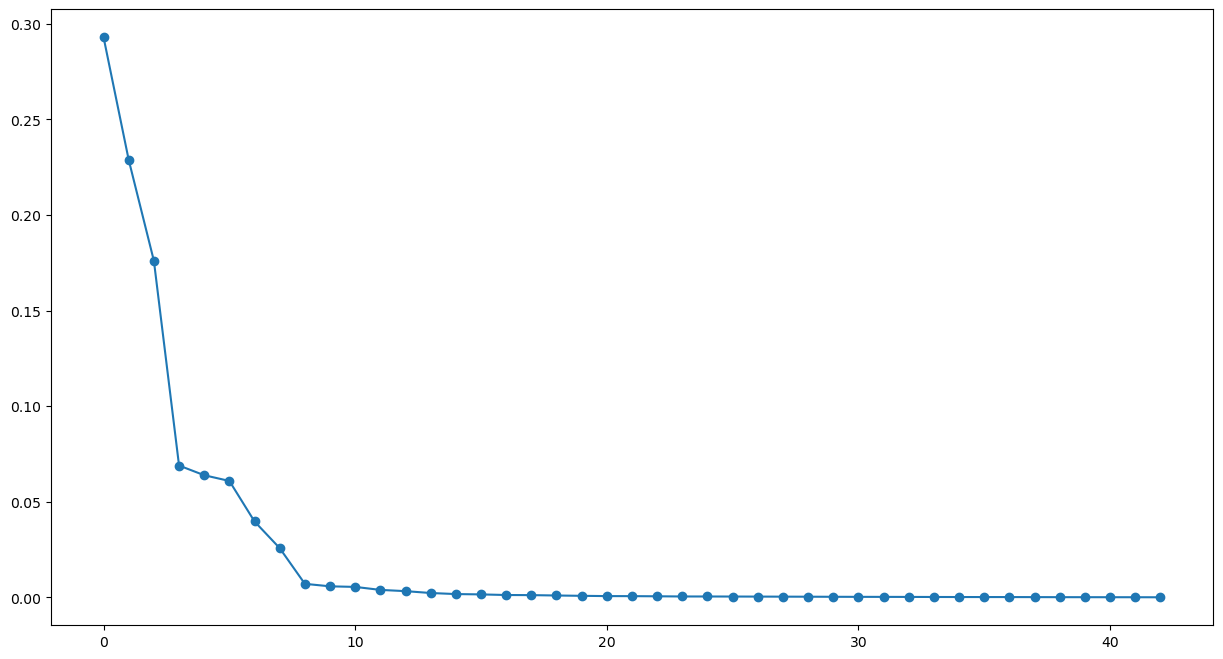

In [14]:
scaler = StandardScaler()
scaler.fit(full_wide)
fw_scaled = scaler.transform(full_wide)  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

#### Plotting the first two components
ESMs clearly clustered using first two principal components.

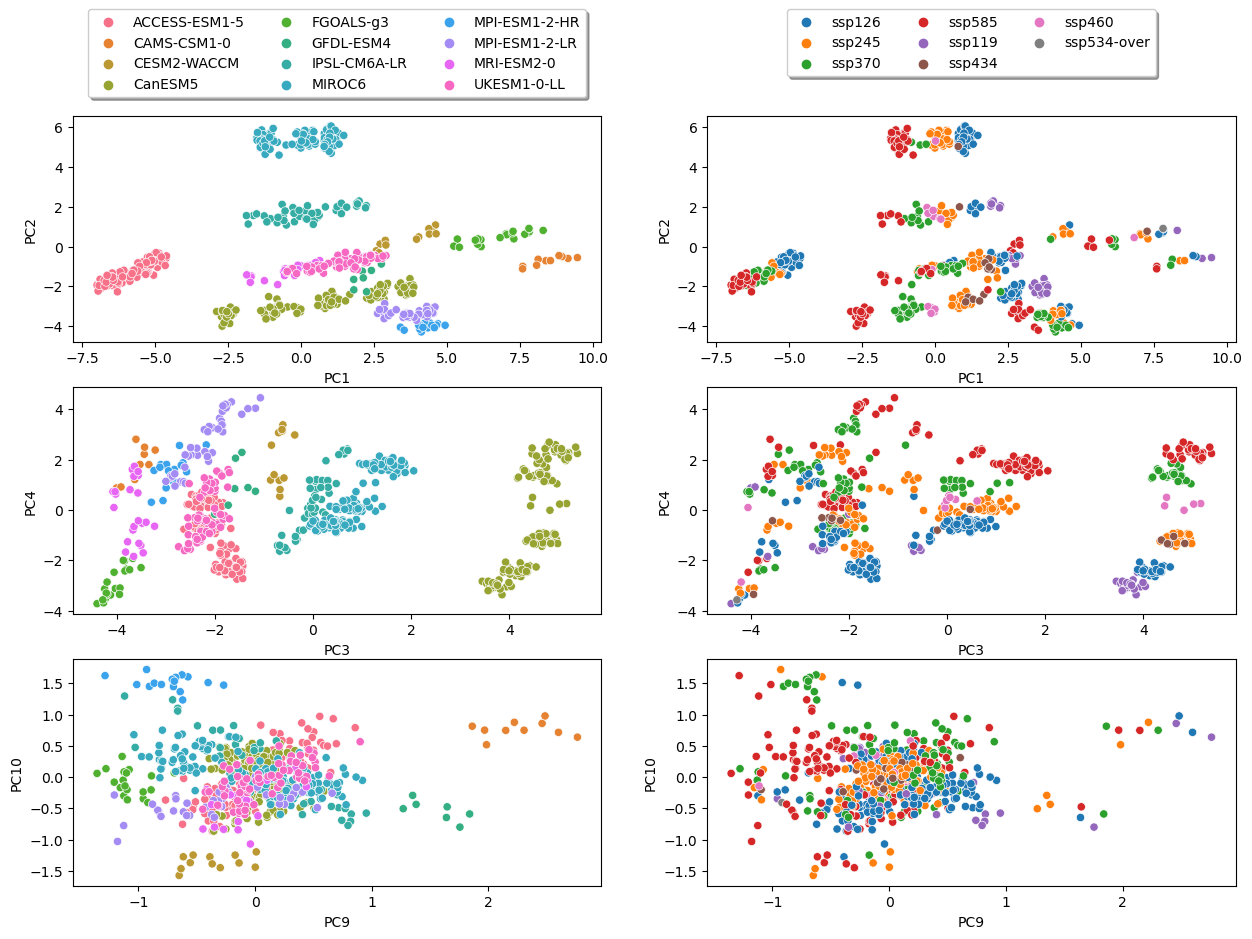

In [15]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
           ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
           ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax5, x=full_pca[:,8], y=full_pca[:,9], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax5.legend_ = None
ax5.set(xlabel="PC{}".format(9), ylabel="PC{}".format(10))

sns.scatterplot(ax=ax6, x=full_pca[:,8], y=full_pca[:,9], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax6.legend_ = None
ax6.set(xlabel="PC{}".format(9), ylabel="PC{}".format(10))

plt.show()
plt.close()

#### Components 3 & 4
ESMs still quite clustered, but less so, for sure.

#### Function for plotting components with weight vectors

In [16]:
def myplot(score,coeff,cutoffone,cutofftwo,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    sns.scatterplot(x=xs * scalex,y=ys * scaley, hue = [full_wide.index[i][0] for i in range(full_wide.shape[0])])
    #plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        if (np.abs(coeff[i,0]) >= cutoffone) or (np.abs(coeff[i,1]) >= cutofftwo):
            plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, full_wide.columns.values[i], color = 'g', ha = 'center', va = 'center')
            else:
                plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
#plt.grid()
plt.close()

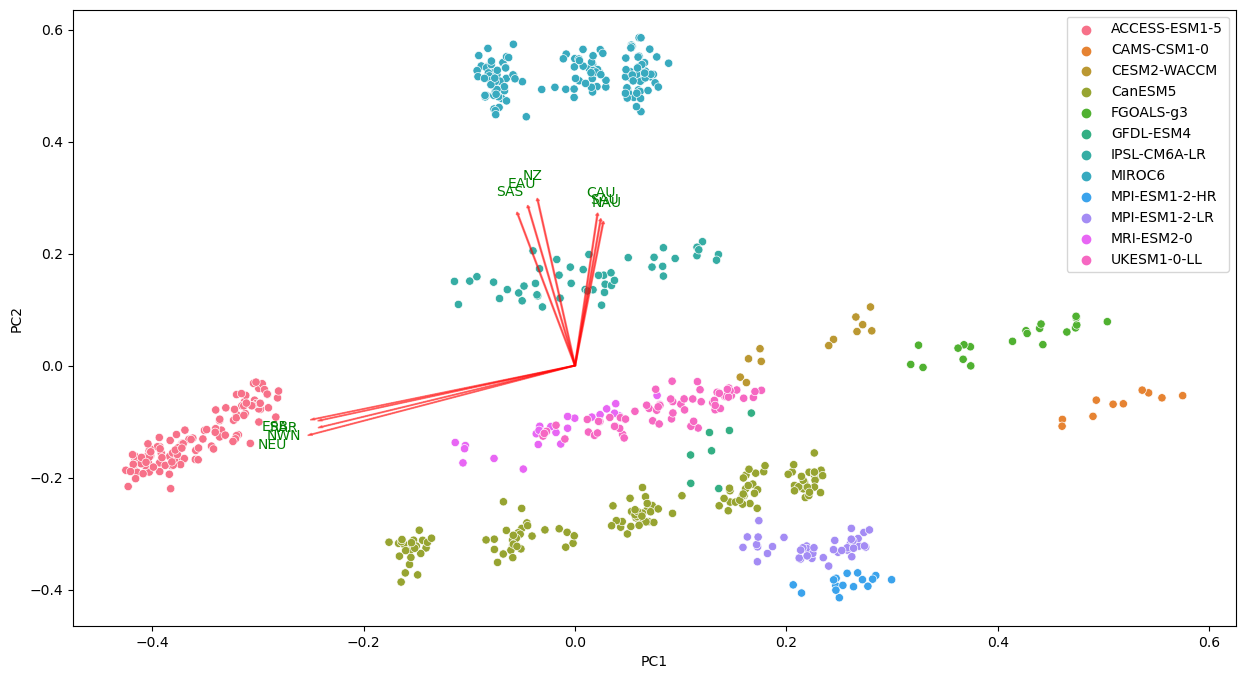

In [17]:
# First Component, mean precipitation in Siberia, North East Russia, North West North America
# Second Component, mean precipitation in Australia and South Asia
plt.figure(figsize=(15,8))
myplot(full_pca[:,0:2],np.transpose(pca.components_[0:2, :]),0.23,0.25)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.show()
plt.close()

For third and fourth components, interpretation even more so not as clear. Can see the regions of course, but the groupings aren't particular intuitive.

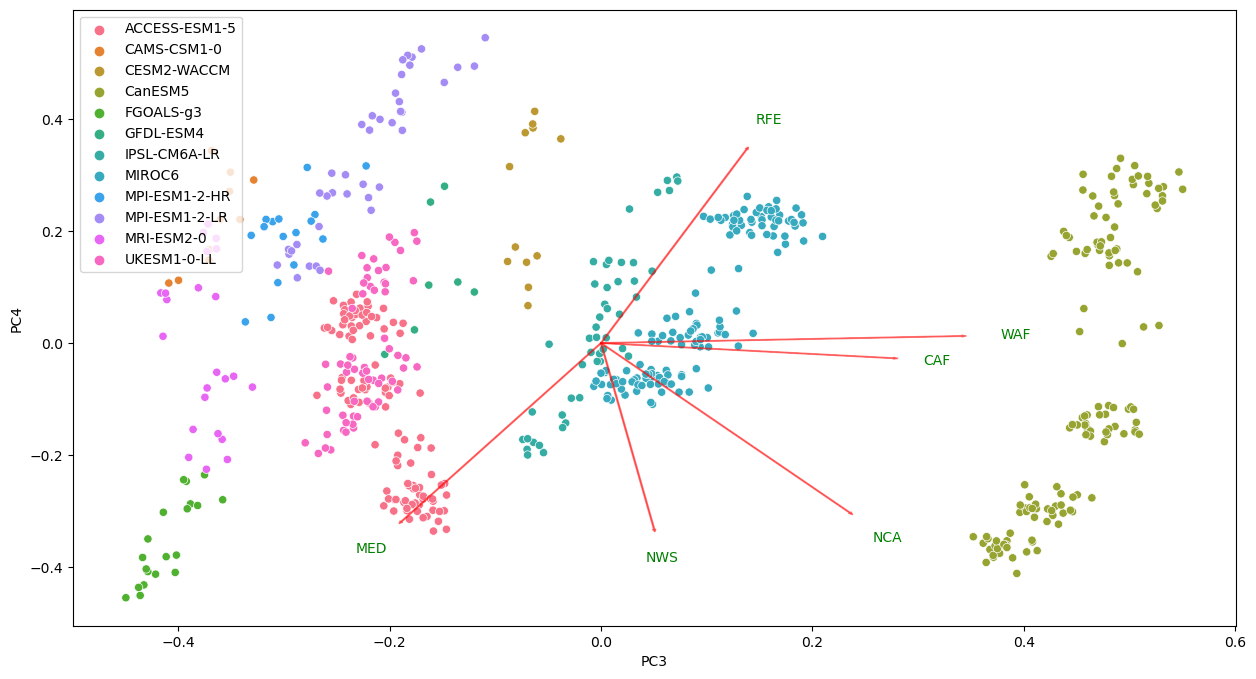

In [18]:
# First Component, mean precipitation in Central/Western Africa
# Second Component, mean precipitation in Australia and South Asia
plt.figure(figsize=(15,8))
myplot(full_pca[:,2:4],np.transpose(pca.components_[2:4, :]),0.25,0.25)
plt.xlabel("PC{}".format(3))
plt.ylabel("PC{}".format(4))
plt.show()
plt.close()

### Looking at Components by Region

In [19]:
import geopandas as gpd

#### Preparing data

In [20]:
# Load in data
url = 'IPCC-WGI-reference-regions-v4_shapefile.zip'
land_main_gdf = gpd.read_file(url)
IPCC_names  = land_main_gdf['Acronym'].unique()

In [21]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
region_names = pd.DataFrame({
    'Name': land_main_gdf.Name.values,
    'Acronym': land_main_gdf.Acronym.values
})
pc_df_named = pd.merge(region_names, pc_df, left_on='Acronym', right_on='region', how='right')

In [22]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
pc_df
land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

Here, since each of our variables is mean precip flux, just for a different region, we can look at the coefficient of each region by principal component. This should help in interpretation, perhaps better than the vectors on the plots above.

We can see which regions are weighted heavily in each principal component.

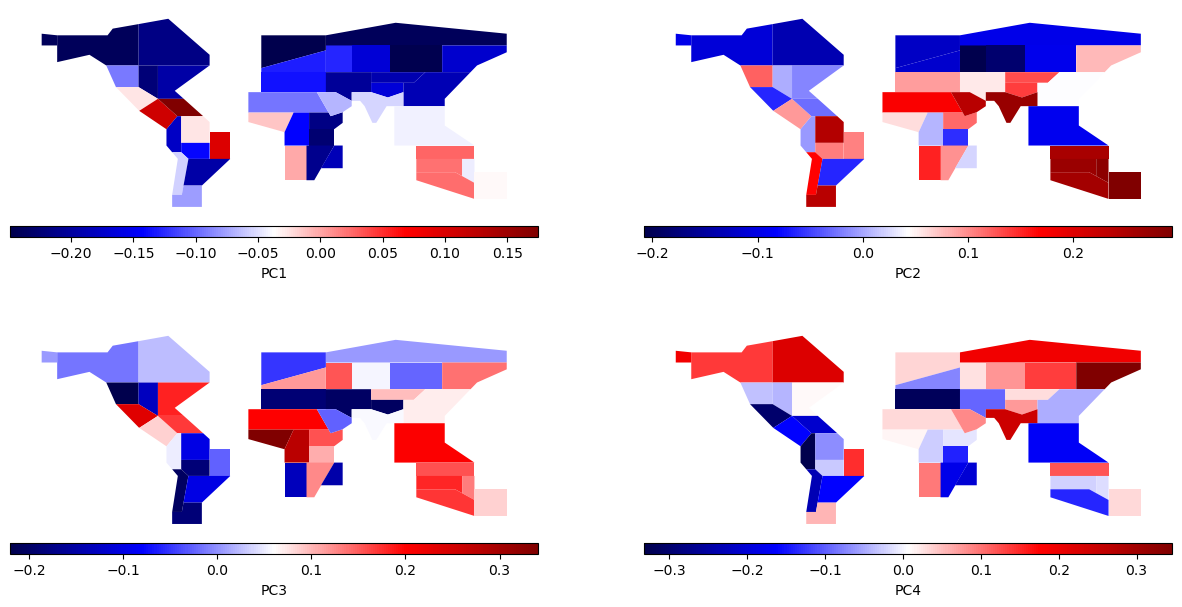

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
vmin = -0.25
vmax = 0.25

# Optional grey out small weighted regions
# land_data.loc[np.abs(land_data['PC1']) < 0.1, 'PC1'] = np.nan
# land_data.loc[np.abs(land_data['PC2']) < 0.15, 'PC2'] = np.nan
# land_data.loc[np.abs(land_data['PC3']) < 0.2, 'PC3'] = np.nan
# land_data.loc[np.abs(land_data['PC4']) < 0.2, 'PC4'] = np.nan


component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
#land_data.loc[np.abs(land_data['PC1']) < 0.1] = np.nan
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.3)

plt.show()
plt.close()

# PCA tas

In [24]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
regional_data = pd.concat([region_summary(format_input(data_dir, file, 'tas', regional=True), np.mean) for file in files])

In [25]:
full_data = pd.concat([regional_data])
full_data

esm  experiment   ensemble variable acronym  \
0     ACCESS-ESM1-5  historical  r10i1p1f1      tas     ARP   
5     ACCESS-ESM1-5  historical  r10i1p1f1      tas     CAF   
10    ACCESS-ESM1-5  historical  r10i1p1f1      tas     CAR   
15    ACCESS-ESM1-5  historical  r10i1p1f1      tas     CAU   
20    ACCESS-ESM1-5  historical  r10i1p1f1      tas     CNA   
...             ...         ...        ...      ...     ...   
3434      GFDL-ESM4      ssp585   r1i1p1f1      tas    WSAF   
3436      GFDL-ESM4      ssp585   r1i1p1f1      tas     WSB   
3437      GFDL-ESM4      ssp585   r1i1p1f1      tas     WSB   
3438      GFDL-ESM4      ssp585   r1i1p1f1      tas     WSB   
3439      GFDL-ESM4      ssp585   r1i1p1f1      tas     WSB   

                          year  summary_value  
0     [1995-01-01, 2015-01-01)     296.733598  
5     [1995-01-01, 2015-01-01)     299.770269  
10    [1995-01-01, 2015-01-01)     300.028126  
15    [1995-01-01, 2015-01-01)     297.284557  
20    [1995-01-01, 2015-01-01)     287.639627  
...                        ...            ...  
3434  [2075-01-01, 2095-01-01)     296.583726  
3436  [2015-01-01, 2035-01-01)     275.974654  
3437  [2035-01-01, 2055-01-01)     276.998721  
3438  [2055-01-01, 2075-01-01)     278.181250  
3439  [2075-01-01, 2095-01-01)     279.721828  

[116874 rows x 7 columns]

In [26]:
full_wide = full_data[full_data.year == full_data.year.values[-1]].\
    rename(columns={'summary_value': 'mean_tas'}).\
        pivot_table('mean_tas', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym').dropna()
full_wide

acronym                                                                      ARP  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  298.933728   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  298.918643   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  298.970906   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  298.964493   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  298.998965   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  305.069895   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  305.191209   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  305.250036   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  305.376205   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  305.208554   

acronym                                                                      CAF  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  301.375324   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  301.240157   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  301.290979   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  301.307998   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  301.355898   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  305.784363   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  305.842867   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  305.891779   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  305.857653   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  305.770646   

acronym                                                                      CAR  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  301.276503   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  301.276722   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  301.396007   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  301.351326   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  301.350612   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075-01-01, 2095-01-01)  303.797040   
                         r2i1p1f2  tas      [2075-01-01, 2095-01-01)  303.698394   
                         r3i1p1f2  tas      [2075-01-01, 2095-01-01)  303.674989   
                         r4i1p1f2  tas      [2075-01-01, 2095-01-01)  303.852812   
                         r8i1p1f2  tas      [2075-01-01, 2095-01-01)  303.674472   

acronym                                                                      CAU  \
esm           experiment ensemble  variable year                                   
ACCESS-ESM1-5 ssp126     r10i1p1f1 tas      [2075-01-01, 2095-01-01)  298.789126   
                         r11i1p1f1 tas      [2075-01-01, 2095-01-01)  298.646378   
                         r12i1p1f1 tas      [2075-01-01, 2095-01-01)  298.703391   
                         r13i1p1f1 tas      [2075-01-01, 2095-01-01)  298.756075   
                         r14i1p1f1 tas      [2075-01-01, 2095-01-01)  298.695519   
...                                                                          ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas      [2075

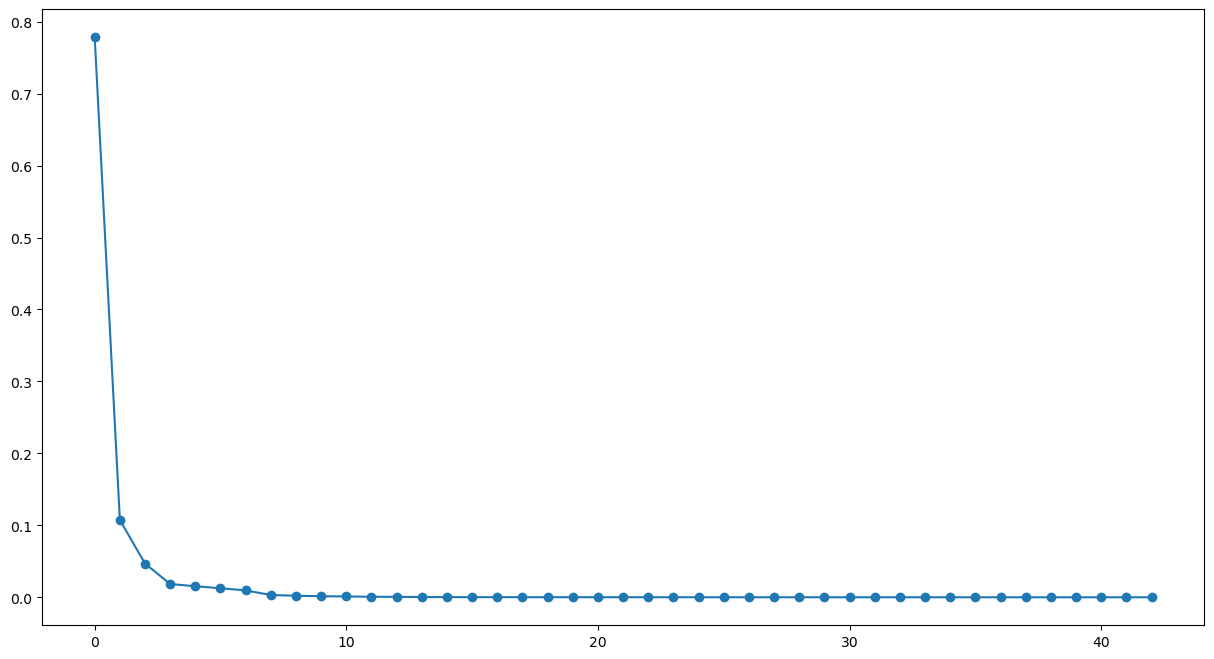

In [27]:
scaler = StandardScaler()
scaler.fit(full_wide)
fw_scaled = scaler.transform(full_wide)  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

For mean temp PCA, first component seems to separate scenarios, and second component separates the models. The Third and fourth components again cluster models, but do little to differentiate scenarios within.

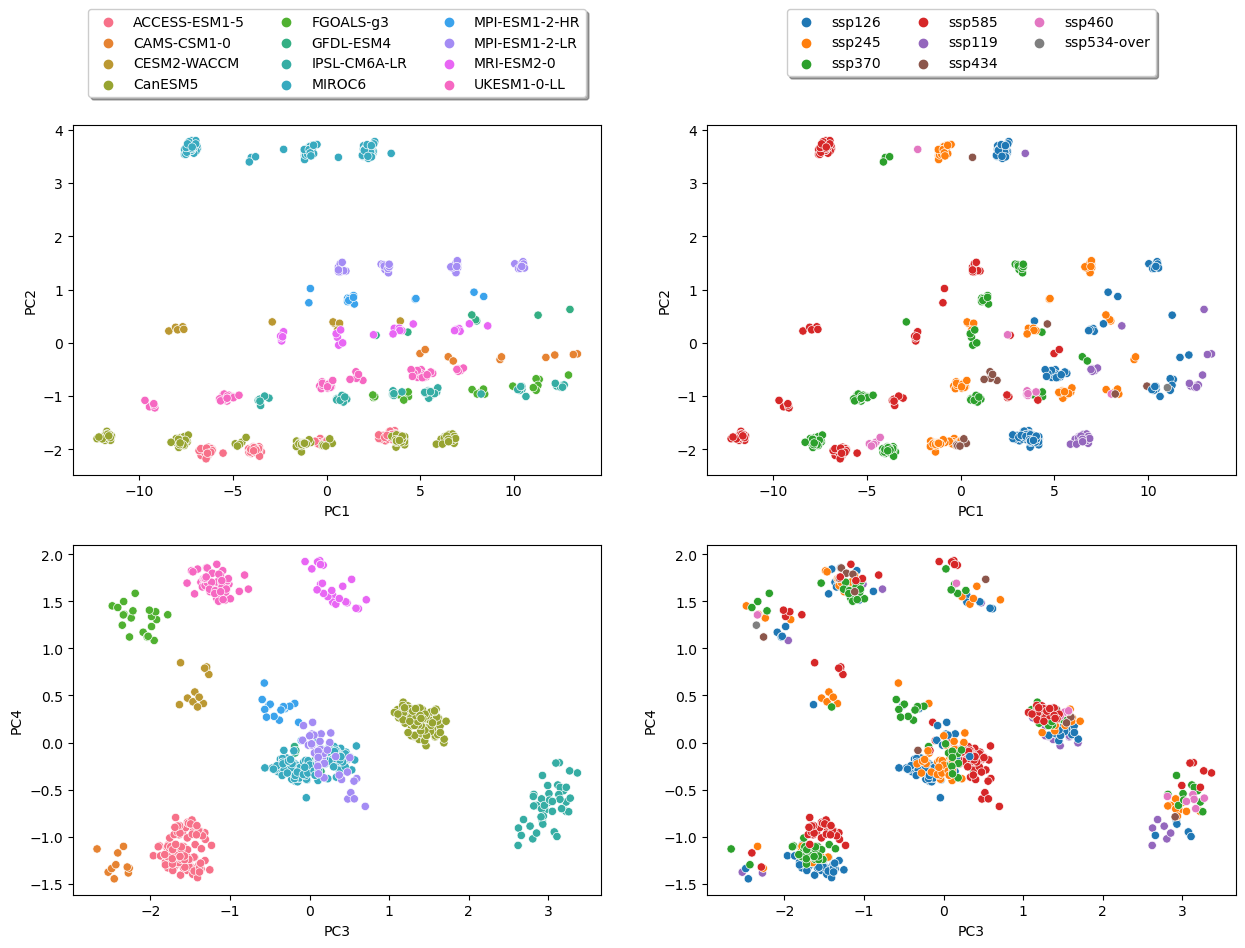

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][0] for i in range(full_wide.shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_wide.index[i][1] for i in range(full_wide.shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

plt.show()
plt.close()

First component is a wholistic view. Each region (including global and conus) have similar weight. The other components focus on specific regions seen below.

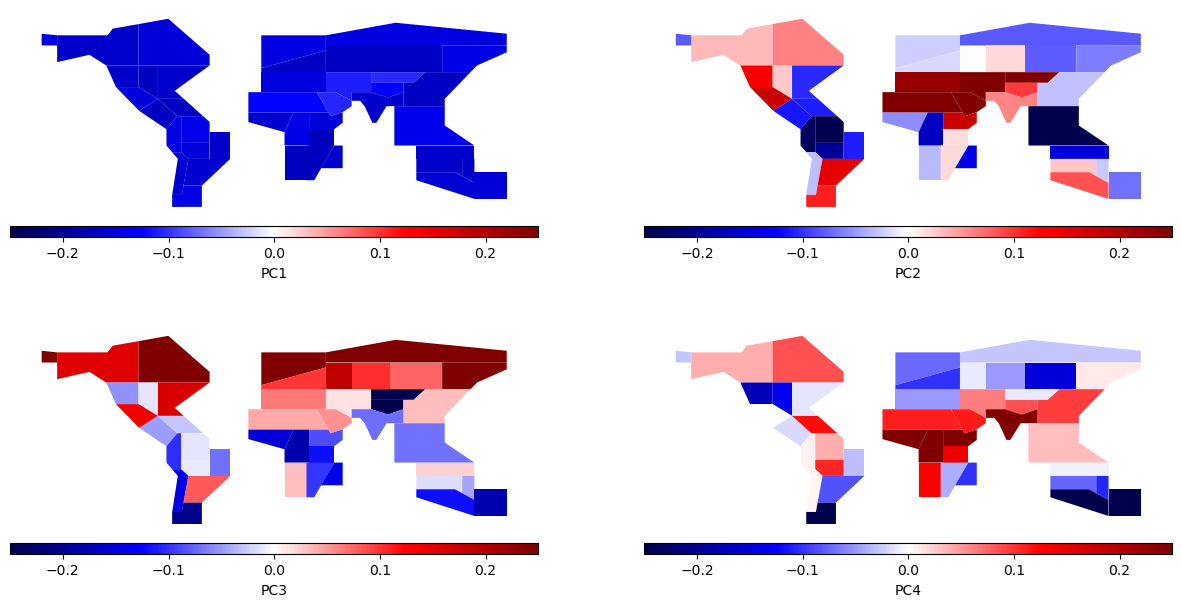

In [29]:
pc_df = pd.DataFrame({
    'region': full_wide.columns.values,
    'PC1': np.transpose(pca.components_[0, :]),
    'PC2': np.transpose(pca.components_[1, :]),
    'PC3': np.transpose(pca.components_[2, :]),
    'PC4': np.transpose(pca.components_[3, :])
})
land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
vmin = -0.25
vmax = 0.25

# Optional grey out small weighted regions
# land_data.loc[np.abs(land_data['PC1']) < 0.2, 'PC1'] = np.nan
# land_data.loc[np.abs(land_data['PC2']) < 0.2, 'PC2'] = np.nan
# land_data.loc[np.abs(land_data['PC3']) < 0.2, 'PC3'] = np.nan
# land_data.loc[np.abs(land_data['PC4']) < 0.2, 'PC4'] = np.nan


component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.3)

plt.show()
plt.close()

# General PCA

In [30]:
def my_pca(wide_data):
    # Do PCA
    scaler = StandardScaler()
    scaler.fit(wide_data)
    fw_scaled = scaler.transform(wide_data)  
    pca = PCA()
    full_pca = pca.fit_transform(fw_scaled)

    # Plot ratio var explained
    fig = plt.figure(figsize=(15,10))
    plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
    plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)

    return full_pca, pca, fig

In [31]:
def pca_components_plot(wide_data, pca_output):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    sns.scatterplot(ax=ax1, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax2, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax3, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax3.legend_ = None
    ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    sns.scatterplot(ax=ax4, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax4.legend_ = None
    ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    return fig

In [32]:
def pca_by_region_plot(wide_data, pca, vmin=-0.25, vmax=0.25):
    pc_df = pd.DataFrame({
        'region': wide_data.columns.values,
        'PC1': np.transpose(pca.components_[0, :]),
        'PC2': np.transpose(pca.components_[1, :]),
        'PC3': np.transpose(pca.components_[2, :]),
        'PC4': np.transpose(pca.components_[3, :])
    })
    land_data = pd.merge(land_main_gdf, pc_df, left_on='Acronym', right_on='region', how='inner')

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    component = 'PC1'
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
    ax1.set_axis_off()
    land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC2'
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
    ax2.set_axis_off()
    land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC3'
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
    ax3.set_axis_off()
    land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )

    component = 'PC4'
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
    ax4.set_axis_off()
    land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
        legend_kwds={"label": component, "orientation": "horizontal"}, # vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgrey'}
    )
    fig.subplots_adjust(hspace=-0.3)

    return fig

In [33]:
def generalized_pca(files, input_dir, variable, regional, fn, **kwargs):
    # Read in an format data
    inputs = [format_input(input_dir, file, variable, regional=regional) for file in files]
    input = pd.concat(inputs)

    # Get summary metric for final period
    summarized = region_summary(input, fn, **kwargs)

    # For change in value
    hist_data = summarized[summarized['experiment'] == 'historical'][['esm', 'ensemble', 'acronym', 'summary_value']]
    hist_data = hist_data.rename(columns = {'summary_value': 'hist_value'})
    merged_data = pd.merge(hist_data, data, how = 'left', left_on = ['esm', 'ensemble', 'acronym'], right_on = ['esm', 'ensemble', 'acronym'])
    merged_data['summary_value'] = merged_data['summary_value'] - merged_data['hist_value']
    summarized = merged_data.loc[:, merged_data.columns != 'hist_value']

    # Get last year
    summarized = summarized[summarized.year == summarized.year.values[-1]]

    # Turn into wide format
    wide = summarized.pivot_table('summary_value', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym').dropna()

    # PCA
    full_pca, pca, fig1 = my_pca(wide)

    # PCA component plots
    fig2 = pca_components_plot(wide, full_pca)

    # PCA by region plot
    fig3 = pca_by_region_plot(wide, pca)
    return summarized, fig1, fig2, fig3

# Mean tas Change

In [34]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, np.mean)

KeyError: 'summary_value'

In [ ]:
data

esm   ensemble acronym experiment variable  \
0      ACCESS-ESM1-5  r10i1p1f1     ARP     ssp126      tas   
1      ACCESS-ESM1-5  r10i1p1f1     ARP     ssp585      tas   
2      ACCESS-ESM1-5  r10i1p1f1     CAF     ssp126      tas   
3      ACCESS-ESM1-5  r10i1p1f1     CAF     ssp585      tas   
4      ACCESS-ESM1-5  r10i1p1f1     CAR     ssp126      tas   
...              ...        ...     ...        ...      ...   
27515    UKESM1-0-LL   r9i1p1f2    WSAF     ssp245      tas   
27516    UKESM1-0-LL   r9i1p1f2    WSAF     ssp370      tas   
27517    UKESM1-0-LL   r9i1p1f2     WSB     ssp126      tas   
27518    UKESM1-0-LL   r9i1p1f2     WSB     ssp245      tas   
27519    UKESM1-0-LL   r9i1p1f2     WSB     ssp370      tas   

                           year  summary_value  
0      [2075-01-01, 2095-01-01)       2.200130  
1      [2075-01-01, 2095-01-01)       5.168463  
2      [2075-01-01, 2095-01-01)       1.605055  
3      [2075-01-01, 2095-01-01)       4.145225  
4      [2075-01-01, 2095-01-01)       1.248377  
...                         ...            ...  
27515  [2075-01-01, 2095-01-01)       3.485379  
27516  [2075-01-01, 2095-01-01)       4.713365  
27517  [2075-01-01, 2095-01-01)       4.072419  
27518  [2075-01-01, 2095-01-01)       5.658540  
27519  [2075-01-01, 2095-01-01)       7.459805  

[26445 rows x 7 columns]

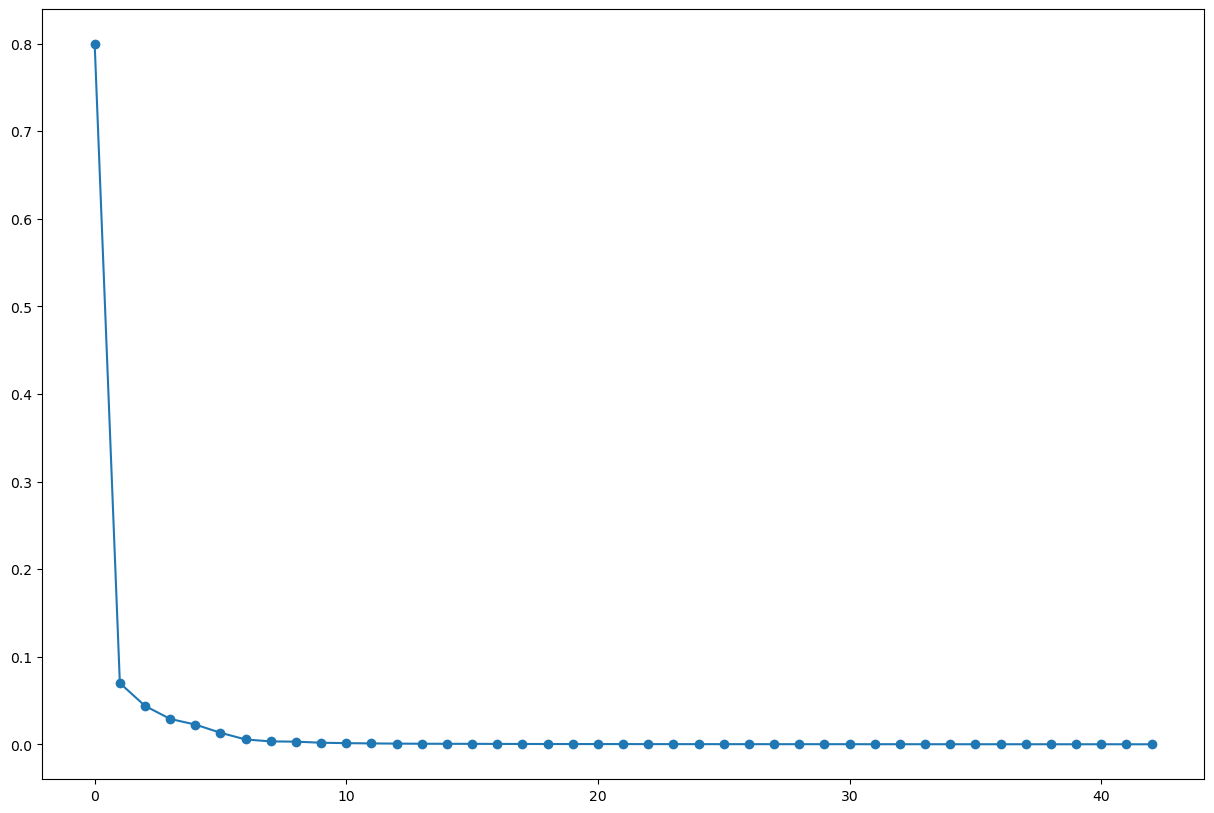

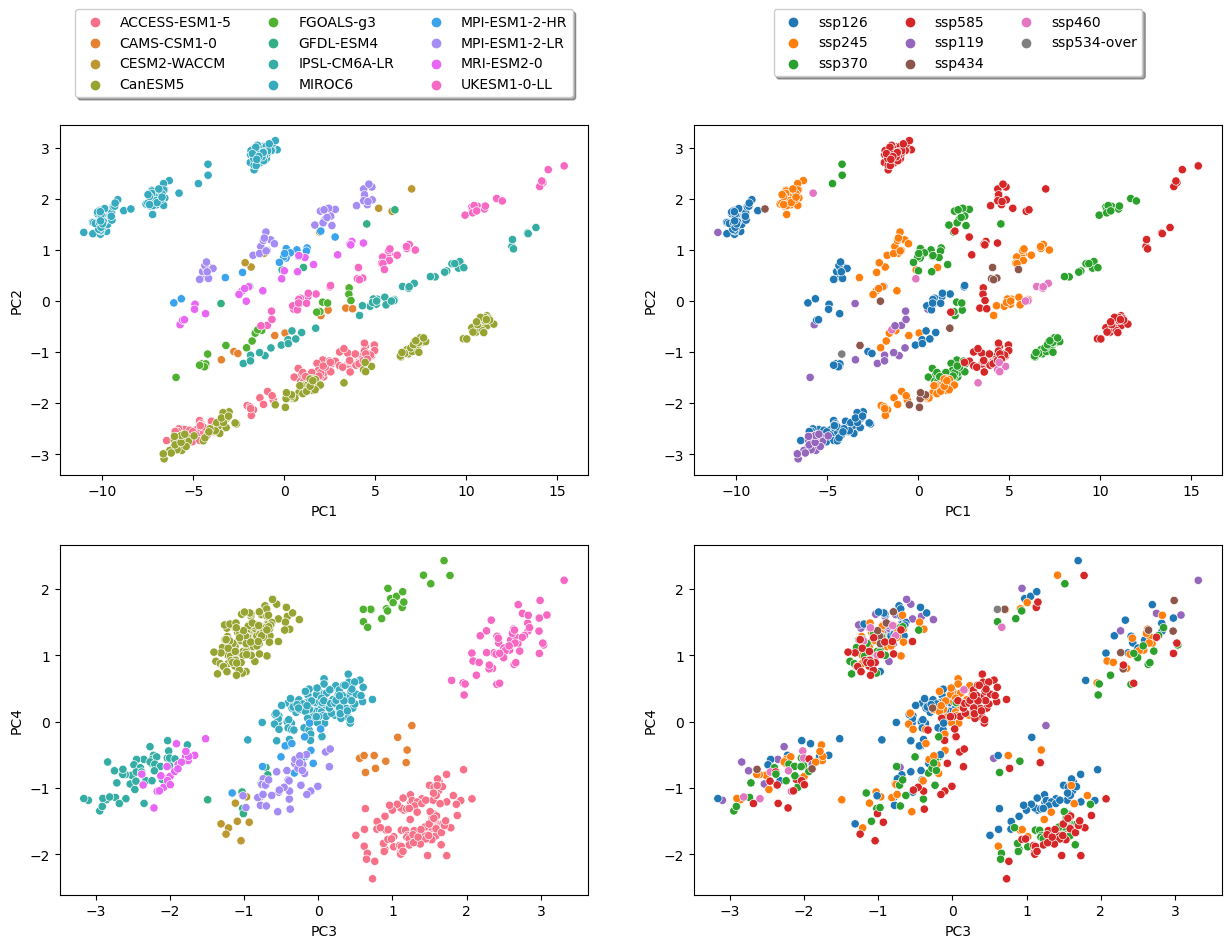

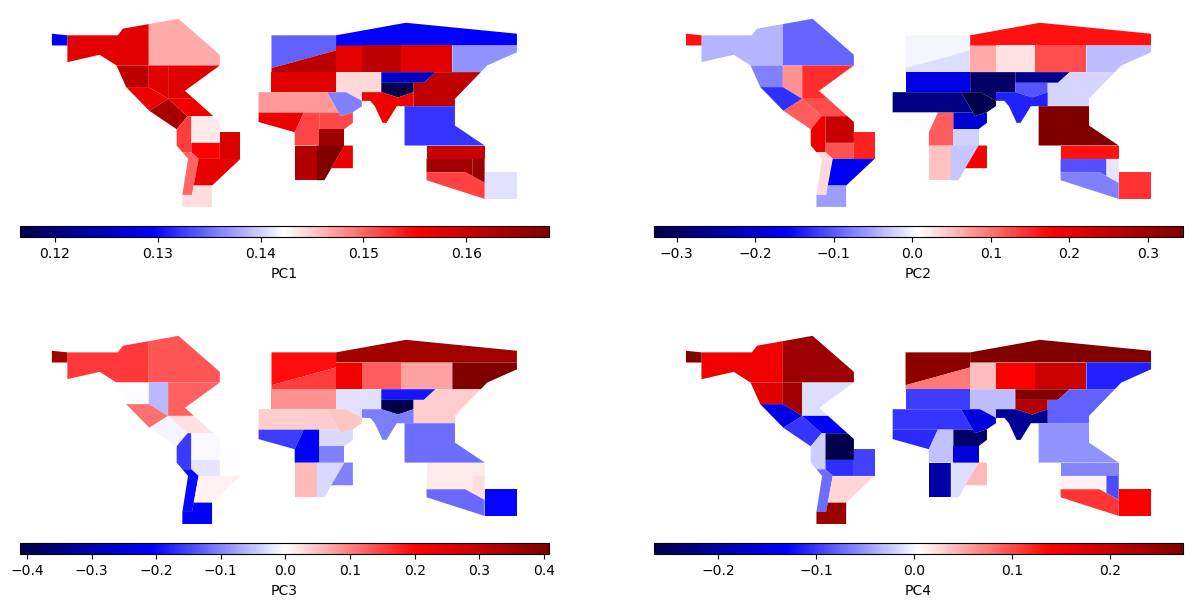

In [ ]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, np.mean)

# "Heatwave" PCA

Truly does not work. Doesn't really make sense, just wanted to try. Possibly reasonable with daily data. Same goes for next section.

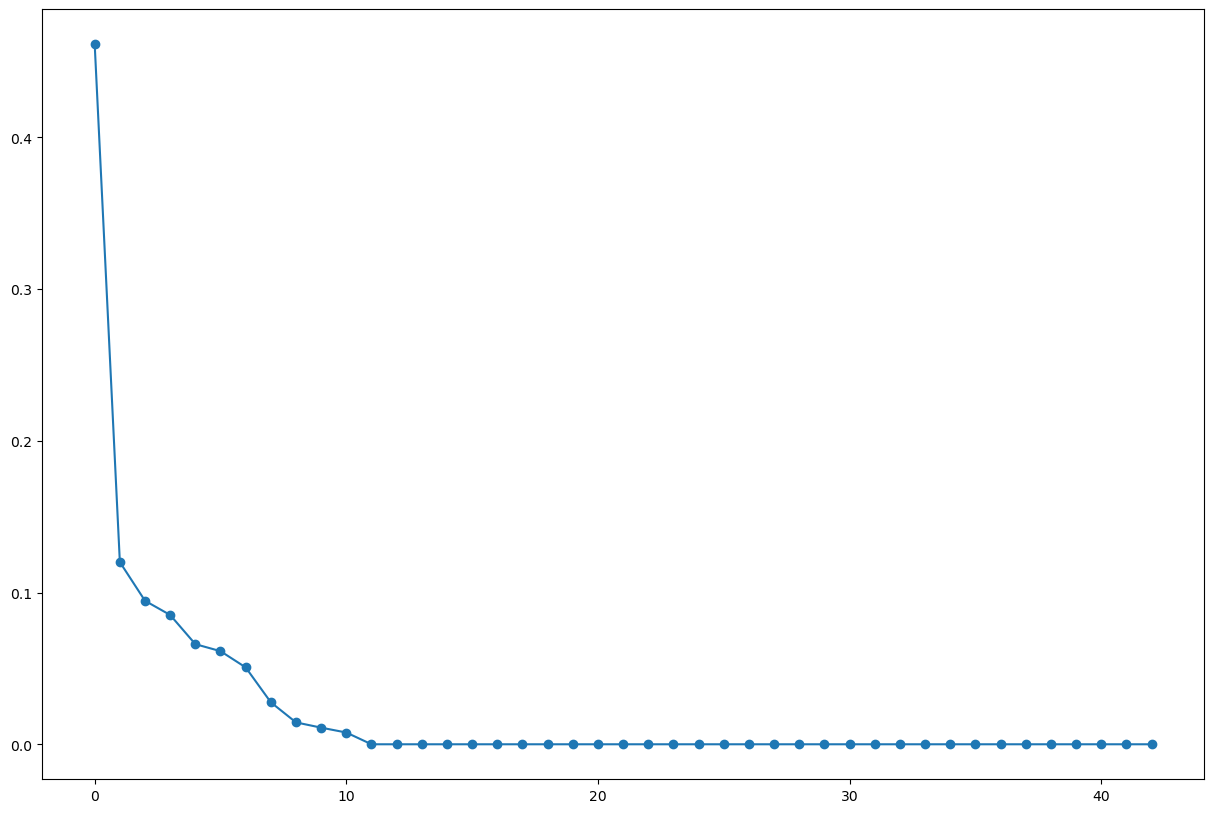

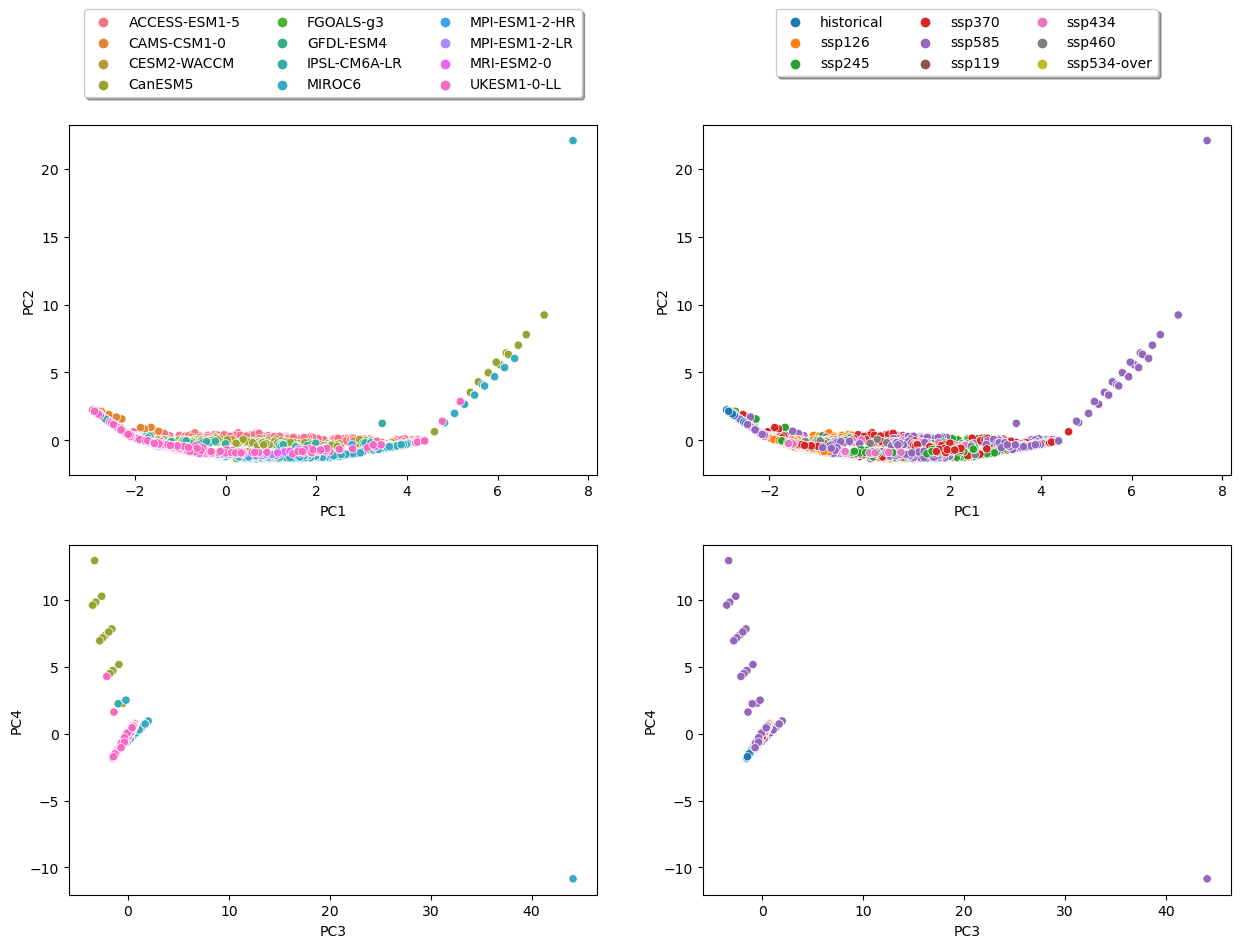

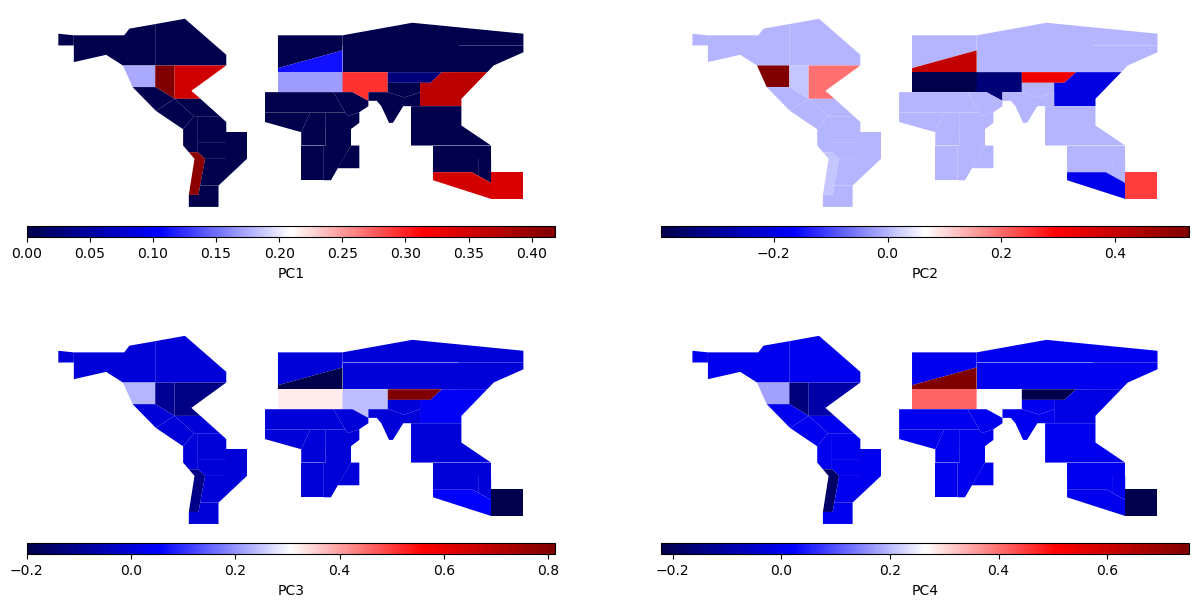

In [ ]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_tas_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'tas', True, months_above_thresh)

# "Drought" PCA

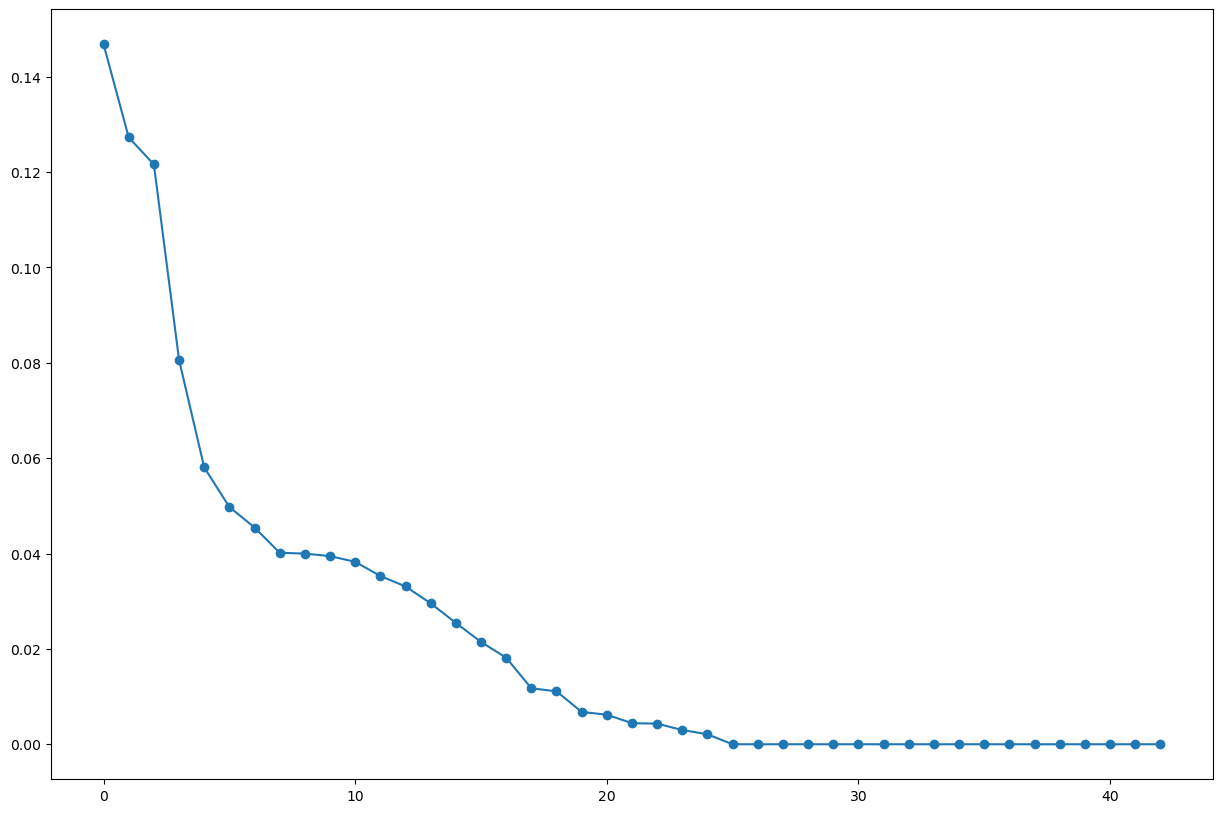

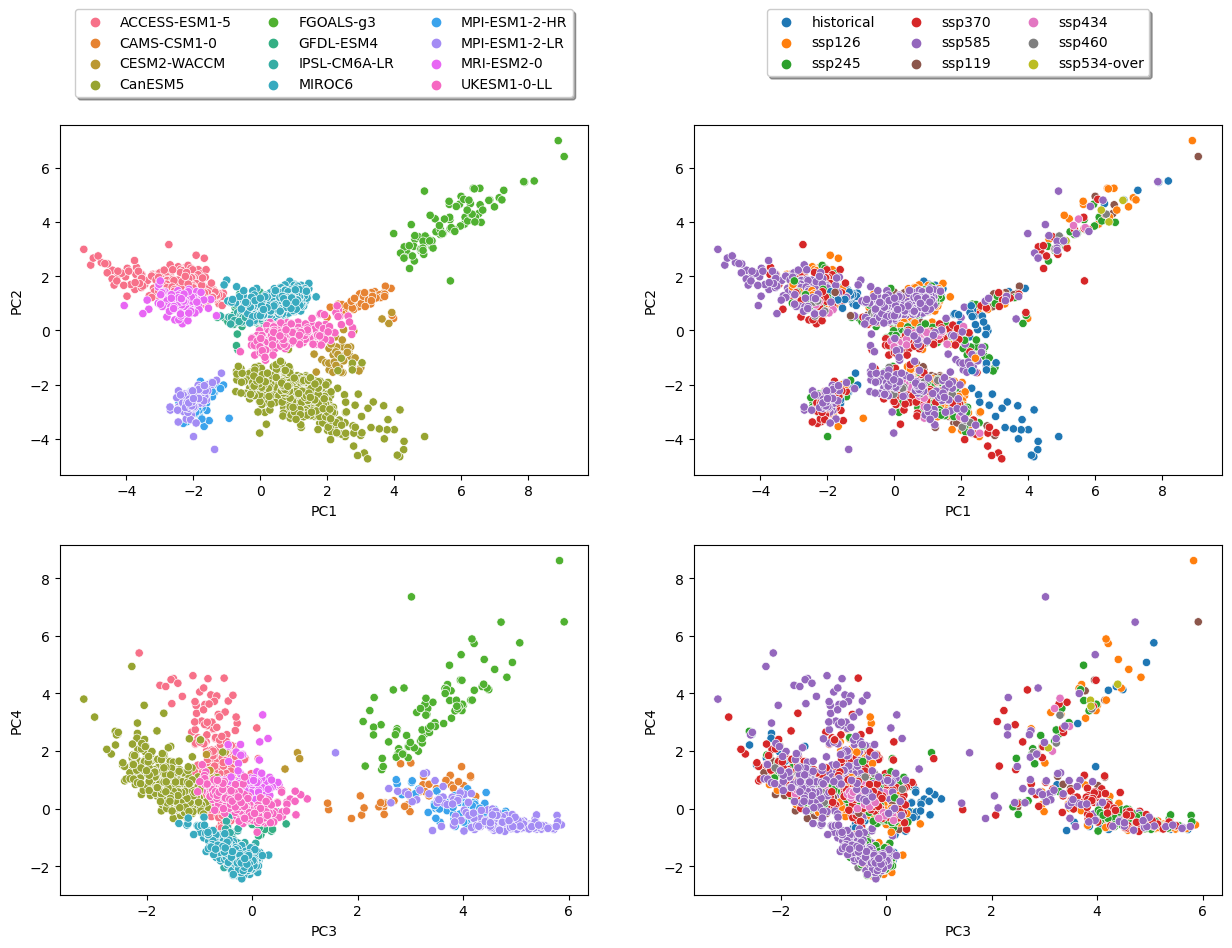

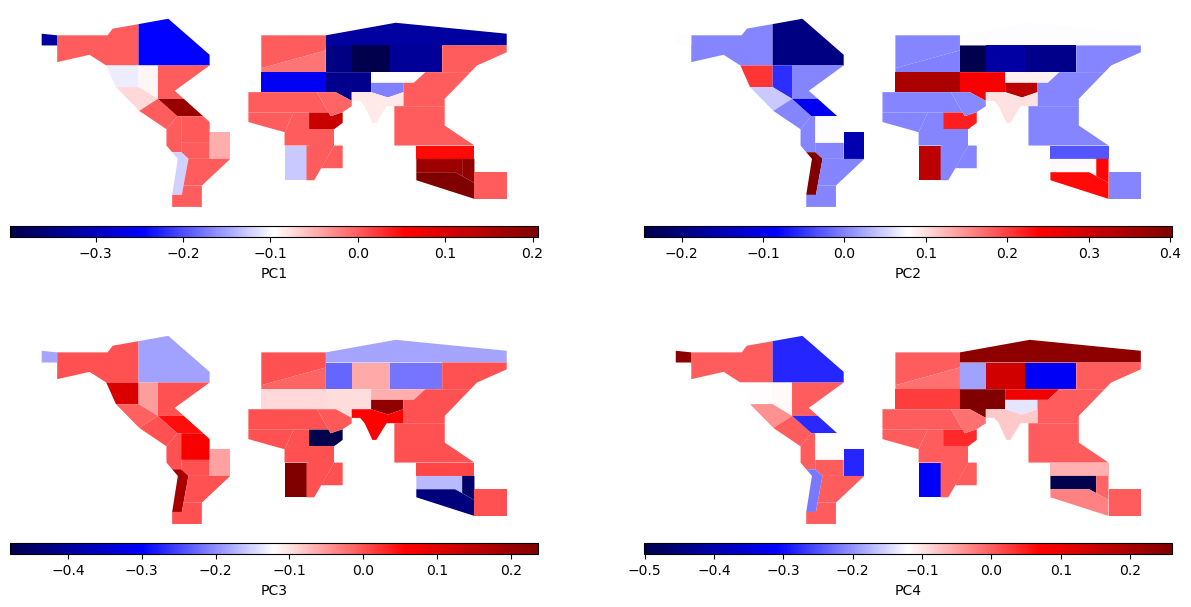

In [ ]:
files = [os.path.basename(x) for x in glob.glob(os.path.join(data_dir,'IPCC_land_regions_pr_*_timeseries_1980_2099.csv'))]
data, fig1, fig2, fig3 = generalized_pca(files, data_dir, 'pr', True, months_above_thresh, **{'thresh':0.0000157})

# IASD

In [ ]:
data_dir = 'extracted_timeseries'
file_name = 'IPCC_all_regions_and_data.csv'

In [ ]:
full_data = pd.read_csv(os.path.join(data_dir, file_name))
full_data.drop(columns = ['tas','pr'], inplace = True)
full_data

year          esm  experiment  ensemble variable      continent  \
0        1980  CAMS-CSM1-0  historical  r1i1p1f1       pr          POLAR   
1        1980  CAMS-CSM1-0  historical  r1i1p1f1       pr  NORTH-AMERICA   
2        1980  CAMS-CSM1-0  historical  r1i1p1f1       pr  NORTH-AMERICA   
3        1980  CAMS-CSM1-0  historical  r1i1p1f1       pr  NORTH-AMERICA   
4        1980  CAMS-CSM1-0  historical  r1i1p1f1       pr  NORTH-AMERICA   
...       ...          ...         ...       ...      ...            ...   
7025535  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025536  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025537  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025538  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025539  2099      CanESM5      ssp434  r5i1p1f1      tas       SOUTHERN   

          type                    name acronym       value  
0         Land       Greenland/Iceland     GIC    0.000015  
1         Land       N.W.North-America     NWN    0.000022  
2         Land       N.E.North-America     NEN    0.000018  
3         Land         W.North-America     WNA    0.000023  
4         Land         C.North-America     CNA    0.000027  
...        ...                     ...     ...         ...  
7025535  Ocean             Arabian-Sea     ARS  302.531357  
7025536  Ocean           Bay-of-Bengal     BOB  303.576002  
7025537  Ocean  Equatorial.Indic-Ocean     EIO  303.502596  
7025538  Ocean           S.Indic-Ocean     SIO  297.283593  
7025539  Ocean          Southern-Ocean     SOO  277.553527  

[7025540 rows x 10 columns]

In [ ]:
tas_ts = full_data[full_data['variable'] == 'tas']
tas_ts

year          esm  experiment  ensemble variable      continent  \
2030     1980  CAMS-CSM1-0  historical  r1i1p1f1      tas          POLAR   
2031     1980  CAMS-CSM1-0  historical  r1i1p1f1      tas  NORTH-AMERICA   
2032     1980  CAMS-CSM1-0  historical  r1i1p1f1      tas  NORTH-AMERICA   
2033     1980  CAMS-CSM1-0  historical  r1i1p1f1      tas  NORTH-AMERICA   
2034     1980  CAMS-CSM1-0  historical  r1i1p1f1      tas  NORTH-AMERICA   
...       ...          ...         ...       ...      ...            ...   
7025535  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025536  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025537  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025538  2099      CanESM5      ssp434  r5i1p1f1      tas         INDIAN   
7025539  2099      CanESM5      ssp434  r5i1p1f1      tas       SOUTHERN   

          type                    name acronym       value  
2030      Land       Greenland/Iceland     GIC  257.786163  
2031      Land       N.W.North-America     NWN  267.549344  
2032      Land       N.E.North-America     NEN  264.798775  
2033      Land         W.North-America     WNA  280.681924  
2034      Land         C.North-America     CNA  284.808439  
...        ...                     ...     ...         ...  
7025535  Ocean             Arabian-Sea     ARS  302.531357  
7025536  Ocean           Bay-of-Bengal     BOB  303.576002  
7025537  Ocean  Equatorial.Indic-Ocean     EIO  303.502596  
7025538  Ocean           S.Indic-Ocean     SIO  297.283593  
7025539  Ocean          Southern-Ocean     SOO  277.553527  

[3514220 rows x 10 columns]

In [ ]:
import statsmodels.api as sm

In [ ]:
tas_grouped = tas_ts.groupby(
    ['esm', 'experiment', 'ensemble', 'variable', 'acronym']
)

In [ ]:
def loess(df):
    output = sm.nonparametric.lowess(df['value'].values, df['year'].values)
    smooth_y = list(zip(*output))[1]
    iasd = np.std(smooth_y - df['value'].values )
    df = df[['type', 'name']].head(1)
    df['iasd'] = iasd
    return df

In [ ]:
tas_iasd = tas_grouped.apply(loess)
tas_iasd

type  \
esm           experiment ensemble  variable acronym                  
ACCESS-ESM1-5 historical r10i1p1f1 tas      ARO     2873946  Ocean   
                                            ARP     2873936   Land   
                                            ARS     2873953  Ocean   
                                            BOB     2873954  Ocean   
                                            CAF     2873922   Land   
...                                                            ...   
UKESM1-0-LL   ssp585     r8i1p1f2  tas      WCA     5489442   Land   
                                            WCE     5489427   Land   
                                            WNA     5489413   Land   
                                            WSAF    5489435   Land   
                                            WSB     5489439   Land   

                                                                            name  \
esm           experiment ensemble  variable acronym                                
ACCESS-ESM1-5 historical r10i1p1f1 tas      ARO     2873946         Arctic-Ocean   
                                            ARP     2873936    Arabian-Peninsula   
                                            ARS     2873953          Arabian-Sea   
                                            BOB     2873954        Bay-of-Bengal   
                                            CAF     2873922       Central-Africa   
...                                                                          ...   
UKESM1-0-LL   ssp585     r8i1p1f2  tas      WCA     5489442             W.C.Asia   
                                            WCE     5489427  West&Central-Europe   
                                            WNA     5489413      W.North-America   
                                            WSAF    5489435    W.Southern-Africa   
                                            WSB     5489439            W.Siberia   

                                                                 iasd  
esm           experiment ensemble  variable acronym                    
ACCESS-ESM1-5 historical r10i1p1f1 tas      ARO     2873946  0.581483  
                                            ARP     2873936  0.304199  
                                            ARS     2873953  0.180148  
                                            BOB     2873954  0.120539  
                                            CAF     2873922  0.205891  
...                                                               ...  
UKESM1-0-LL   ssp585     r8i1p1f2  tas      WCA     5489442  0.455292  
                                            WCE     5489427  0.683301  
                                            WNA     5489413  0.460177  
                                            WSAF    5489435  0.269521  
                                            WSB     5489439  0.857713  

[48372 rows x 3 columns]

In [ ]:
tas_iasd = tas_iasd.reset_index()
tas_iasd_wide = tas_iasd.pivot_table('iasd', ['esm', 'experiment', 'ensemble', 'variable'], 'acronym').dropna()
tas_iasd_wide

acronym                                           ARO       ARP       ARS  \
esm           experiment ensemble  variable                                 
ACCESS-ESM1-5 historical r10i1p1f1 tas       0.581483  0.304199  0.180148   
                         r11i1p1f1 tas       0.664309  0.233771  0.175425   
                         r12i1p1f1 tas       0.616222  0.276882  0.152589   
                         r13i1p1f1 tas       0.556798  0.304457  0.240203   
                         r14i1p1f1 tas       0.554799  0.250111  0.192340   
...                                               ...       ...       ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas       0.560256  0.276748  0.207412   
                         r2i1p1f2  tas       0.717172  0.281665  0.214701   
                         r3i1p1f2  tas       0.641266  0.287454  0.198217   
                         r4i1p1f2  tas       0.676431  0.285702  0.203735   
                         r8i1p1f2  tas       0.711374  0.317661  0.254024   

acronym                                           BOB       CAF       CAR  \
esm           experiment ensemble  variable                                 
ACCESS-ESM1-5 historical r10i1p1f1 tas       0.120539  0.205891  0.127625   
                         r11i1p1f1 tas       0.152332  0.218569  0.133390   
                         r12i1p1f1 tas       0.204289  0.233790  0.141764   
                         r13i1p1f1 tas       0.147334  0.234290  0.132352   
                         r14i1p1f1 tas       0.143999  0.265186  0.131229   
...                                               ...       ...       ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas       0.158875  0.280581  0.190361   
                         r2i1p1f2  tas       0.179574  0.289065  0.208028   
                         r3i1p1f2  tas       0.174955  0.276229  0.182351   
                         r4i1p1f2  tas       0.146436  0.277829  0.186333   
                         r8i1p1f2  tas       0.180107  0.287779  0.204127   

acronym                                           CAU       CNA       EAN  \
esm           experiment ensemble  variable                                 
ACCESS-ESM1-5 historical r10i1p1f1 tas       0.430503  0.520684  0.482490   
                         r11i1p1f1 tas       0.392216  0.474716  0.524576   
                         r12i1p1f1 tas       0.375573  0.478807  0.373930   
                         r13i1p1f1 tas       0.413172  0.520560  0.436769   
                         r14i1p1f1 tas       0.432805  0.493168  0.499591   
...                                               ...       ...       ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas       0.431199  0.771345  0.463961   
                         r2i1p1f2  tas       0.429073  0.617696  0.444634   
                         r3i1p1f2  tas       0.416160  0.688807  0.428083   
                         r4i1p1f2  tas       0.431233  0.731666  0.415709   
                         r8i1p1f2  tas       0.432949  0.716942  0.512694   

acronym                                           EAO  ...       SSA  \
esm           experiment ensemble  variable            ...             
ACCESS-ESM1-5 historical r10i1p1f1 tas       0.154180  ...  0.193685   
                         r11i1p1f1 tas       0.184320  ...  0.193529   
                         r12i1p1f1 tas       0.233632  ...  0.215612   
                         r13i1p1f1 tas       0.244564  ...  0.290292   
                         r14i1p1f1 tas       0.260748  ...  0.236000   
...                                               ...  ...       ...   
UKESM1-0-LL   ssp585     r1i1p1f2  tas       0.198251  ...  0.231725   
                         r2i1p1f2  tas       0.218991  ...  0.240532   
                         r3i1p1f2  tas       0.187022  ...  0.240955   
                         r4i1p1f2  tas       0.189864  ...  0.269714   
                         r8i1p1f2  tas       0.225335  ...  0.293105   

acronym                                           SWS    

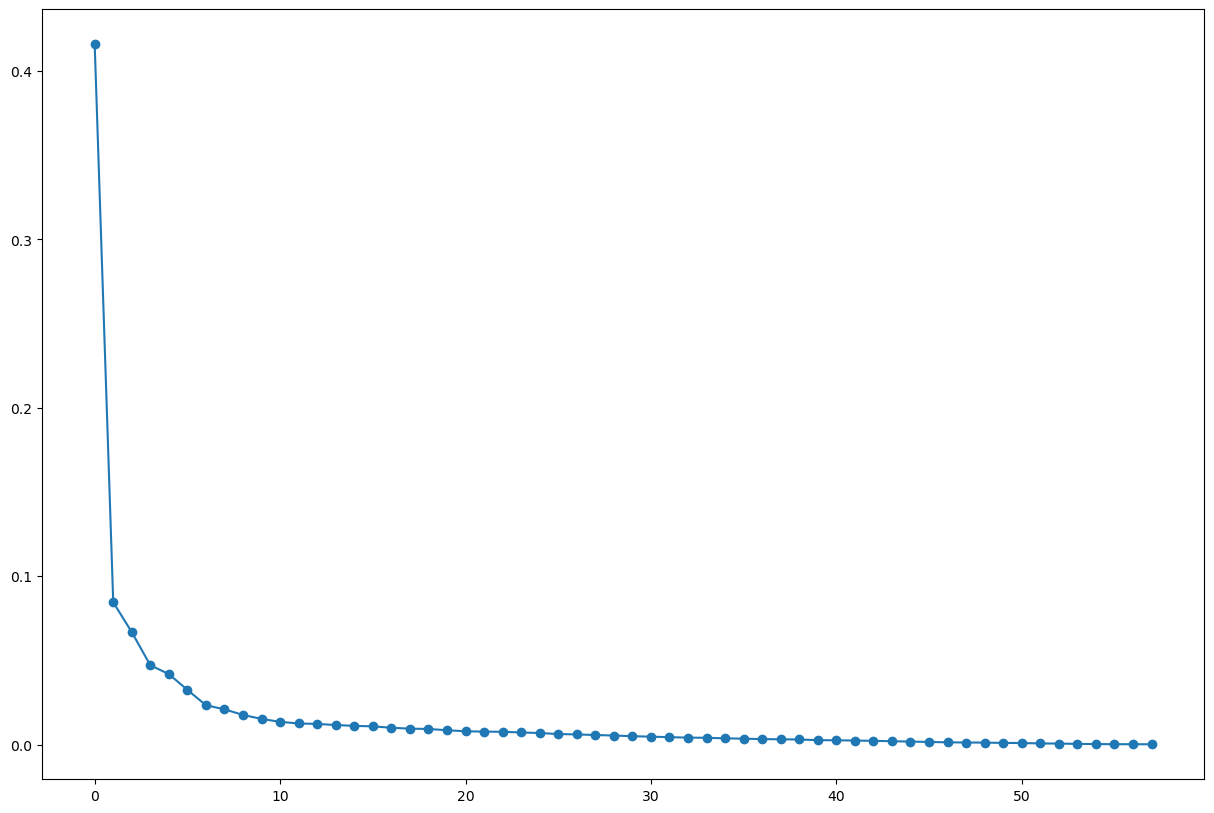

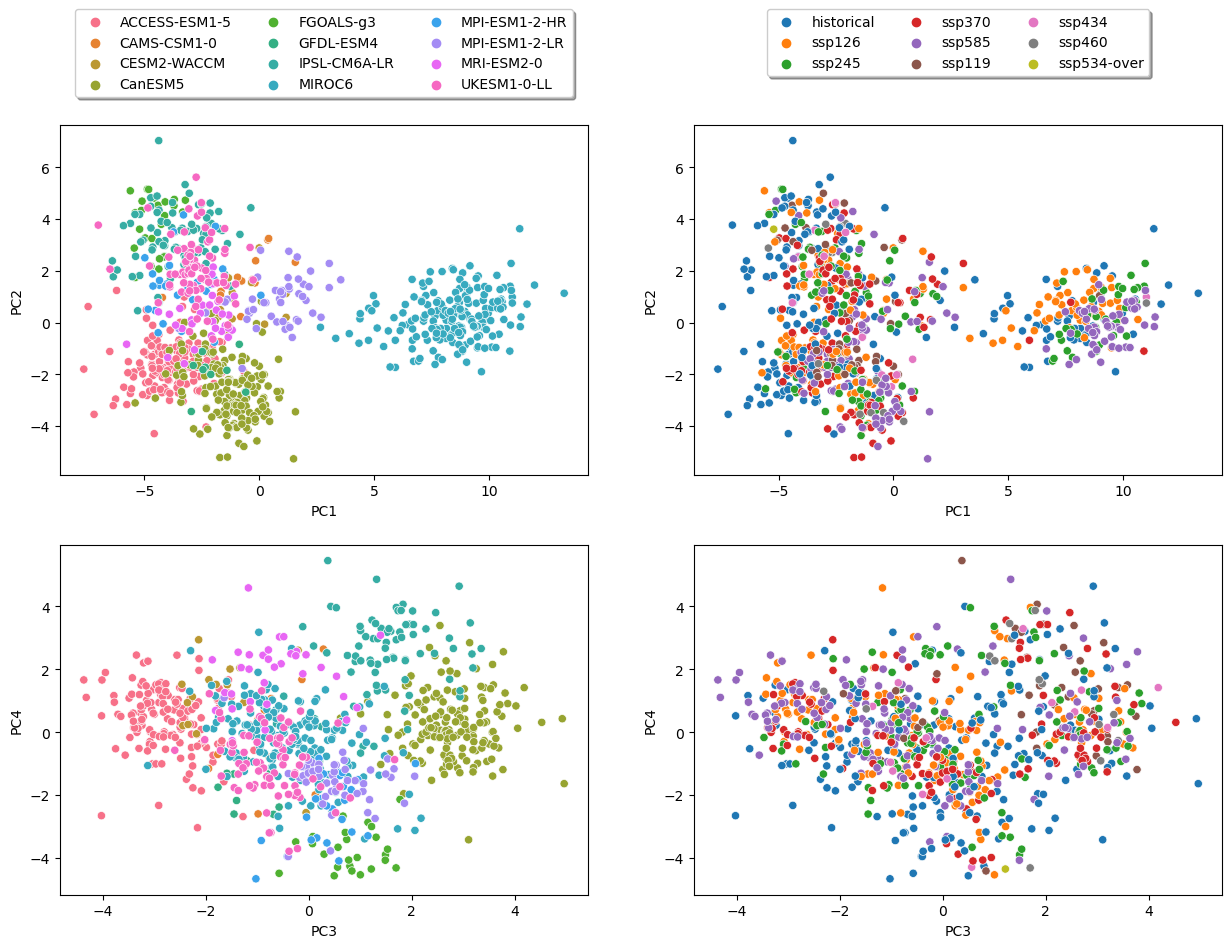

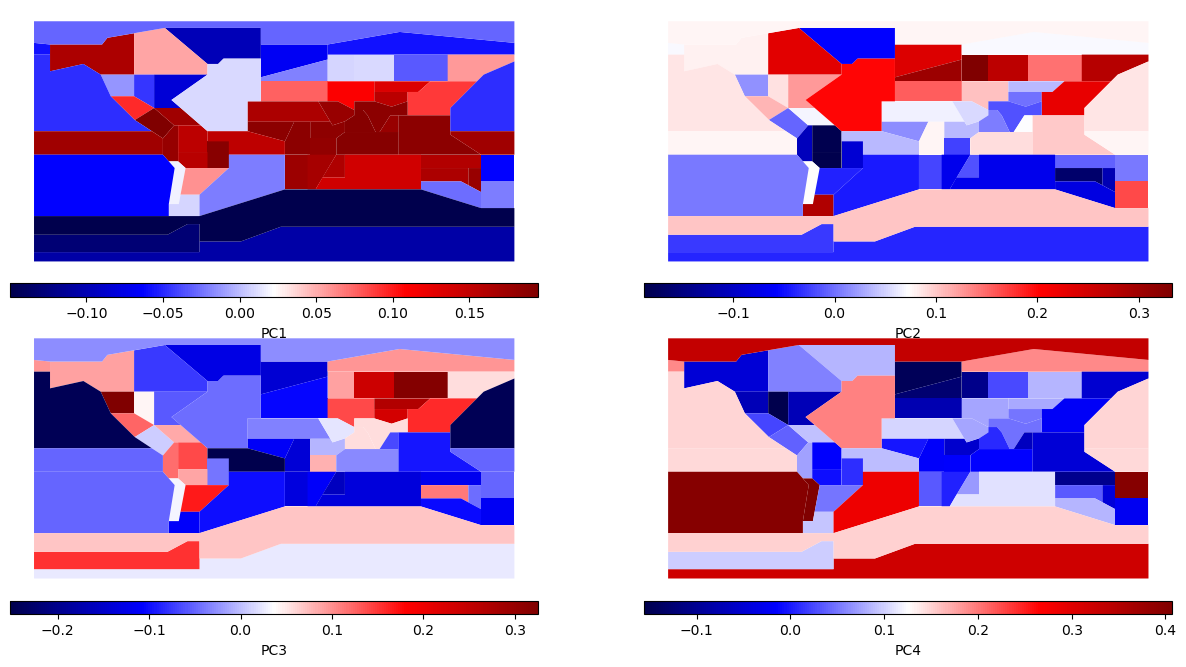

In [ ]:
full_pca, pca, fig1 = my_pca(tas_iasd_wide)

# PCA component plots
fig2 = pca_components_plot(tas_iasd_wide, full_pca)

# PCA by region plot
fig3 = pca_by_region_plot(tas_iasd_wide, pca)

# tas Change with oceans

In [ ]:
def generalized_pca2(file, input_dir, variable, fn, change: bool = True, **kwargs):
    # Read in an format data
    input_data = pd.read_csv(os.path.join(input_dir, file))
    input_data = input_data.drop(columns = ['tas','pr'])
    input_data = input_data[input_data['variable'] == variable].reset_index()
    input = input_data.rename({'value': 'summary_value'})
    input['year'] = pd.to_datetime(input.year, format='%Y')

    # Get summary metric for final period
    summarized = region_summary(input, fn, **kwargs)

    # For change in value from historic to given period
    if change:
        data = summarized
        hist_data = summarized[summarized['experiment'] == 'historical'][['esm', 'ensemble', 'acronym', 'summary_value']]
        hist_data = hist_data.rename(columns = {'summary_value': 'hist_value'})
        merged_data = pd.merge(hist_data, data, how = 'left', left_on = ['esm', 'ensemble', 'acronym'], right_on = ['esm', 'ensemble', 'acronym'])
        merged_data['summary_value'] = merged_data['summary_value'] - merged_data['hist_value']
        summarized = merged_data.loc[:, merged_data.columns != 'hist_value']

    # Get last period
    summarized = summarized[summarized.year == summarized.year.values[-1]]

    # Turn into wide format
    wide = summarized.pivot_table('summary_value', ['esm', 'experiment', 'ensemble', 'variable', 'year'], 'acronym').dropna()

    # PCA
    full_pca, pca, fig1 = my_pca(wide)

    # PCA component plots
    fig2 = pca_components_plot(wide, full_pca)

    # PCA by region plot
    fig3 = pca_by_region_plot(wide, pca)
    return summarized, fig1, fig2, fig3

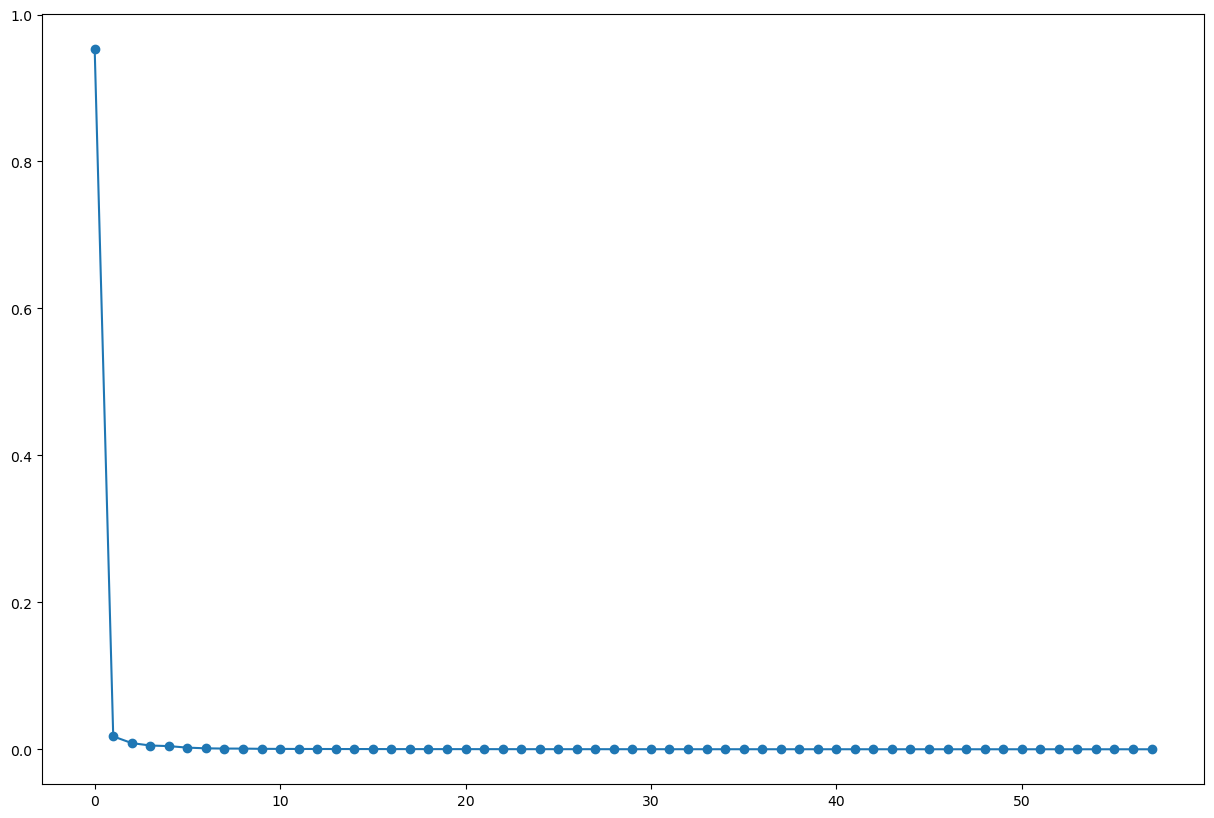

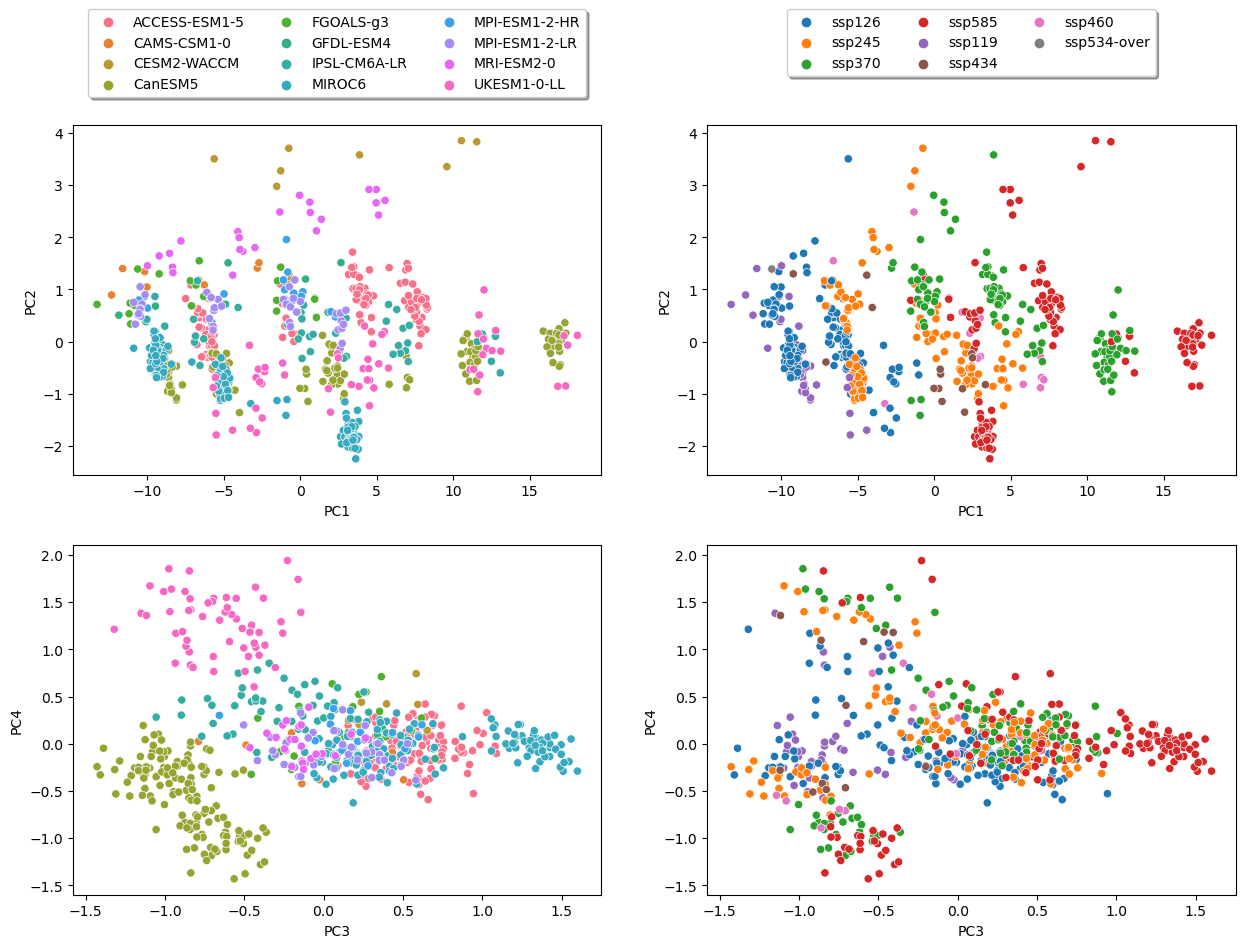

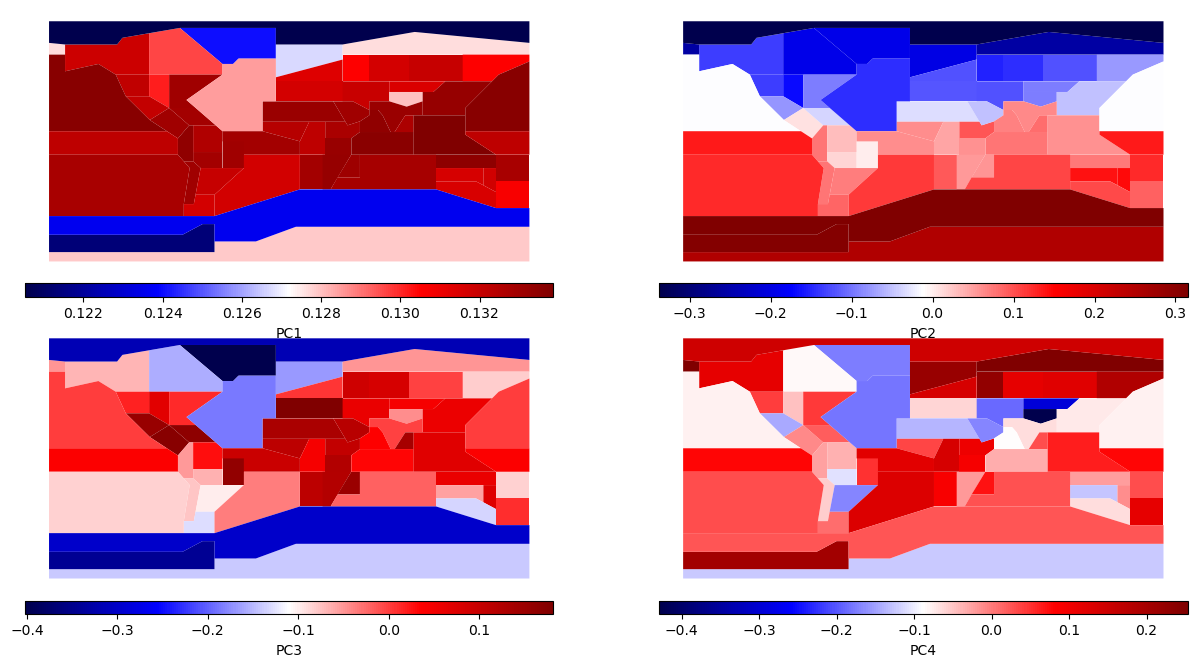

In [ ]:
tas_change, fig1, fig2, fig3 = generalized_pca2(file_name, data_dir, 'tas', np.mean)

# Mean pr with Oceans

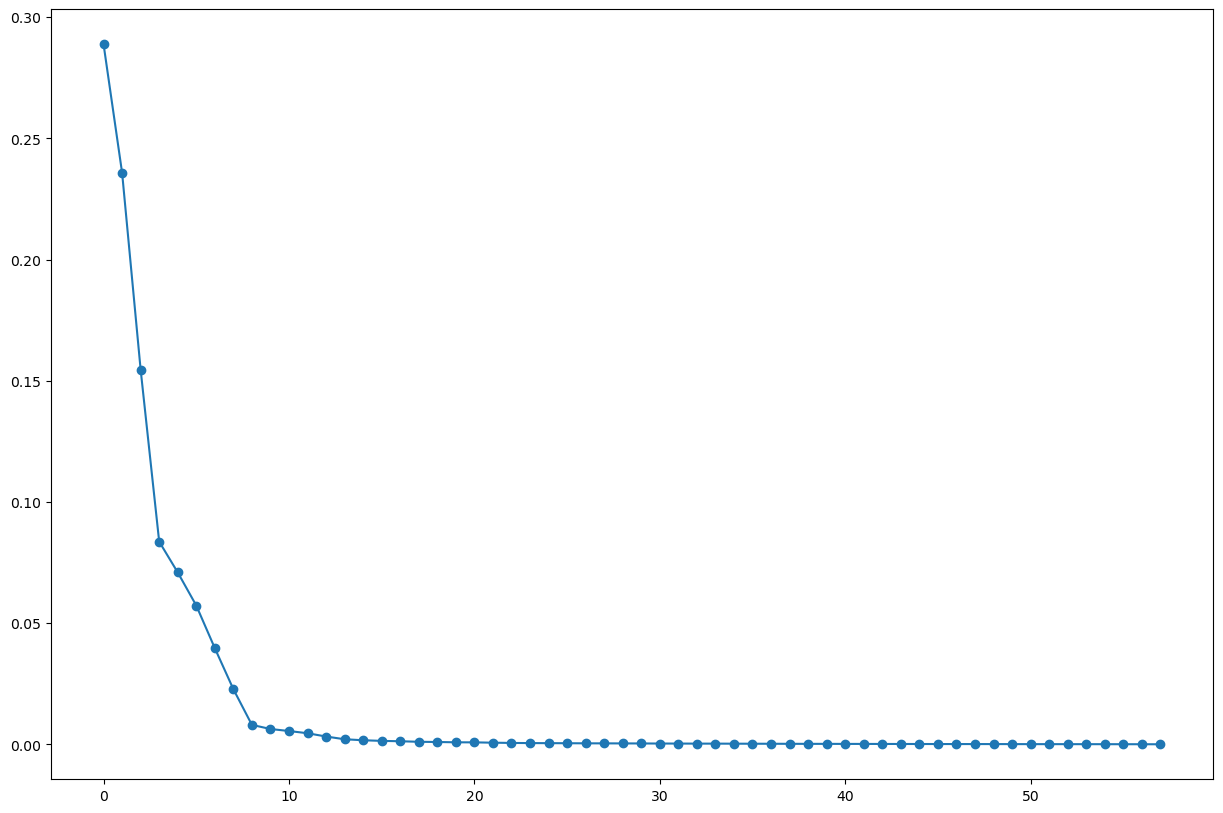

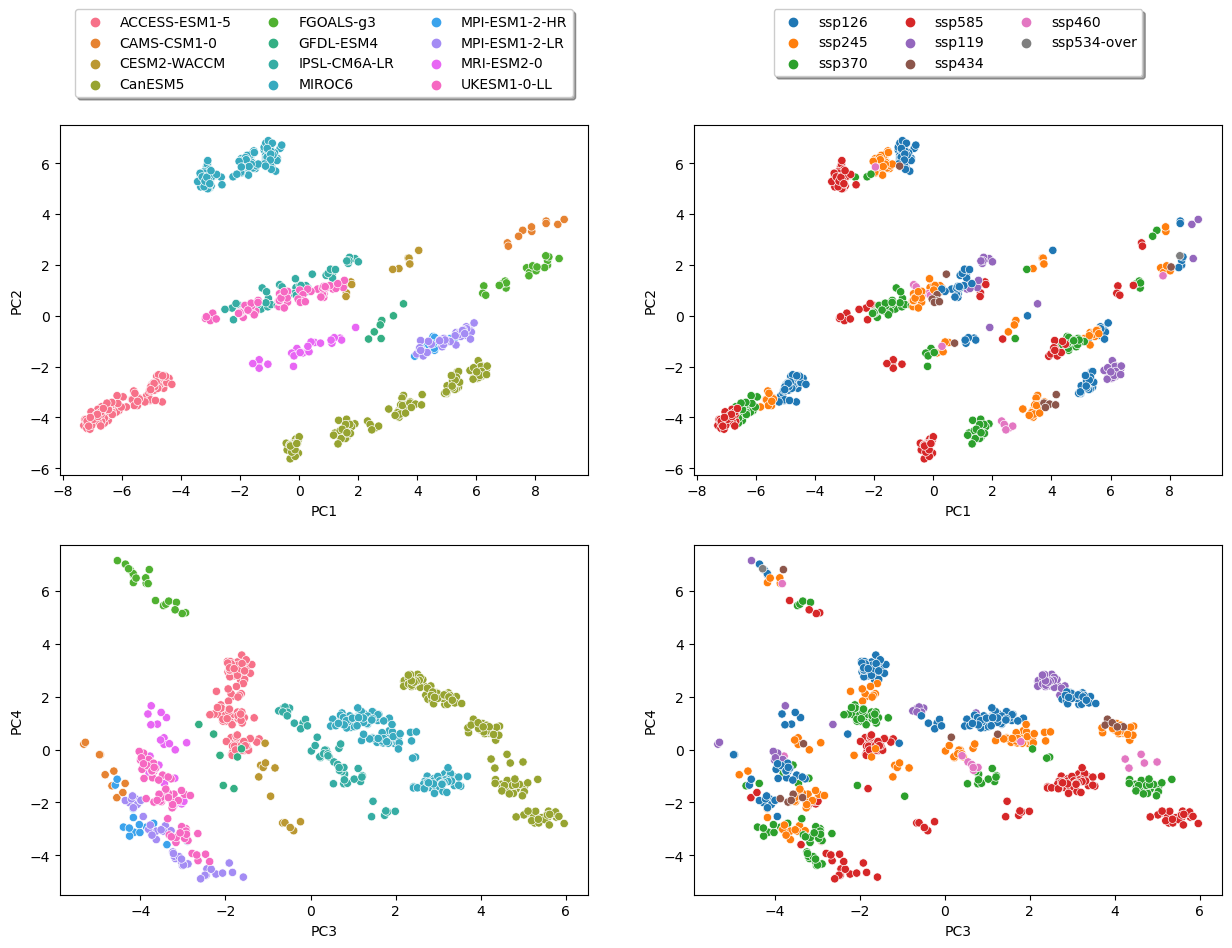

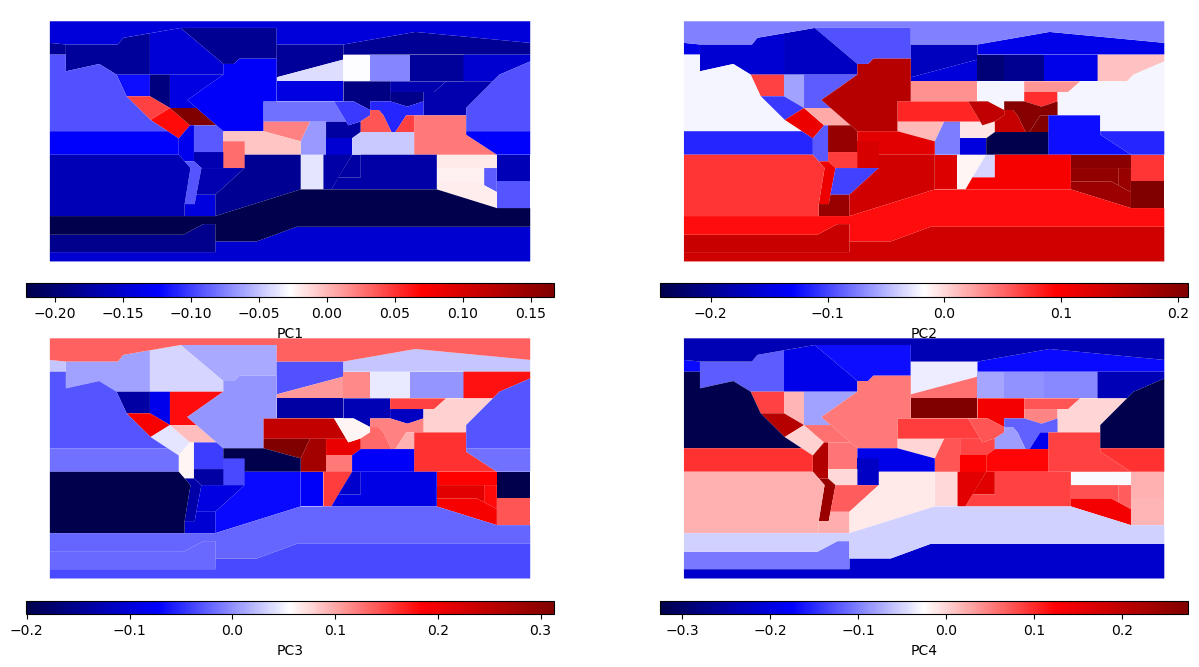

In [ ]:
mean_pr, fig1, fig2, fig3 = generalized_pca2(file_name, data_dir, 'pr', np.mean, change=False)

In [ ]:
mean_pr = mean_pr.drop(['year', 'variable'], axis=1)
mean_pr['acronym'] = mean_pr['acronym'] + '_mean_pr'
mean_pr

esm experiment   ensemble       acronym  summary_value
40024    ACCESS-ESM1-5     ssp126  r10i1p1f1   ARO_mean_pr       0.000013
40029    ACCESS-ESM1-5     ssp126  r10i1p1f1   ARP_mean_pr       0.000003
40034    ACCESS-ESM1-5     ssp126  r10i1p1f1   ARS_mean_pr       0.000015
40039    ACCESS-ESM1-5     ssp126  r10i1p1f1   BOB_mean_pr       0.000035
40044    ACCESS-ESM1-5     ssp126  r10i1p1f1   CAF_mean_pr       0.000056
...                ...        ...        ...           ...            ...
2160479    UKESM1-0-LL     ssp585   r8i1p1f2   WCA_mean_pr       0.000011
2160484    UKESM1-0-LL     ssp585   r8i1p1f2   WCE_mean_pr       0.000021
2160489    UKESM1-0-LL     ssp585   r8i1p1f2   WNA_mean_pr       0.000027
2160494    UKESM1-0-LL     ssp585   r8i1p1f2  WSAF_mean_pr       0.000013
2160499    UKESM1-0-LL     ssp585   r8i1p1f2   WSB_mean_pr       0.000016

[36366 rows x 5 columns]

In [ ]:
tas_change = tas_change.drop(['year', 'variable'], axis=1)
tas_change['acronym'] = tas_change['acronym'] + '_tas_change'
tas_change

esm   ensemble          acronym experiment  summary_value
4       ACCESS-ESM1-5  r10i1p1f1   ARO_tas_change     ssp126       4.226090
8       ACCESS-ESM1-5  r10i1p1f1   ARO_tas_change     ssp585      10.446850
13      ACCESS-ESM1-5  r10i1p1f1   ARP_tas_change     ssp126       2.200130
17      ACCESS-ESM1-5  r10i1p1f1   ARP_tas_change     ssp585       5.168463
22      ACCESS-ESM1-5  r10i1p1f1   ARS_tas_change     ssp126       1.414177
...               ...        ...              ...        ...            ...
154610    UKESM1-0-LL   r9i1p1f2  WSAF_tas_change     ssp245       3.485379
154614    UKESM1-0-LL   r9i1p1f2  WSAF_tas_change     ssp370       4.713365
154619    UKESM1-0-LL   r9i1p1f2   WSB_tas_change     ssp126       4.072419
154623    UKESM1-0-LL   r9i1p1f2   WSB_tas_change     ssp245       5.658540
154627    UKESM1-0-LL   r9i1p1f2   WSB_tas_change     ssp370       7.459805

[35670 rows x 5 columns]

In [ ]:
tas_iasd = tas_iasd.drop(['level_5', 'type', 'name', 'variable'], axis=1)
tas_iasd['acronym'] = tas_iasd['acronym'] + '_tas_iasd'
tas_iasd

esm  experiment   ensemble        acronym      iasd
0      ACCESS-ESM1-5  historical  r10i1p1f1   ARO_tas_iasd  0.581483
1      ACCESS-ESM1-5  historical  r10i1p1f1   ARP_tas_iasd  0.304199
2      ACCESS-ESM1-5  historical  r10i1p1f1   ARS_tas_iasd  0.180148
3      ACCESS-ESM1-5  historical  r10i1p1f1   BOB_tas_iasd  0.120539
4      ACCESS-ESM1-5  historical  r10i1p1f1   CAF_tas_iasd  0.205891
...              ...         ...        ...            ...       ...
48367    UKESM1-0-LL      ssp585   r8i1p1f2   WCA_tas_iasd  0.455292
48368    UKESM1-0-LL      ssp585   r8i1p1f2   WCE_tas_iasd  0.683301
48369    UKESM1-0-LL      ssp585   r8i1p1f2   WNA_tas_iasd  0.460177
48370    UKESM1-0-LL      ssp585   r8i1p1f2  WSAF_tas_iasd  0.269521
48371    UKESM1-0-LL      ssp585   r8i1p1f2   WSB_tas_iasd  0.857713

[48372 rows x 5 columns]

In [ ]:
tas_change_wide = tas_change.pivot_table('summary_value', ['esm', 'experiment', 'ensemble'], 'acronym').dropna().reset_index()
tas_iasd_wide = tas_iasd.pivot_table('iasd', ['esm', 'experiment', 'ensemble'], 'acronym').dropna().reset_index()
mean_pr_wide = mean_pr.pivot_table('summary_value', ['esm', 'experiment', 'ensemble'], 'acronym').dropna().reset_index()
mean_pr_wide

acronym            esm experiment   ensemble  ARO_mean_pr  ARP_mean_pr  \
0        ACCESS-ESM1-5     ssp126  r10i1p1f1     0.000013     0.000003   
1        ACCESS-ESM1-5     ssp126  r11i1p1f1     0.000013     0.000003   
2        ACCESS-ESM1-5     ssp126  r12i1p1f1     0.000014     0.000003   
3        ACCESS-ESM1-5     ssp126  r13i1p1f1     0.000013     0.000003   
4        ACCESS-ESM1-5     ssp126  r14i1p1f1     0.000014     0.000003   
..                 ...        ...        ...          ...          ...   
622        UKESM1-0-LL     ssp585   r1i1p1f2     0.000019     0.000002   
623        UKESM1-0-LL     ssp585   r2i1p1f2     0.000018     0.000002   
624        UKESM1-0-LL     ssp585   r3i1p1f2     0.000018     0.000002   
625        UKESM1-0-LL     ssp585   r4i1p1f2     0.000019     0.000002   
626        UKESM1-0-LL     ssp585   r8i1p1f2     0.000018     0.000002   

acronym  ARS_mean_pr  BOB_mean_pr  CAF_mean_pr  CAR_mean_pr  CAU_mean_pr  ...  \
0           0.000015     0.000035     0.000056     0.000022     0.000011  ...   
1           0.000016     0.000034     0.000057     0.000021     0.000011  ...   
2           0.000016     0.000038     0.000056     0.000022     0.000010  ...   
3           0.000016     0.000035     0.000057     0.000024     0.000012  ...   
4           0.000016     0.000036     0.000056     0.000023     0.000010  ...   
..               ...          ...          ...          ...          ...  ...   
622         0.000019     0.000058     0.000046     0.000021     0.000010  ...   
623         0.000020     0.000062     0.000047     0.000021     0.000011  ...   
624         0.000020     0.000057     0.000047     0.000019     0.000011  ...   
625         0.000022     0.000061     0.000047     0.000022     0.000010  ...   
626         0.000020     0.000059     0.000046     0.000021     0.000011  ...   

acronym  SSA_mean_pr  SWS_mean_pr  TIB_mean_pr  WAF_mean_pr  WAN_mean_pr  \
0           0.000031     0.000023     0.000046     0.000041     0.000019   
1           0.000031     0.000023     0.000045     0.000041     0.000019   
2           0.000031     0.000023     0.000046     0.000042     0.000019   
3           0.000031     0.000023     0.000046     0.000042     0.000019   
4           0.000031     0.000023     0.000046     0.000041     0.000019   
..               ...          ...          ...          ...          ...   
622         0.000028     0.000017     0.000032     0.000034     0.000023   
623         0.000028     0.000017     0.000032     0.000034     0.000023   
624         0.000028     0.000016     0.000033     0.000034     0.000023   
625         0.000028     0.000017     0.000032     0.000035     0.000024   
626         0.000028     0.000017     0.000031     0.000034     0.000023   

acronym  WCA_mean_pr  WCE_mean_pr  WNA_mean_pr  WSAF_mean_pr  WSB_mean_pr  
0           0.000015     0.000029     0.000029      0.000018     0.000019  
1           0.000016     0.000029     0.000029      0.000018     0.000019  
2           0.000016     0.000028     0.000029      0.000018     0.000019  
3           0.000016     0.000028     0.000027      0.000018     0.000020  
4           0.000016     0.000028     0.000029      0.000017     0.000020  
..               ...          ...          ...           ...          ...  
622         0.000011     0.000022     0.000028      0.000014     0.000015  
623         0.000011     0.000022     0.000027      0.000013     0.000016  
624         0.000012     0.000022     0.000027      0.000014     0.000016  
625         0.000011     0.000023     0.000028      0.000013     0.000016  
626         0.000011     0.000021     0.000027      0.000013     0.000016  

[627 rows x 61 columns]

In [ ]:
merged = pd.merge(tas_change_wide, tas_iasd_wide, how = 'inner', left_on = ['esm', 'experiment', 'ensemble'], right_on = ['esm', 'experiment', 'ensemble'])
merged = pd.merge(merged, mean_pr_wide, how = 'inner', left_on = ['esm', 'experiment', 'ensemble'], right_on = ['esm', 'experiment', 'ensemble'])
merged = merged.reset_index().set_index(['esm', 'experiment', 'ensemble']).drop('index', axis=1)
merged

acronym                             ARO_tas_change  ARP_tas_change  \
esm           experiment ensemble                                    
ACCESS-ESM1-5 ssp126     r10i1p1f1        4.226090        2.200130   
                         r11i1p1f1        3.443636        1.836728   
                         r12i1p1f1        5.152386        2.229790   
                         r13i1p1f1        4.549971        2.125275   
                         r14i1p1f1        5.198303        2.152227   
...                                            ...             ...   
UKESM1-0-LL   ssp585     r1i1p1f2        19.460568        6.364176   
                         r2i1p1f2        19.173365        6.523962   
                         r3i1p1f2        18.624047        6.584082   
                         r4i1p1f2        19.376770        6.678129   
                         r8i1p1f2        19.298496        6.529851   

acronym                             ARS_tas_change  BOB_tas_change  \
esm           experiment ensemble                                    
ACCESS-ESM1-5 ssp126     r10i1p1f1        1.414177        1.187370   
                         r11i1p1f1        1.397224        1.033780   
                         r12i1p1f1        1.481383        1.240392   
                         r13i1p1f1        1.478384        1.161521   
                         r14i1p1f1        1.377902        1.256562   
...                                            ...             ...   
UKESM1-0-LL   ssp585     r1i1p1f2         4.370962        4.015329   
                         r2i1p1f2         4.468381        3.997346   
                         r3i1p1f2         4.468153        3.877595   
                         r4i1p1f2         4.538237        3.935599   
                         r8i1p1f2         4.271791        3.812226   

acronym                             CAF_tas_change  CAR_tas_change  \
esm           experiment ensemble                                    
ACCESS-ESM1-5 ssp126     r10i1p1f1        1.605055        1.248377   
                         r11i1p1f1        1.227426        1.063879   
                         r12i1p1f1        1.457825        1.346813   
                         r13i1p1f1        1.435883        1.293761   
                         r14i1p1f1        1.430925        1.240462   
...                                            ...             ...   
UKESM1-0-LL   ssp585     r1i1p1f2         5.797717        4.041723   
                         r2i1p1f2         6.016834        4.002007   
                         r3i1p1f2         5.957453        3.908696   
                         r4i1p1f2         5.847583        4.148062   
                         r8i1p1f2         5.812013        3.943413   

acronym                             CAU_tas_change  CNA_tas_change  \
esm           experiment ensemble                                    
ACCESS-ESM1-5 ssp126     r10i1p1f1        1.504568        2.219598   
                         r11i1p1f1        1.152009        1.860743   
                         r12i1p1f1        1.241476        2.148281   
                         r13i1p1f1        1.472016        2.035836   
                         r14i1p1f1        1.242733        2.169671   
...                                            ...             ...   
UKESM1-0-LL   ssp585     r1i1p1f2         5.857586        7.785310   
                         r2i1p1f2         6.120460        7.660443   
                         r3i1p1f2         5.933621        7.360334   
                         r4i1p1f2         6.069233        7.033442   
                         r8i1p1f2         5.865086        7.334244   

acronym                             EAN_tas_change  EAO_tas_change  ...  \
esm           experiment ensemble                                   ...   
ACCESS-ESM1-5 ssp126     r10i1p1f1        0.876279        1.035830  ...   
                         r11i1p1f1        0.889368        0.879519  ...   
                         r12i1p1f1        0.705877      

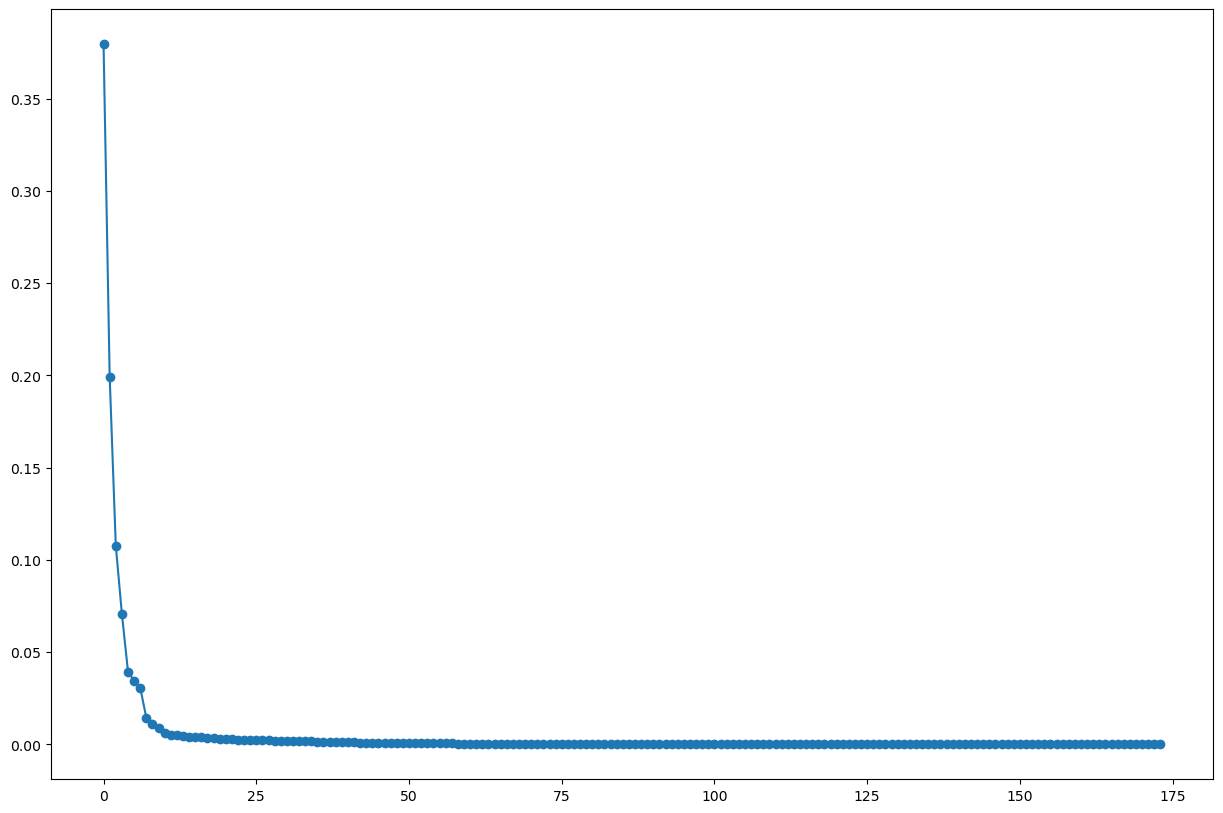

In [ ]:
full_pca, pca, fig1 = my_pca(merged)

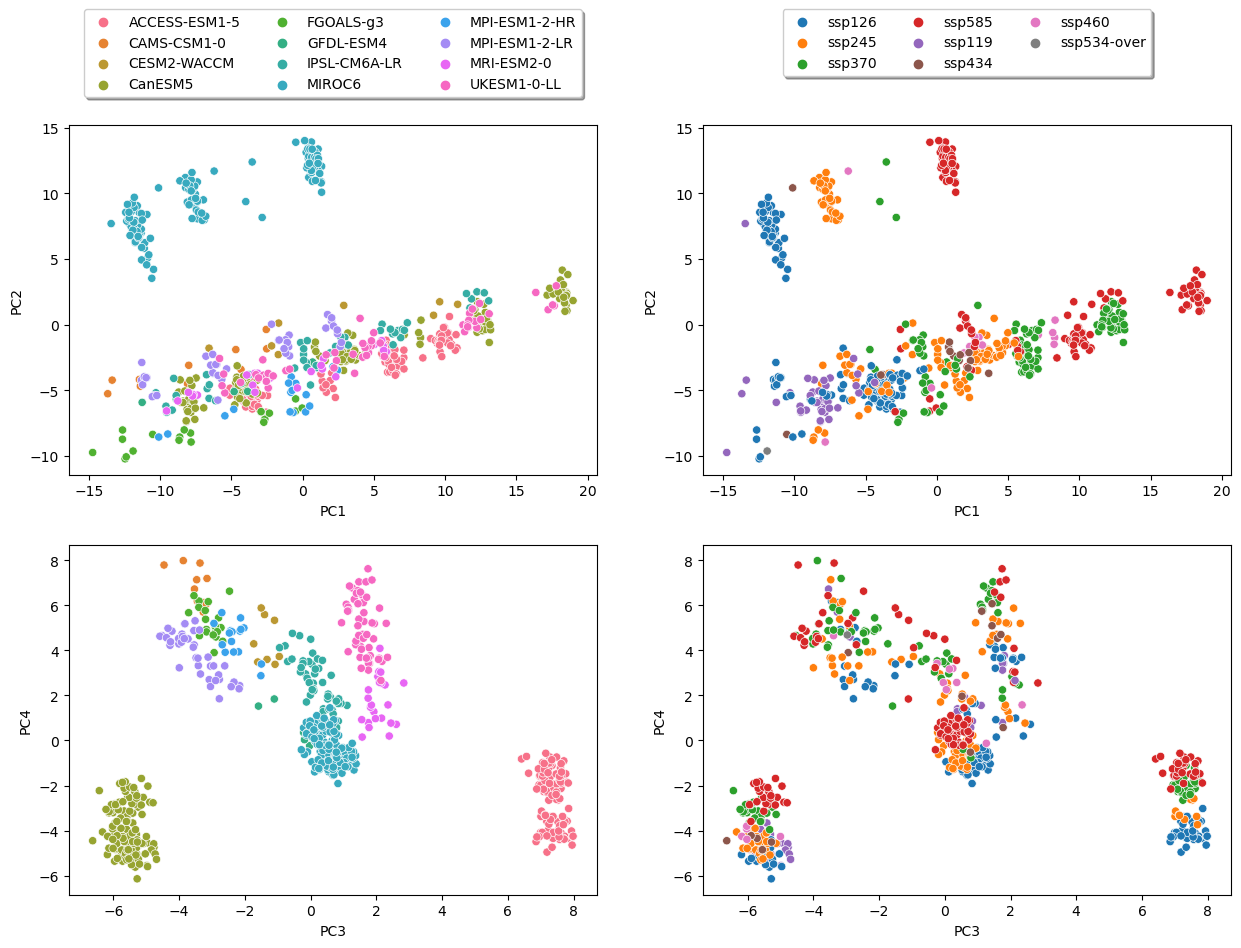

In [ ]:
fig2 = pca_components_plot(merged, full_pca)

In [ ]:
import re

In [ ]:
columns = [x for x in merged.columns.values if '_tas_change' in x]
tas_change_pc1 = pca.components_[0, ['_tas_change' in x for x in merged.columns.values]]
tas_change_pc2 = pca.components_[1, ['_tas_change' in x for x in merged.columns.values]]
tas_change_regions = [re.sub('_tas_change', '', x) for x in columns]
tas_change_pc_df = pd.DataFrame({
        'region': tas_change_regions,
        'PC1': np.transpose(100*tas_change_pc1**3),
        'PC2': np.transpose(100*tas_change_pc2**3)
})

columns = [x for x in merged.columns.values if '_tas_iasd' in x]
tas_iasd_pc1 = pca.components_[0, ['_tas_iasd' in x for x in merged.columns.values]]
tas_iasd_pc2 = pca.components_[1, ['_tas_iasd' in x for x in merged.columns.values]]
tas_iasd_regions = [re.sub('_tas_iasd', '', x) for x in columns]
tas_iasd_pc_df = pd.DataFrame({
        'region': tas_change_regions,
        'PC1': np.transpose(100*tas_iasd_pc1**3),
        'PC2': np.transpose(100*tas_iasd_pc2**3)
})

columns = [x for x in merged.columns.values if '_mean_pr' in x]
mean_pr_pc1 = pca.components_[0, ['_mean_pr' in x for x in merged.columns.values]]
mean_pr_pc2 = pca.components_[1, ['_mean_pr' in x for x in merged.columns.values]]
mean_pr_regions = [re.sub('_mean_pr', '', x) for x in columns]
mean_pr_pc_df = pd.DataFrame({
        'region': mean_pr_regions,
        'PC1': np.transpose(100*mean_pr_pc1**3),
        'PC2': np.transpose(100*mean_pr_pc2**3)
})

* Row 1: tas change (last period - historical)
* Row 2: tas iasd
* Row 3: mean pr (last period)

Component loadings cubed and scaled by 100 for viewing and exaggeration of importance

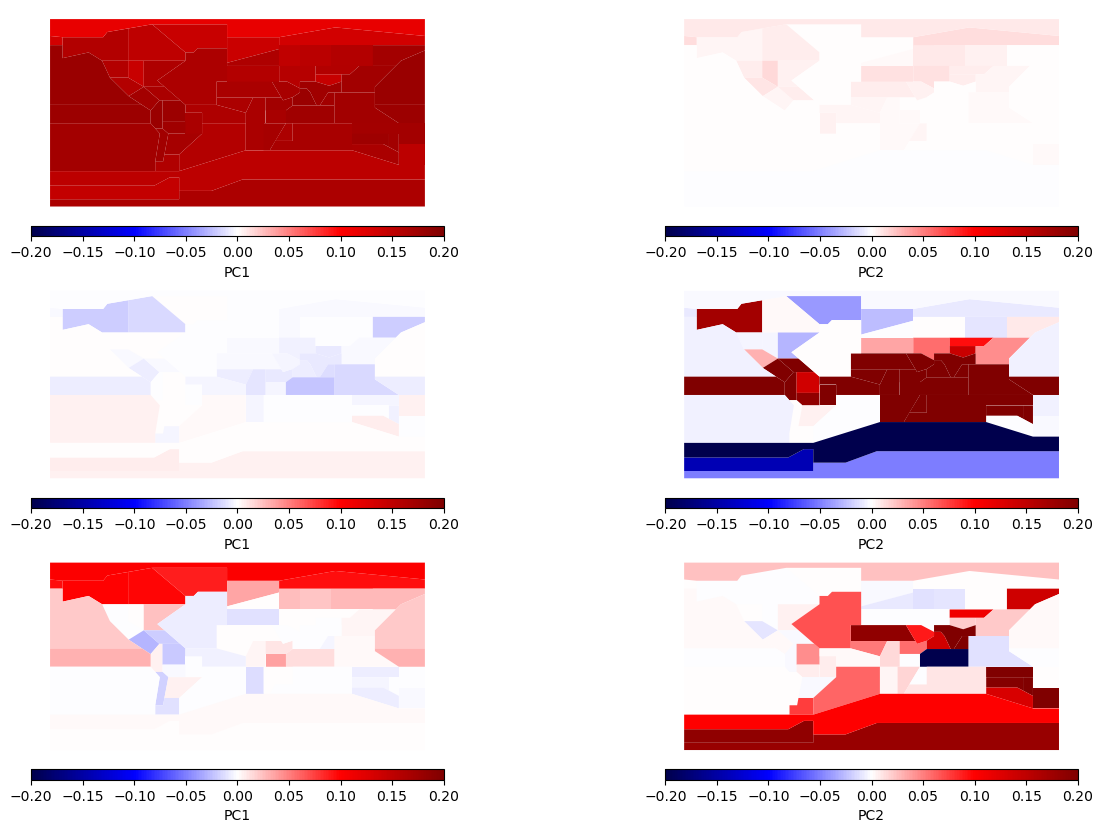

In [ ]:
land_data = pd.merge(land_main_gdf, tas_change_pc_df, left_on='Acronym', right_on='region', how='inner')

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))

vmin = -0.2
vmax = 0.2

component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

land_data = pd.merge(land_main_gdf, tas_iasd_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.2)

land_data = pd.merge(land_main_gdf, mean_pr_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes("bottom", size="5%", pad=0.1)
ax5.set_axis_off()
land_data.plot(ax=ax5, column=component, cmap='seismic', legend=True, cax=cax5,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes("bottom", size="5%", pad=0.1)
ax6.set_axis_off()
land_data.plot(ax=ax6, column=component, cmap='seismic', legend=True, cax=cax6,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

In [ ]:
def pca_components_plot(wide_data, pca_output):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

    sns.scatterplot(ax=ax1, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax2, x=pca_output[:,0], y=pca_output[:,1], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
               ncol=3, fancybox=True, shadow=True)
    ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

    sns.scatterplot(ax=ax3, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][0] for i in range(wide_data.shape[0])])
    ax3.legend_ = None
    ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    sns.scatterplot(ax=ax4, x=pca_output[:,2], y=pca_output[:,3], hue=[wide_data.index[i][1] for i in range(wide_data.shape[0])])
    ax4.legend_ = None
    ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

    return fig

In [ ]:
pca_df = pd.concat([merged.reset_index()[['esm', 'experiment', 'ensemble']], pd.DataFrame(full_pca)], axis=1)
pca_df

esm experiment   ensemble          0         1         2  \
0    ACCESS-ESM1-5     ssp126  r10i1p1f1  -3.654124 -5.650719  7.389782   
1    ACCESS-ESM1-5     ssp126  r11i1p1f1  -5.124894 -5.370040  7.818618   
2    ACCESS-ESM1-5     ssp126  r12i1p1f1  -3.212669 -5.738539  7.934081   
3    ACCESS-ESM1-5     ssp126  r13i1p1f1  -3.650118 -5.290603  7.346369   
4    ACCESS-ESM1-5     ssp126  r14i1p1f1  -3.569352 -5.889696  7.655966   
..             ...        ...        ...        ...       ...       ...   
604    UKESM1-0-LL     ssp585   r1i1p1f2  17.653212  1.439194  1.704062   
605    UKESM1-0-LL     ssp585   r2i1p1f2  17.796369  2.953985  1.513350   
606    UKESM1-0-LL     ssp585   r3i1p1f2  17.223058  1.138332  1.682570   
607    UKESM1-0-LL     ssp585   r4i1p1f2  17.541200  1.499824  1.864720   
608    UKESM1-0-LL     ssp585   r8i1p1f2  16.358136  2.449926  1.743843   

            3         4         5         6  ...       164       165  \
0   -3.422462 -0.675422 -0.015452 -0.115629  ... -0.046394  0.006588   
1   -4.338006 -0.255188 -0.040186 -0.608790  ...  0.015009  0.003654   
2   -4.018758  0.257936  0.216188  0.501630  ... -0.015700  0.015866   
3   -4.323267 -0.654797  0.233525  0.897796  ... -0.018512  0.000864   
4   -3.534655 -0.444617  0.449400  0.993769  ...  0.039311 -0.020339   
..        ...       ...       ...       ...  ...       ...       ...   
604  6.356611 -0.372454 -0.440642  5.811767  ... -0.019384  0.027035   
605  6.585996 -0.405079 -0.201107  4.137353  ... -0.011858  0.012483   
606  7.039351  0.252706  0.129010  5.349408  ...  0.003469 -0.009117   
607  7.123233  0.150577 -0.728593  5.296382  ... -0.045810  0.048948   
608  7.619965  0.759892 -1.458669  5.309815  ... -0.005394  0.037065   

          166       167       168       169       170       171       172  \
0   -0.008914  0.041739 -0.023906 -0.023226  0.003058 -0.007330 -0.022778   
1   -0.005768 -0.014520 -0.011541  0.008129  0.031364 -0.034691  0.020413   
2    0.020328  0.032094  0.028437  0.020300  0.009409 -0.016714 -0.003949   
3    0.006305  0.007112 -0.037716  0.024782  0.013490 -0.004059  0.005661   
4   -0.033128 -0.008818  0.015301 -0.016428 -0.024634 -0.018738  0.010329   
..        ...       ...       ...       ...       ...       ...       ...   
604  0.037564  0.008824  0.013224  0.013270 -0.004689  0.003999  0.027552   
605 -0.028342 -0.019658  0.012946 -0.011273 -0.017519  0.010759  0.000184   
606  0.026270 -0.012725 -0.006132 -0.038417 -0.006032  0.008027  0.003848   
607 -0.001601  0.011147  0.022950  0.007517  0.001755  0.029926 -0.011354   
608  0.024573  0.012814  0.005105  0.009055  0.002298  0.003399 -0.004558   

          173  
0   -0.001049  
1    0.017620  
2    0.015349  
3   -0.005937  
4   -0.017052  
..        ...  
604 -0.011121  
605  0.003793  
606 -0.033228  
607 -0.010807  
608 -0.000601  

[609 rows x 177 columns]

In [ ]:
pd.melt(pca_df, id_vars = ['esm', 'experiment', 'ensemble'])

esm experiment   ensemble variable     value
0       ACCESS-ESM1-5     ssp126  r10i1p1f1        0 -3.654124
1       ACCESS-ESM1-5     ssp126  r11i1p1f1        0 -5.124894
2       ACCESS-ESM1-5     ssp126  r12i1p1f1        0 -3.212669
3       ACCESS-ESM1-5     ssp126  r13i1p1f1        0 -3.650118
4       ACCESS-ESM1-5     ssp126  r14i1p1f1        0 -3.569352
...               ...        ...        ...      ...       ...
105961    UKESM1-0-LL     ssp585   r1i1p1f2      173 -0.011121
105962    UKESM1-0-LL     ssp585   r2i1p1f2      173  0.003793
105963    UKESM1-0-LL     ssp585   r3i1p1f2      173 -0.033228
105964    UKESM1-0-LL     ssp585   r4i1p1f2      173 -0.010807
105965    UKESM1-0-LL     ssp585   r8i1p1f2      173 -0.000601

[105966 rows x 5 columns]

# Full Data PCA

In [66]:
metric_data_path = '/Users/prim232/gitrepos/stitches_in_r/R/inst/shinyApp/python_curation/extracted_timeseries/extracted_metrics'
file_name = 'IPCC_land_regions_metrics.csv'

In [67]:
full_data = pd.read_csv(os.path.join(metric_data_path, file_name))
full_data

esm experiment  ensemble variable        type  \
0       ACCESS-CM2     ssp126  r1i1p1f1       pr        Land   
1       ACCESS-CM2     ssp126  r1i1p1f1       pr        Land   
2       ACCESS-CM2     ssp126  r1i1p1f1       pr  Land-Ocean   
3       ACCESS-CM2     ssp126  r1i1p1f1       pr        Land   
4       ACCESS-CM2     ssp126  r1i1p1f1       pr        Land   
...            ...        ...       ...      ...         ...   
62560  UKESM1-0-LL     ssp585  r8i1p1f2      tas        Land   
62561  UKESM1-0-LL     ssp585  r8i1p1f2      tas        Land   
62562  UKESM1-0-LL     ssp585  r8i1p1f2      tas        Land   
62563  UKESM1-0-LL     ssp585  r8i1p1f2      tas        Land   
62564  UKESM1-0-LL     ssp585  r8i1p1f2      tas        Land   

                      name acronym          iasd     end_val   end_anomaly  \
0        Arabian-Peninsula     ARP  7.227917e-07    0.000002  4.306991e-07   
1           Central-Africa     CAF  3.009324e-06    0.000048 -4.965491e-08   
2                Caribbean     CAR  6.106140e-06    0.000031  2.089845e-07   
3              C.Australia     CAU  2.830779e-06    0.000011 -1.269868e-06   
4          C.North-America     CNA  2.861294e-06    0.000032  1.953880e-06   
...                    ...     ...           ...         ...           ...   
62560             W.C.Asia     WCA  4.762042e-01  295.272703  7.437846e+00   
62561  West&Central-Europe     WCE  7.458560e-01  288.723746  7.920913e+00   
62562      W.North-America     WNA  4.797180e-01  288.707498  7.960485e+00   
62563    W.Southern-Africa    WSAF  2.955758e-01  299.555257  5.712152e+00   
62564            W.Siberia     WSB  8.362131e-01  284.381495  1.032120e+01   

       end_anomaly_pct  mid_century_val   mid_anomaly  mid_anomaly_pct  
0             0.339153         0.000002  7.818446e-07         0.615662  
1            -0.001027         0.000049  1.080502e-06         0.022357  
2             0.006893         0.000034  3.972086e-06         0.131011  
3            -0.100986         0.000011 -1.311461e-06        -0.104294  
4             0.064341         0.000032  1.857811e-06         0.061177  
...                ...              ...           ...              ...  
62560         0.025841       291.089772  3.254915e+00         0.011308  
62561         0.028208       284.514016  3.711183e+00         0.013216  
62562         0.028355       284.675132  3.928119e+00         0.013992  
62563         0.019439       296.177679  2.334574e+00         0.007945  
62564         0.037660       278.397133  4.336842e+00         0.015824  

[62565 rows x 14 columns]

In [68]:
full_data_wide = full_data.pivot_table(['iasd', 
                                        'end_val', 'end_anomaly', 'end_anomaly_pct', 
                                        'mid_century_val', 'mid_anomaly', 'mid_anomaly_pct'], ['esm', 'experiment', 'ensemble'], ['variable', 'acronym']).dropna().reset_index()
full_data_wide.columns = full_data_wide.columns.map(' | '.join).str.strip(' | ')
full_data_wide = full_data_wide.reset_index().set_index(['esm', 'experiment', 'ensemble']).drop('index', axis=1)
full_data_wide

end_anomaly | pr | ARP  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1            4.306991e-07   
                       r2i1p1f1            1.514477e-07   
                       r3i1p1f1           -1.059955e-08   
                       r4i1p1f1            5.706031e-07   
                       r5i1p1f1            3.111911e-07   
...                                                 ...   
UKESM1-0-LL ssp585     r1i1p1f2            1.411554e-06   
                       r2i1p1f2            1.314745e-06   
                       r3i1p1f2            1.063902e-06   
                       r4i1p1f2            1.389193e-06   
                       r8i1p1f2            1.159691e-06   

                                 end_anomaly | pr | CAF  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1           -4.965491e-08   
                       r2i1p1f1            1.308918e-06   
                       r3i1p1f1            1.129125e-06   
                       r4i1p1f1            1.453681e-06   
                       r5i1p1f1            2.016725e-06   
...                                                 ...   
UKESM1-0-LL ssp585     r1i1p1f2            5.932713e-06   
                       r2i1p1f2            4.210026e-06   
                       r3i1p1f2            5.738592e-06   
                       r4i1p1f2            5.763121e-06   
                       r8i1p1f2            4.496602e-06   

                                 end_anomaly | pr | CAR  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1            2.089845e-07   
                       r2i1p1f1            4.300420e-06   
                       r3i1p1f1            3.627249e-06   
                       r4i1p1f1            1.634963e-06   
                       r5i1p1f1            4.959839e-06   
...                                                 ...   
UKESM1-0-LL ssp585     r1i1p1f2           -8.261231e-06   
                       r2i1p1f2           -9.688586e-06   
                       r3i1p1f2           -1.085236e-05   
                       r4i1p1f2           -7.193932e-06   
                       r8i1p1f2           -8.135973e-06   

                                 end_anomaly | pr | CAU  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1           -1.269868e-06   
                       r2i1p1f1           -2.331859e-07   
                       r3i1p1f1           -5.135553e-07   
                       r4i1p1f1           -1.154792e-06   
                       r5i1p1f1            1.321649e-06   
...                                                 ...   
UKESM1-0-LL ssp585     r1i1p1f2           -6.153729e-08   
                       r2i1p1f2            1.846227e-07   
                       r3i1p1f2           -1.744726e-06   
                       r4i1p1f2           -2.519904e-06   
                       r8i1p1f2           -3.207764e-07   

                                 end_anomaly | pr | CNA  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1            1.953880e-06   
                       r2i1p1f1           -1.103793e-06   
                       r3i1p1f1            1.395900e-06   
                       r4i1p1f1            2.652321e-06   
                       r5i1p1f1            5.540399e-08   
...                                                 ...   
UKESM1-0-LL ssp585     r1i1p1f2            2.194087e-06   
                       r2i1p1f2            2.409071e-06   
                       r3i1p1f2            1.236579e-06   
                       r4i1p1f2            3.935529e-06   
                       r8i1p1f2            2.731521e-06   

                                 end_anomaly | pr | EAS  \
esm         experiment ensemble                           
ACCESS-CM2  ssp126     r1i1p1f1                0.000006   
                

# All Metrics 
(using the end time period and not including both pct and anomaly (so not really all metrics (but all the ones I think make the most sense)))

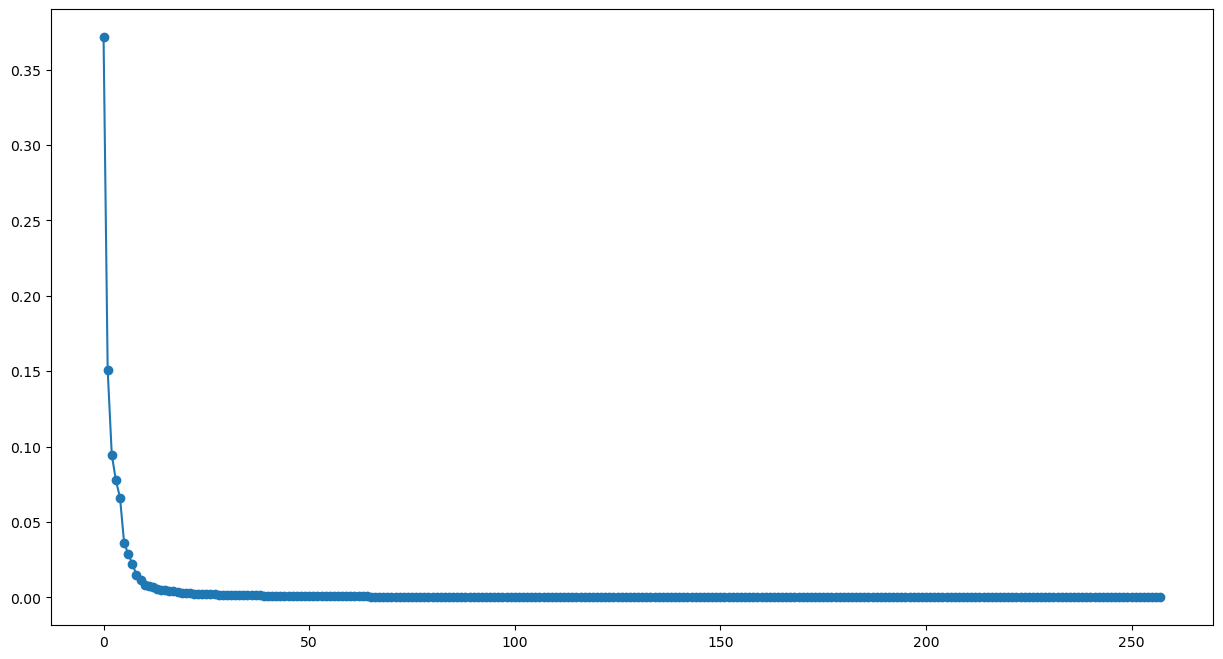

In [69]:
end_columns = [x for x in full_data_wide.columns.values if ('pct' not in x) and (('end' in x) or ('iasd' in x))]
scaler = StandardScaler()
scaler.fit(full_data_wide[end_columns])
fw_scaled = scaler.transform(full_data_wide[end_columns])  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

[Text(0.5, 0, 'PC7'), Text(0, 0.5, 'PC8')]

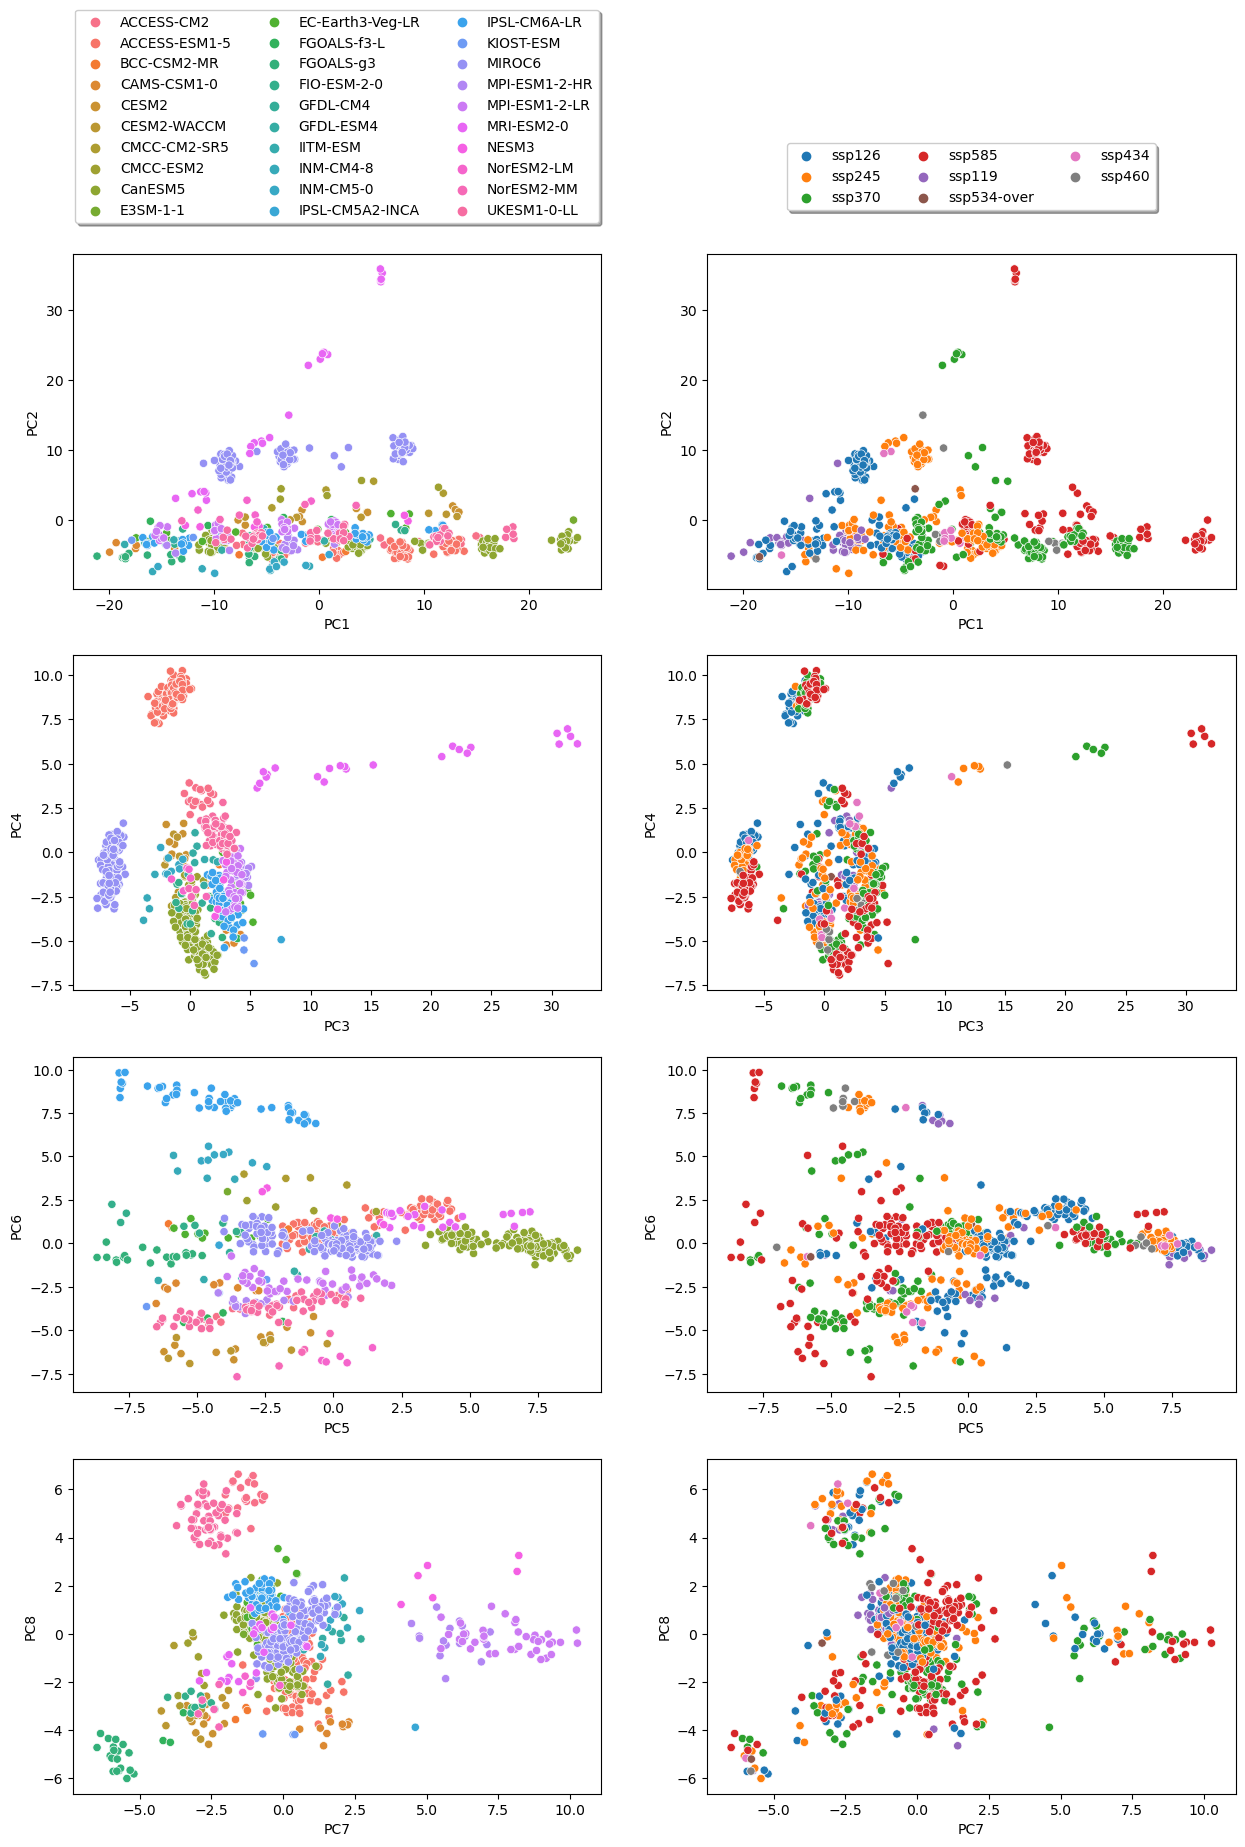

In [70]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(15,20))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[end_columns].index[i][0] for i in range(full_data_wide[end_columns].shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.75),
            ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[end_columns].index[i][1] for i in range(full_data_wide[end_columns].shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
            ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[end_columns].index[i][0] for i in range(full_data_wide[end_columns].shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[end_columns].index[i][1] for i in range(full_data_wide[end_columns].shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax5, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[end_columns].index[i][0] for i in range(full_data_wide[end_columns].shape[0])])
ax5.legend_ = None
ax5.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

sns.scatterplot(ax=ax6, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[end_columns].index[i][1] for i in range(full_data_wide[end_columns].shape[0])])
ax6.legend_ = None
ax6.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

sns.scatterplot(ax=ax7, x=full_pca[:,6], y=full_pca[:,7], hue=[full_data_wide[end_columns].index[i][0] for i in range(full_data_wide[end_columns].shape[0])])
ax7.legend_ = None
ax7.set(xlabel="PC{}".format(7), ylabel="PC{}".format(8))

sns.scatterplot(ax=ax8, x=full_pca[:,6], y=full_pca[:,7], hue=[full_data_wide[end_columns].index[i][1] for i in range(full_data_wide[end_columns].shape[0])])
ax8.legend_ = None
ax8.set(xlabel="PC{}".format(7), ylabel="PC{}".format(8))

In [71]:
# MEAN TAS FUTURE YEARS
columns = [x for x in full_data_wide[end_columns].columns.values if 'end_val | tas' in x]
mean_tas_pc1 = pca.components_[0, ['end_val | tas' in x for x in full_data_wide[end_columns].columns.values]]
mean_tas_pc2 = pca.components_[1, ['end_val | tas' in x for x in full_data_wide[end_columns].columns.values]]
mean_tas_pc3 = pca.components_[2, ['end_val | tas' in x for x in full_data_wide[end_columns].columns.values]]
mean_tas_pc4 = pca.components_[3, ['end_val | tas' in x for x in full_data_wide[end_columns].columns.values]]
mean_tas_pc5 = pca.components_[4, ['end_val | tas' in x for x in full_data_wide[end_columns].columns.values]]
mean_tas_regions = [re.sub('end_val | tas | ', '', x).strip('|') for x in columns]
mean_tas_pc_df = pd.DataFrame({
        'region': mean_tas_regions,
        'PC1': np.transpose(100*mean_tas_pc1**3),
        'PC2': np.transpose(100*mean_tas_pc2**3),
        'PC3': np.transpose(100*mean_tas_pc3**3),
        'PC4': np.transpose(100*mean_tas_pc4**3),
        'PC5': np.transpose(100*mean_tas_pc5**3)
})

# TAS ANOMALY
columns = [x for x in full_data_wide[end_columns].columns.values if 'end_anomaly | tas' in x]
tas_anomaly_pc1 = pca.components_[0, ['end_anomaly | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_anomaly_pc2 = pca.components_[1, ['end_anomaly | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_anomaly_pc3 = pca.components_[2, ['end_anomaly | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_anomaly_pc4 = pca.components_[3, ['end_anomaly | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_anomaly_pc5 = pca.components_[4, ['end_anomaly | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_anomaly_regions = [re.sub('end_anomaly | tas | ', '', x).strip('|') for x in columns]
tas_anomaly_pc_df = pd.DataFrame({
        'region': tas_anomaly_regions,
        'PC1': np.transpose(100*tas_anomaly_pc1**3),
        'PC2': np.transpose(100*tas_anomaly_pc2**3),
        'PC3': np.transpose(100*tas_anomaly_pc3**3),
        'PC4': np.transpose(100*tas_anomaly_pc4**3),
        'PC5': np.transpose(100*tas_anomaly_pc5**3)
})

# TAS IASD
columns = [x for x in full_data_wide[end_columns].columns.values if 'iasd | tas' in x]
tas_iasd_pc1 = pca.components_[0, ['iasd | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_iasd_pc2 = pca.components_[1, ['iasd | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_iasd_pc3 = pca.components_[2, ['iasd | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_iasd_pc4 = pca.components_[3, ['iasd | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_iasd_pc5 = pca.components_[4, ['iasd | tas' in x for x in full_data_wide[end_columns].columns.values]]
tas_iasd_regions = [re.sub('iasd | tas | ', '', x).strip('|') for x in columns]
tas_iasd_pc_df = pd.DataFrame({
        'region': tas_iasd_regions,
        'PC1': np.transpose(100*tas_iasd_pc1**3),
        'PC2': np.transpose(100*tas_iasd_pc2**3),
        'PC3': np.transpose(100*tas_iasd_pc3**3),
        'PC4': np.transpose(100*tas_iasd_pc4**3),
        'PC5': np.transpose(100*tas_iasd_pc5**3)
})

# MEAN PR
columns = [x for x in full_data_wide[end_columns].columns.values if 'end_val | pr' in x]
mean_pr_pc1 = pca.components_[0, ['end_val | pr' in x for x in full_data_wide[end_columns].columns.values]]
mean_pr_pc2 = pca.components_[1, ['end_val | pr' in x for x in full_data_wide[end_columns].columns.values]]
mean_pr_pc3 = pca.components_[2, ['end_val | pr' in x for x in full_data_wide[end_columns].columns.values]]
mean_pr_pc4 = pca.components_[3, ['end_val | pr' in x for x in full_data_wide[end_columns].columns.values]]
mean_pr_pc5 = pca.components_[4, ['end_val | pr' in x for x in full_data_wide[end_columns].columns.values]]
mean_pr_regions = [re.sub('end_val | pr | ', '', x).strip('|') for x in columns]
mean_pr_pc_df = pd.DataFrame({
        'region': mean_pr_regions,
        'PC1': np.transpose(100*mean_pr_pc1**3),
        'PC2': np.transpose(100*mean_pr_pc2**3),
        'PC3': np.transpose(100*mean_pr_pc3**3),
        'PC4': np.transpose(100*mean_pr_pc4**3),
        'PC5': np.transpose(100*mean_pr_pc5**3)
})

# PR ANOMALY
columns = [x for x in full_data_wide[end_columns].columns.values if 'end_anomaly | pr' in x]
pr_anomaly_pc1 = pca.components_[0, ['end_anomaly | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_anomaly_pc2 = pca.components_[1, ['end_anomaly | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_anomaly_pc3 = pca.components_[2, ['end_anomaly | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_anomaly_pc4 = pca.components_[3, ['end_anomaly | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_anomaly_pc5 = pca.components_[4, ['end_anomaly | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_anomaly_regions = [re.sub('end_anomaly | pr | ', '', x).strip('|') for x in columns]
pr_anomaly_pc_df = pd.DataFrame({
        'region': pr_anomaly_regions,
        'PC1': np.transpose(100*pr_anomaly_pc1**3),
        'PC2': np.transpose(100*pr_anomaly_pc2**3),
        'PC3': np.transpose(100*pr_anomaly_pc3**3),
        'PC4': np.transpose(100*pr_anomaly_pc4**3),
        'PC5': np.transpose(100*pr_anomaly_pc5**3)
})

# PR IASD
columns = [x for x in full_data_wide[end_columns].columns.values if 'iasd | pr' in x]
pr_iasd_pc1 = pca.components_[0, ['iasd | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_iasd_pc2 = pca.components_[1, ['iasd | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_iasd_pc3 = pca.components_[2, ['iasd | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_iasd_pc4 = pca.components_[3, ['iasd | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_iasd_pc5 = pca.components_[4, ['iasd | pr' in x for x in full_data_wide[end_columns].columns.values]]
pr_iasd_regions = [re.sub('iasd | pr | ', '', x).strip('|') for x in columns]
pr_iasd_pc_df = pd.DataFrame({
        'region': pr_iasd_regions,
        'PC1': np.transpose(100*pr_iasd_pc1**3),
        'PC2': np.transpose(100*pr_iasd_pc2**3),
        'PC3': np.transpose(100*pr_iasd_pc3**3),
        'PC4': np.transpose(100*pr_iasd_pc4**3),
        'PC5': np.transpose(100*pr_iasd_pc5**3)
})

Text(0.5, 1.0, 'Precipitation IASD')

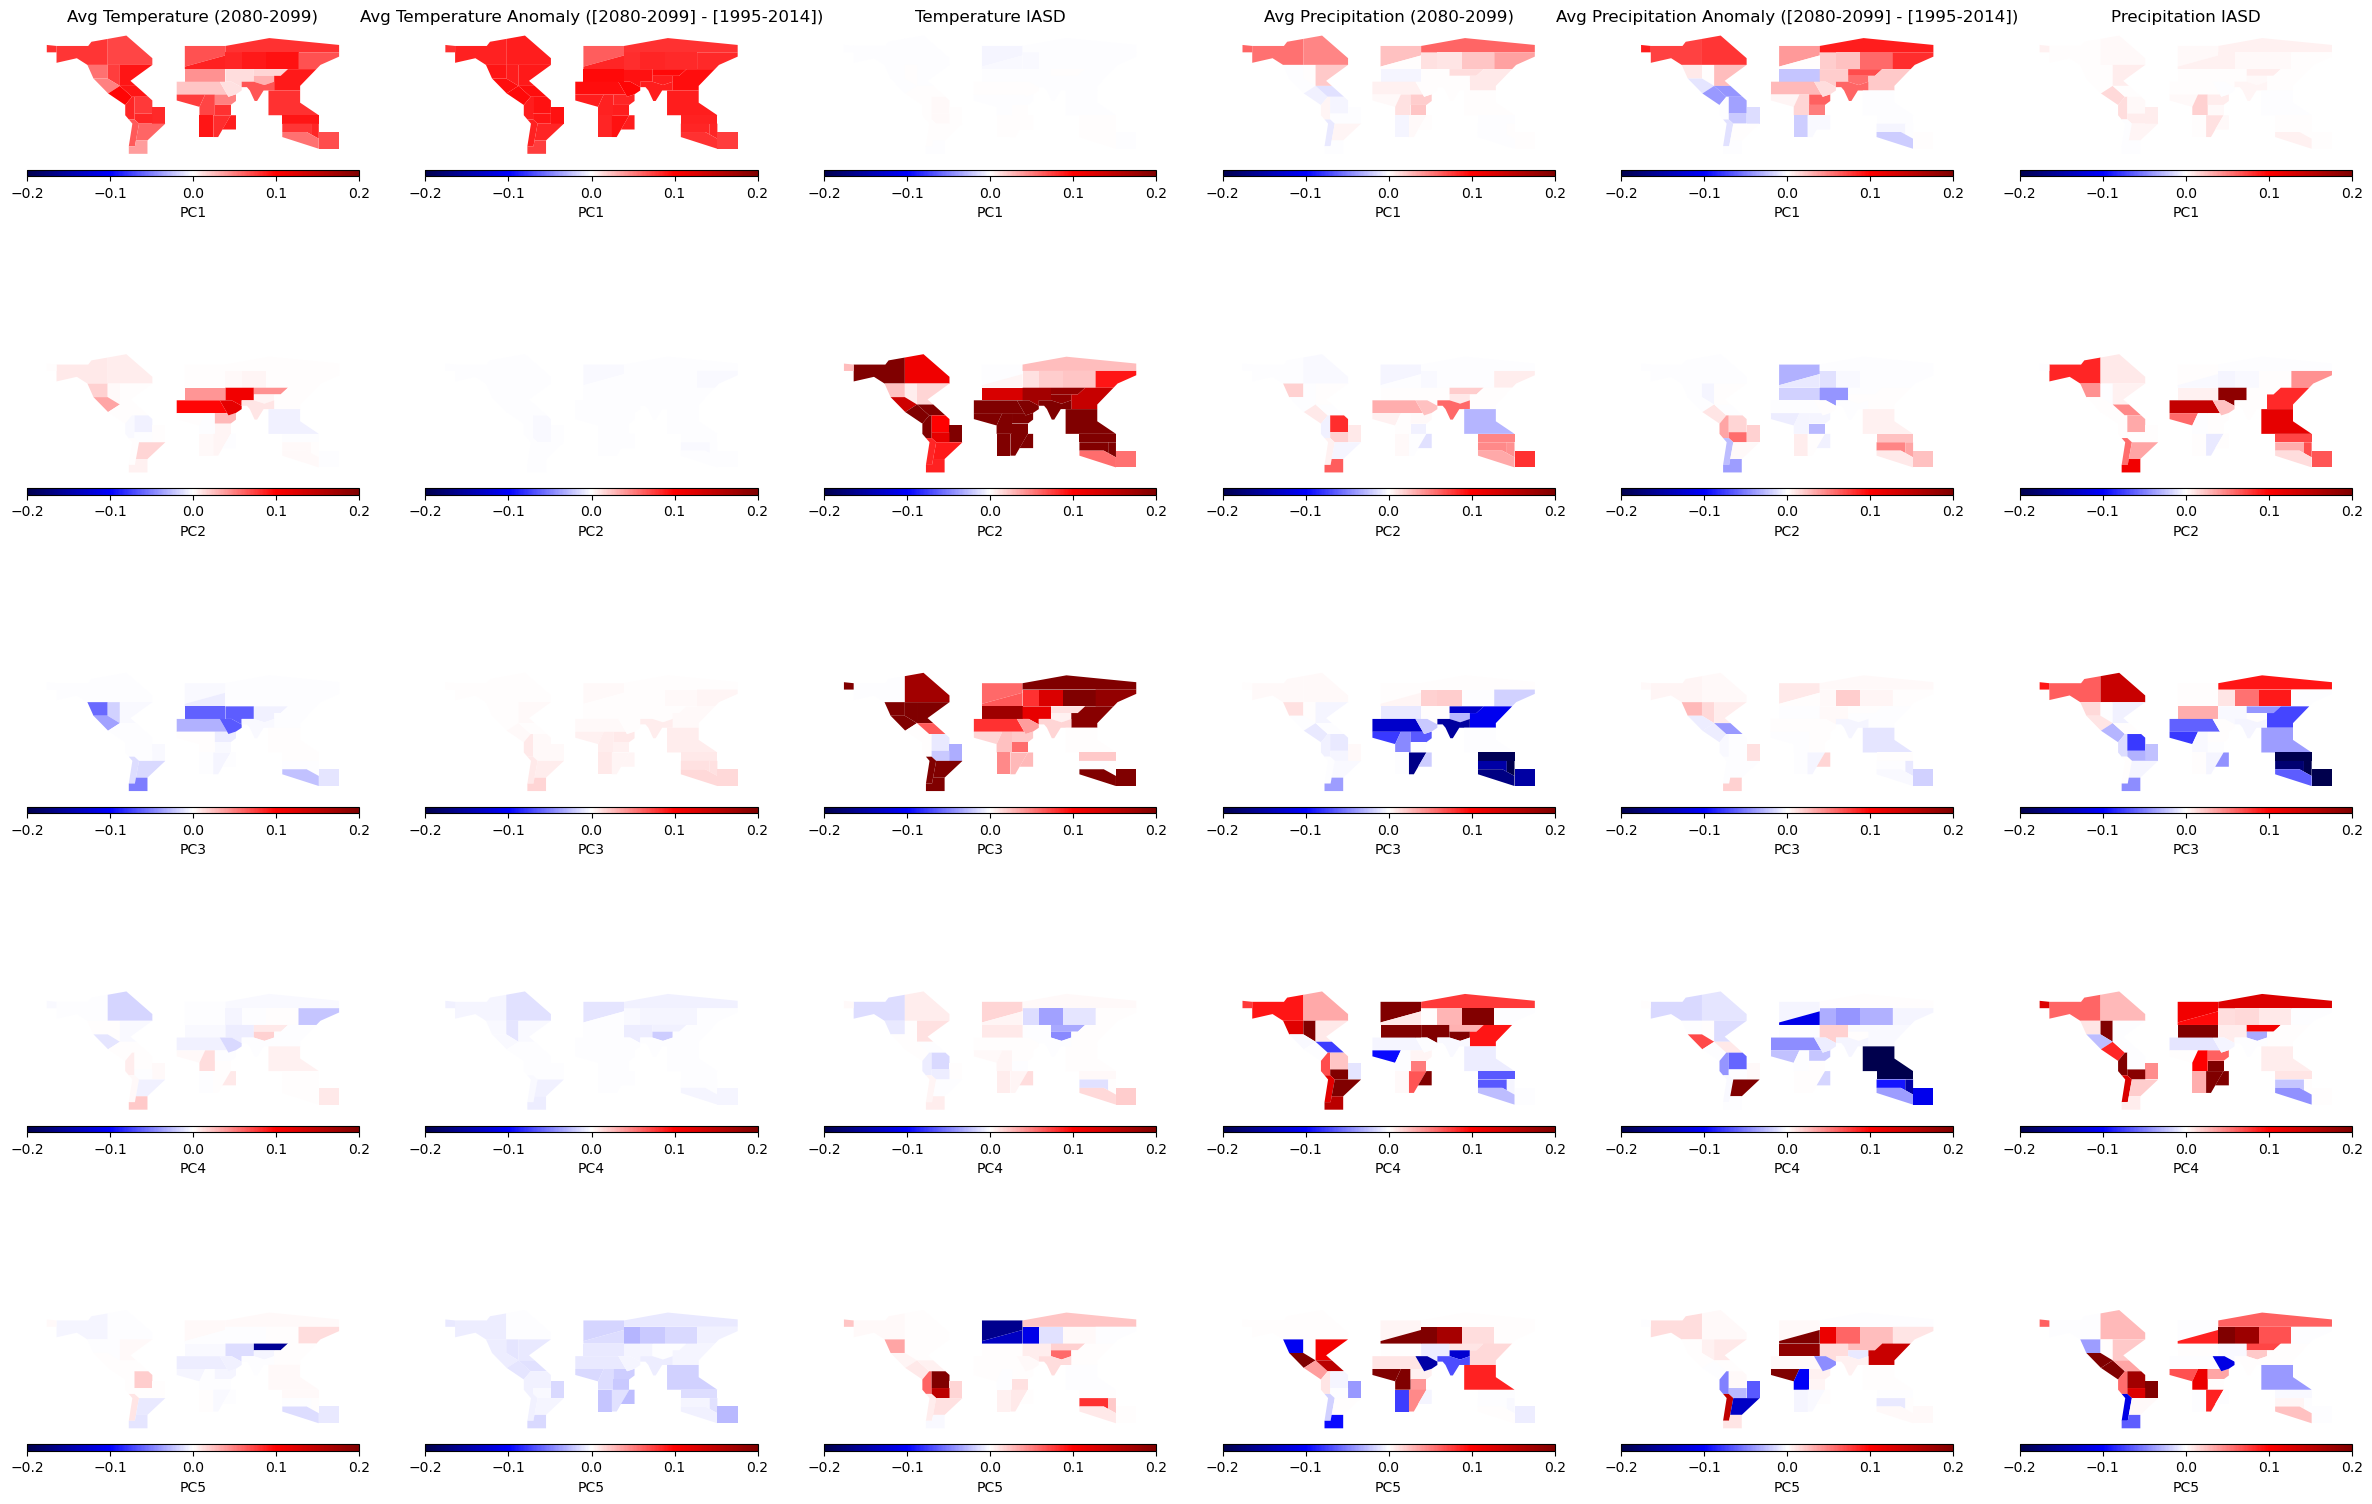

In [72]:
# MEAN TAS FUTURE YEARS
land_data = pd.merge(land_main_gdf, mean_tas_pc_df, left_on='Acronym', right_on='region', how='inner')

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), 
        (ax7, ax8, ax9, ax10, ax11, ax12), 
        (ax13, ax14, ax15, ax16, ax17, ax18), 
        (ax19, ax20, ax21, ax22, ax23, ax24), 
        (ax25, ax26, ax27, ax28, ax29, ax30)) = plt.subplots(5, 6, figsize=(30,20))

vmin = -0.2
vmax = 0.2

component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes("bottom", size="5%", pad=0.1)
ax7.set_axis_off()
land_data.plot(ax=ax7, column=component, cmap='seismic', legend=True, cax=cax7,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider13 = make_axes_locatable(ax13)
cax13 = divider13.append_axes("bottom", size="5%", pad=0.1)
ax13.set_axis_off()
land_data.plot(ax=ax13, column=component, cmap='seismic', legend=True, cax=cax13,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider19 = make_axes_locatable(ax19)
cax19 = divider19.append_axes("bottom", size="5%", pad=0.1)
ax19.set_axis_off()
land_data.plot(ax=ax19, column=component, cmap='seismic', legend=True, cax=cax19,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider25 = make_axes_locatable(ax25)
cax25 = divider25.append_axes("bottom", size="5%", pad=0.1)
ax25.set_axis_off()
land_data.plot(ax=ax25, column=component, cmap='seismic', legend=True, cax=cax25,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# TAS ANOMALY
land_data = pd.merge(land_main_gdf, tas_anomaly_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes("bottom", size="5%", pad=0.1)
ax8.set_axis_off()
land_data.plot(ax=ax8, column=component, cmap='seismic', legend=True, cax=cax8,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.2)

component = 'PC3'
divider14 = make_axes_locatable(ax14)
cax14 = divider14.append_axes("bottom", size="5%", pad=0.1)
ax14.set_axis_off()
land_data.plot(ax=ax14, column=component, cmap='seismic', legend=True, cax=cax14,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider20 = make_axes_locatable(ax20)
cax20 = divider20.append_axes("bottom", size="5%", pad=0.1)
ax20.set_axis_off()
land_data.plot(ax=ax20, column=component, cmap='seismic', legend=True, cax=cax20,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider26 = make_axes_locatable(ax26)
cax26 = divider26.append_axes("bottom", size="5%", pad=0.1)
ax26.set_axis_off()
land_data.plot(ax=ax26, column=component, cmap='seismic', legend=True, cax=cax26,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# TAS IASD
land_data = pd.merge(land_main_gdf, tas_iasd_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider9 = make_axes_locatable(ax9)
cax9 = divider9.append_axes("bottom", size="5%", pad=0.1)
ax9.set_axis_off()
land_data.plot(ax=ax9, column=component, cmap='seismic', legend=True, cax=cax9,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider15 = make_axes_locatable(ax15)
cax15 = divider15.append_axes("bottom", size="5%", pad=0.1)
ax15.set_axis_off()
land_data.plot(ax=ax15, column=component, cmap='seismic', legend=True, cax=cax15,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider21 = make_axes_locatable(ax21)
cax21 = divider21.append_axes("bottom", size="5%", pad=0.1)
ax21.set_axis_off()
land_data.plot(ax=ax21, column=component, cmap='seismic', legend=True, cax=cax21,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider27 = make_axes_locatable(ax27)
cax27 = divider27.append_axes("bottom", size="5%", pad=0.1)
ax27.set_axis_off()
land_data.plot(ax=ax27, column=component, cmap='seismic', legend=True, cax=cax27,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# MEAN PR
land_data = pd.merge(land_main_gdf, mean_pr_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider10 = make_axes_locatable(ax10)
cax10 = divider10.append_axes("bottom", size="5%", pad=0.1)
ax10.set_axis_off()
land_data.plot(ax=ax10, column=component, cmap='seismic', legend=True, cax=cax10,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider16 = make_axes_locatable(ax16)
cax16 = divider16.append_axes("bottom", size="5%", pad=0.1)
ax16.set_axis_off()
land_data.plot(ax=ax16, column=component, cmap='seismic', legend=True, cax=cax16,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider22 = make_axes_locatable(ax22)
cax22 = divider22.append_axes("bottom", size="5%", pad=0.1)
ax22.set_axis_off()
land_data.plot(ax=ax22, column=component, cmap='seismic', legend=True, cax=cax22,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider28 = make_axes_locatable(ax28)
cax28 = divider28.append_axes("bottom", size="5%", pad=0.1)
ax28.set_axis_off()
land_data.plot(ax=ax28, column=component, cmap='seismic', legend=True, cax=cax28,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# PR ANOMALY
land_data = pd.merge(land_main_gdf, pr_anomaly_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes("bottom", size="5%", pad=0.1)
ax5.set_axis_off()
land_data.plot(ax=ax5, column=component, cmap='seismic', legend=True, cax=cax5,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider11 = make_axes_locatable(ax11)
cax11 = divider11.append_axes("bottom", size="5%", pad=0.1)
ax11.set_axis_off()
land_data.plot(ax=ax11, column=component, cmap='seismic', legend=True, cax=cax11,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider17 = make_axes_locatable(ax17)
cax17 = divider17.append_axes("bottom", size="5%", pad=0.1)
ax17.set_axis_off()
land_data.plot(ax=ax17, column=component, cmap='seismic', legend=True, cax=cax17,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider23 = make_axes_locatable(ax23)
cax23 = divider23.append_axes("bottom", size="5%", pad=0.1)
ax23.set_axis_off()
land_data.plot(ax=ax23, column=component, cmap='seismic', legend=True, cax=cax23,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider29 = make_axes_locatable(ax29)
cax29 = divider29.append_axes("bottom", size="5%", pad=0.1)
ax29.set_axis_off()
land_data.plot(ax=ax29, column=component, cmap='seismic', legend=True, cax=cax29,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# PR IASD
land_data = pd.merge(land_main_gdf, pr_iasd_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes("bottom", size="5%", pad=0.1)
ax6.set_axis_off()
land_data.plot(ax=ax6, column=component, cmap='seismic', legend=True, cax=cax6,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC2'
divider12 = make_axes_locatable(ax12)
cax12 = divider12.append_axes("bottom", size="5%", pad=0.1)
ax12.set_axis_off()
land_data.plot(ax=ax12, column=component, cmap='seismic', legend=True, cax=cax12,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider18 = make_axes_locatable(ax18)
cax18 = divider18.append_axes("bottom", size="5%", pad=0.1)
ax18.set_axis_off()
land_data.plot(ax=ax18, column=component, cmap='seismic', legend=True, cax=cax18,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider24 = make_axes_locatable(ax24)
cax24 = divider24.append_axes("bottom", size="5%", pad=0.1)
ax24.set_axis_off()
land_data.plot(ax=ax24, column=component, cmap='seismic', legend=True, cax=cax24,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider30 = make_axes_locatable(ax30)
cax30 = divider30.append_axes("bottom", size="5%", pad=0.1)
ax30.set_axis_off()
land_data.plot(ax=ax30, column=component, cmap='seismic', legend=True, cax=cax30,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

ax1.set_title('Avg Temperature (2080-2099)')
ax2.set_title('Avg Temperature Anomaly ([2080-2099] - [1995-2014])')
ax3.set_title('Temperature IASD')
ax4.set_title('Avg Precipitation (2080-2099)')
ax5.set_title('Avg Precipitation Anomaly ([2080-2099] - [1995-2014])')
ax6.set_title('Precipitation IASD')


# TAS Metrics

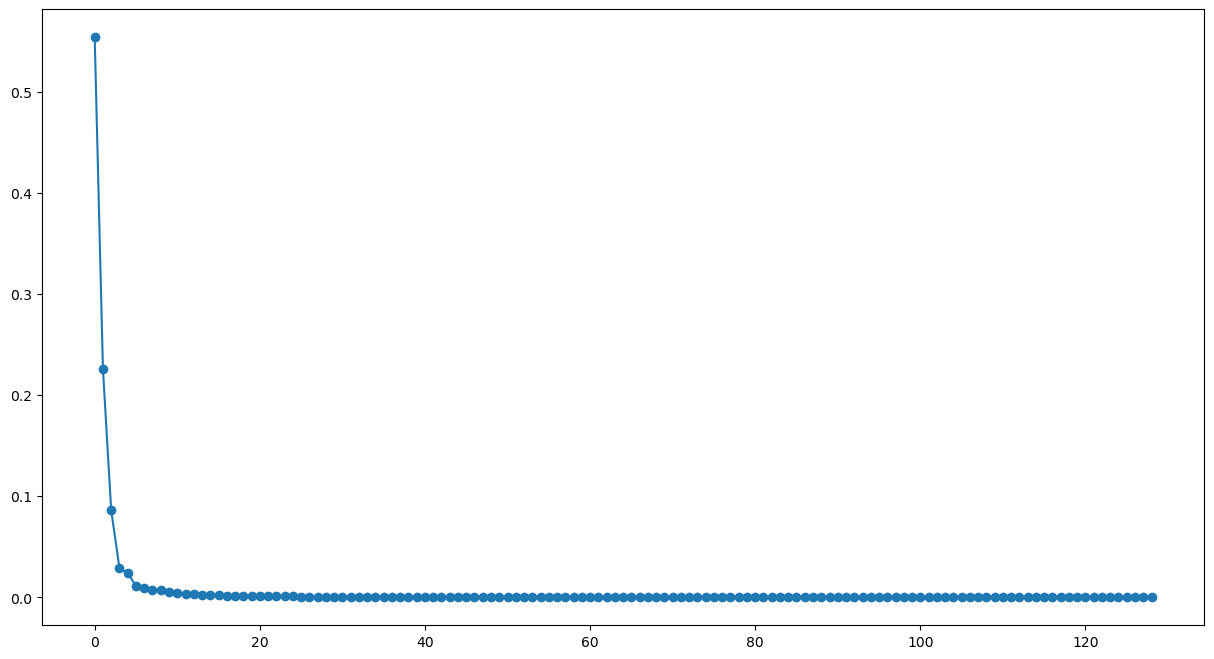

In [73]:
tas_columns = [x for x in full_data_wide.columns.values if ('tas' in x) and (('end' in x) or ('iasd' in x)) and ('pct' not in x)]
scaler = StandardScaler()
scaler.fit(full_data_wide[tas_columns])
fw_scaled = scaler.transform(full_data_wide[tas_columns])  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

[Text(0.5, 0, 'PC5'), Text(0, 0.5, 'PC6')]

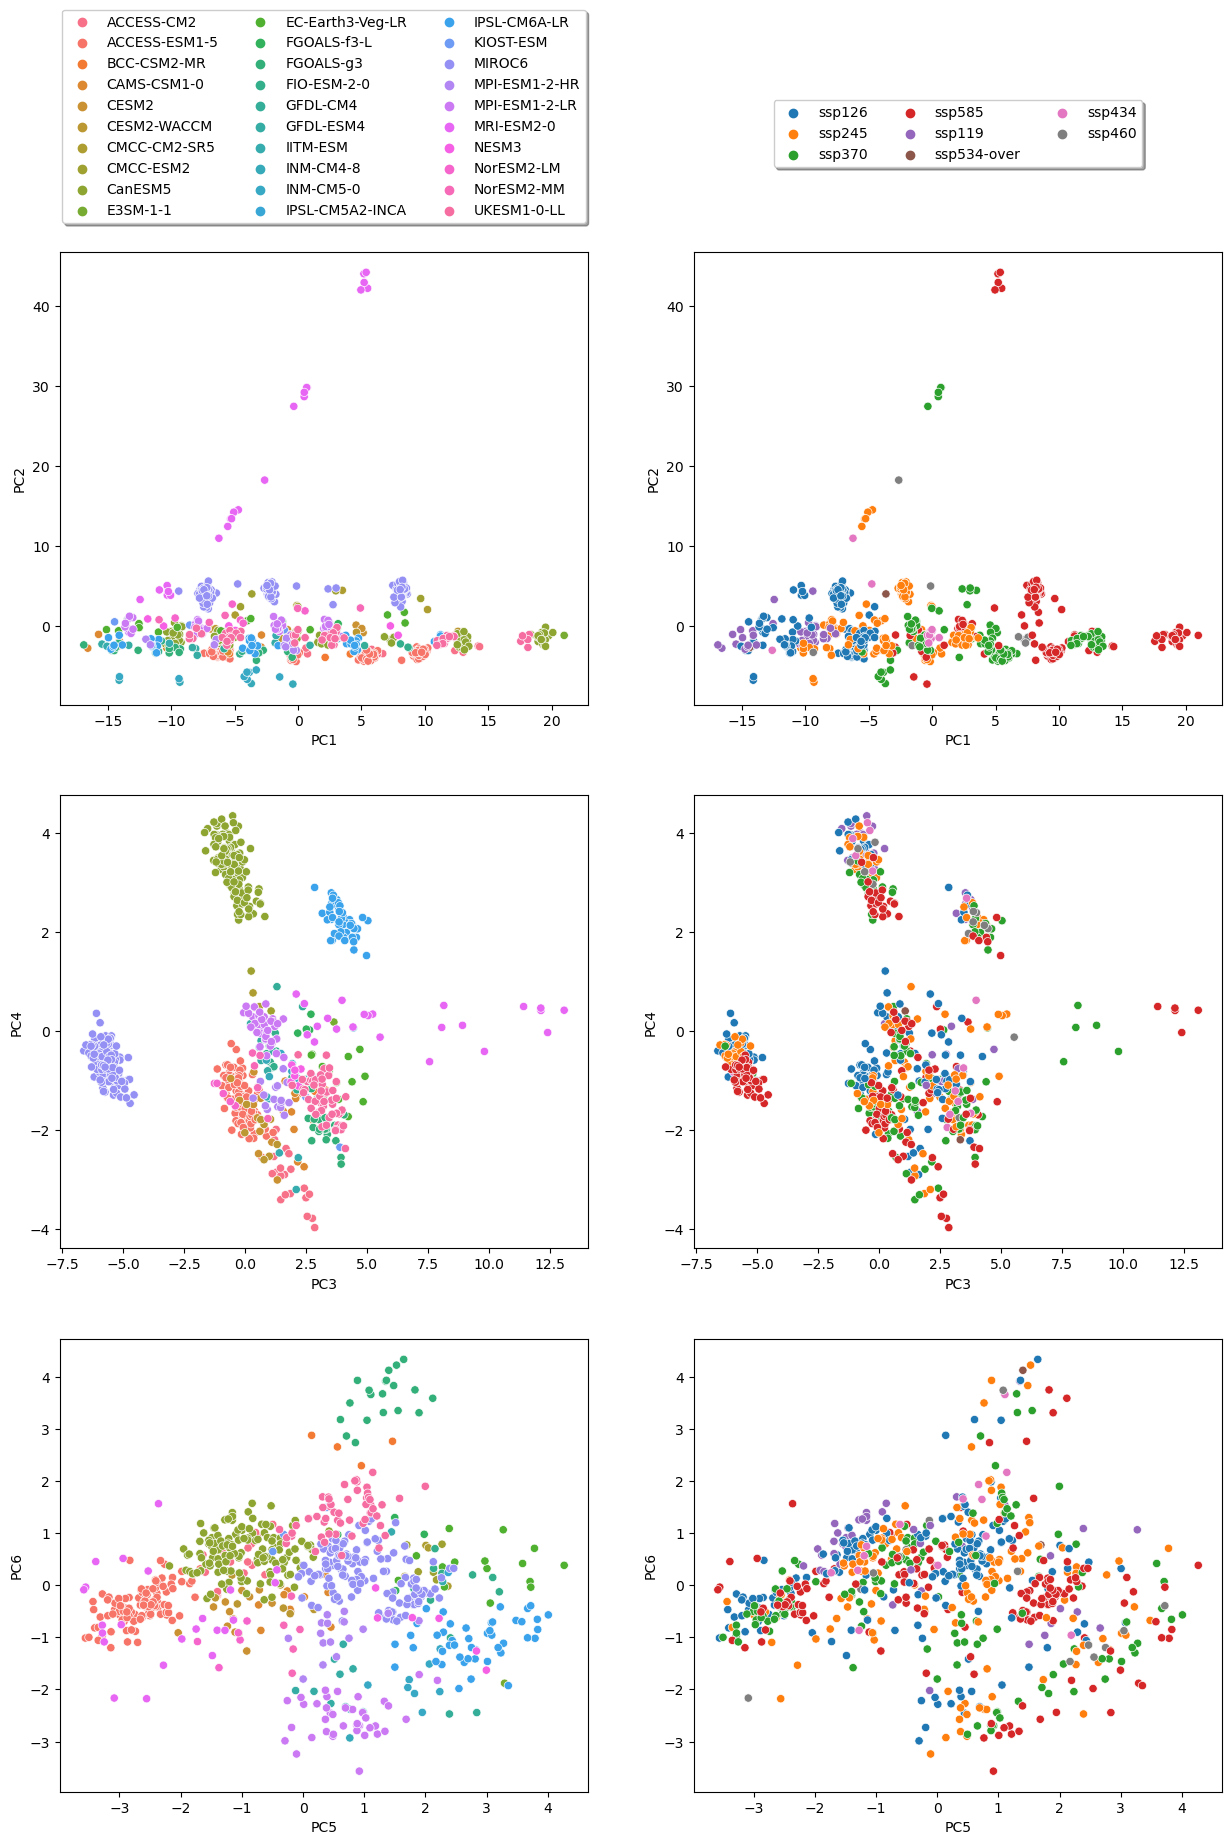

In [74]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,20))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[tas_columns].index[i][0] for i in range(full_data_wide[tas_columns].shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.55),
            ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[tas_columns].index[i][1] for i in range(full_data_wide[tas_columns].shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
            ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[tas_columns].index[i][0] for i in range(full_data_wide[tas_columns].shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[tas_columns].index[i][1] for i in range(full_data_wide[tas_columns].shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax5, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[tas_columns].index[i][0] for i in range(full_data_wide[tas_columns].shape[0])])
ax5.legend_ = None
ax5.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

sns.scatterplot(ax=ax6, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[tas_columns].index[i][1] for i in range(full_data_wide[tas_columns].shape[0])])
ax6.legend_ = None
ax6.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

In [75]:
# MEAN TAS FUTURE YEARS
columns = [x for x in full_data_wide[tas_columns].columns.values if 'end_val | tas' in x]
mean_tas_pc1 = pca.components_[0, ['end_val | tas' in x for x in full_data_wide[tas_columns].columns.values]]
mean_tas_pc2 = pca.components_[1, ['end_val | tas' in x for x in full_data_wide[tas_columns].columns.values]]
mean_tas_pc3 = pca.components_[2, ['end_val | tas' in x for x in full_data_wide[tas_columns].columns.values]]
mean_tas_pc4 = pca.components_[3, ['end_val | tas' in x for x in full_data_wide[tas_columns].columns.values]]
mean_tas_pc5 = pca.components_[4, ['end_val | tas' in x for x in full_data_wide[tas_columns].columns.values]]
mean_tas_regions = [re.sub('end_val | tas | ', '', x).strip('|') for x in columns]
mean_tas_pc_df = pd.DataFrame({
        'region': mean_tas_regions,
        'PC1': np.transpose(100*mean_tas_pc1**3),
        'PC2': np.transpose(100*mean_tas_pc2**3),
        'PC3': np.transpose(100*mean_tas_pc3**3),
        'PC4': np.transpose(100*mean_tas_pc4**3),
        'PC5': np.transpose(100*mean_tas_pc5**3)
})

# TAS ANOMALY
columns = [x for x in full_data_wide[tas_columns].columns.values if 'end_anomaly | tas' in x]
tas_anomaly_pc1 = pca.components_[0, ['end_anomaly | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_anomaly_pc2 = pca.components_[1, ['end_anomaly | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_anomaly_pc3 = pca.components_[2, ['end_anomaly | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_anomaly_pc4 = pca.components_[3, ['end_anomaly | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_anomaly_pc5 = pca.components_[4, ['end_anomaly | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_anomaly_regions = [re.sub('end_anomaly | tas | ', '', x).strip('|') for x in columns]
tas_anomaly_pc_df = pd.DataFrame({
        'region': tas_anomaly_regions,
        'PC1': np.transpose(100*tas_anomaly_pc1**3),
        'PC2': np.transpose(100*tas_anomaly_pc2**3),
        'PC3': np.transpose(100*tas_anomaly_pc3**3),
        'PC4': np.transpose(100*tas_anomaly_pc4**3),
        'PC5': np.transpose(100*tas_anomaly_pc5**3)
})

# TAS IASD
columns = [x for x in full_data_wide[tas_columns].columns.values if 'iasd | tas' in x]
tas_iasd_pc1 = pca.components_[0, ['iasd | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_iasd_pc2 = pca.components_[1, ['iasd | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_iasd_pc3 = pca.components_[2, ['iasd | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_iasd_pc4 = pca.components_[3, ['iasd | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_iasd_pc5 = pca.components_[4, ['iasd | tas' in x for x in full_data_wide[tas_columns].columns.values]]
tas_iasd_regions = [re.sub('iasd | tas | ', '', x).strip('|') for x in columns]
tas_iasd_pc_df = pd.DataFrame({
        'region': tas_iasd_regions,
        'PC1': np.transpose(100*tas_iasd_pc1**3),
        'PC2': np.transpose(100*tas_iasd_pc2**3),
        'PC3': np.transpose(100*tas_iasd_pc3**3),
        'PC4': np.transpose(100*tas_iasd_pc4**3),
        'PC5': np.transpose(100*tas_iasd_pc5**3)
})

<AxesSubplot:>

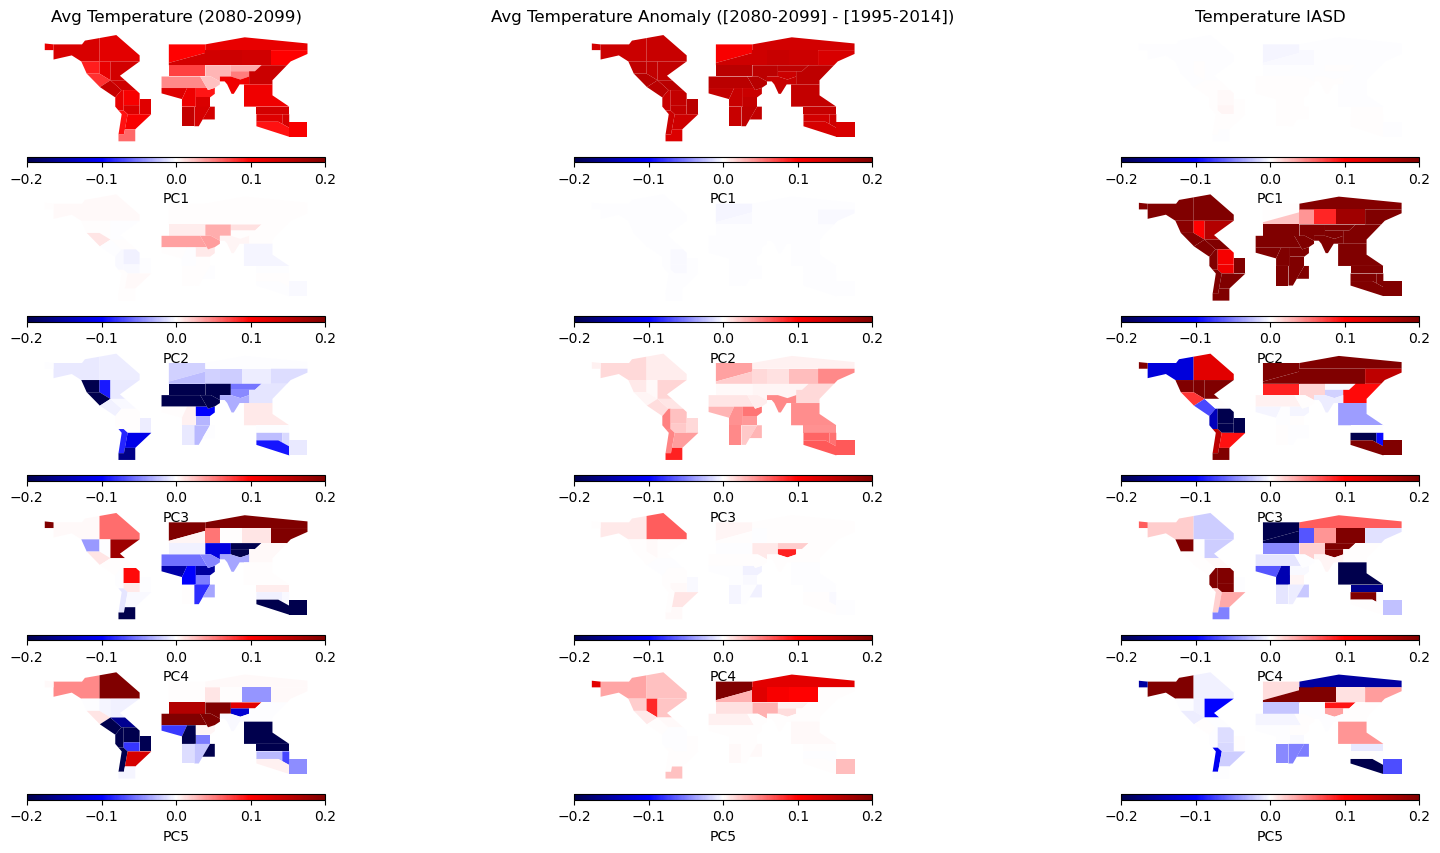

In [76]:
# MEAN TAS FUTURE YEARS
land_data = pd.merge(land_main_gdf, mean_tas_pc_df, left_on='Acronym', right_on='region', how='inner')

fig, ((ax1, ax2, ax3), (ax7, ax8, ax9), (ax13, ax14, ax15), (ax19, ax20, ax21), (ax25, ax26, ax27)) = plt.subplots(5, 3, figsize=(20,10))

vmin = -0.2
vmax = 0.2

component = 'PC1'
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("bottom", size="5%", pad=0.1)
ax1.set_axis_off()
land_data.plot(ax=ax1, column=component, cmap='seismic', legend=True, cax=cax1,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax1.set_title('Avg Temperature (2080-2099)')

component = 'PC2'
divider7 = make_axes_locatable(ax7)
cax7 = divider7.append_axes("bottom", size="5%", pad=0.1)
ax7.set_axis_off()
land_data.plot(ax=ax7, column=component, cmap='seismic', legend=True, cax=cax7,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC3'
divider13 = make_axes_locatable(ax13)
cax13 = divider13.append_axes("bottom", size="5%", pad=0.1)
ax13.set_axis_off()
land_data.plot(ax=ax13, column=component, cmap='seismic', legend=True, cax=cax13,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider19 = make_axes_locatable(ax19)
cax19 = divider19.append_axes("bottom", size="5%", pad=0.1)
ax19.set_axis_off()
land_data.plot(ax=ax19, column=component, cmap='seismic', legend=True, cax=cax19,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider25 = make_axes_locatable(ax25)
cax25 = divider25.append_axes("bottom", size="5%", pad=0.1)
ax25.set_axis_off()
land_data.plot(ax=ax25, column=component, cmap='seismic', legend=True, cax=cax25,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# TAS ANOMALY
land_data = pd.merge(land_main_gdf, tas_anomaly_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.1)
ax2.set_axis_off()
land_data.plot(ax=ax2, column=component, cmap='seismic', legend=True, cax=cax2,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax2.set_title('Avg Temperature Anomaly ([2080-2099] - [1995-2014])')

component = 'PC2'
divider8 = make_axes_locatable(ax8)
cax8 = divider8.append_axes("bottom", size="5%", pad=0.1)
ax8.set_axis_off()
land_data.plot(ax=ax8, column=component, cmap='seismic', legend=True, cax=cax8,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=-0.2)

component = 'PC3'
divider14 = make_axes_locatable(ax14)
cax14 = divider14.append_axes("bottom", size="5%", pad=0.1)
ax14.set_axis_off()
land_data.plot(ax=ax14, column=component, cmap='seismic', legend=True, cax=cax14,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider20 = make_axes_locatable(ax20)
cax20 = divider20.append_axes("bottom", size="5%", pad=0.1)
ax20.set_axis_off()
land_data.plot(ax=ax20, column=component, cmap='seismic', legend=True, cax=cax20,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider26 = make_axes_locatable(ax26)
cax26 = divider26.append_axes("bottom", size="5%", pad=0.1)
ax26.set_axis_off()
land_data.plot(ax=ax26, column=component, cmap='seismic', legend=True, cax=cax26,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# TAS IASD
land_data = pd.merge(land_main_gdf, tas_iasd_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.1)
ax3.set_axis_off()
land_data.plot(ax=ax3, column=component, cmap='seismic', legend=True, cax=cax3,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax3.set_title('Temperature IASD')

component = 'PC2'
divider9 = make_axes_locatable(ax9)
cax9 = divider9.append_axes("bottom", size="5%", pad=0.1)
ax9.set_axis_off()
land_data.plot(ax=ax9, column=component, cmap='seismic', legend=True, cax=cax9,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider15 = make_axes_locatable(ax15)
cax15 = divider15.append_axes("bottom", size="5%", pad=0.1)
ax15.set_axis_off()
land_data.plot(ax=ax15, column=component, cmap='seismic', legend=True, cax=cax15,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider21 = make_axes_locatable(ax21)
cax21 = divider21.append_axes("bottom", size="5%", pad=0.1)
ax21.set_axis_off()
land_data.plot(ax=ax21, column=component, cmap='seismic', legend=True, cax=cax21,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider27 = make_axes_locatable(ax27)
cax27 = divider27.append_axes("bottom", size="5%", pad=0.1)
ax27.set_axis_off()
land_data.plot(ax=ax27, column=component, cmap='seismic', legend=True, cax=cax27,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# PR Metrics

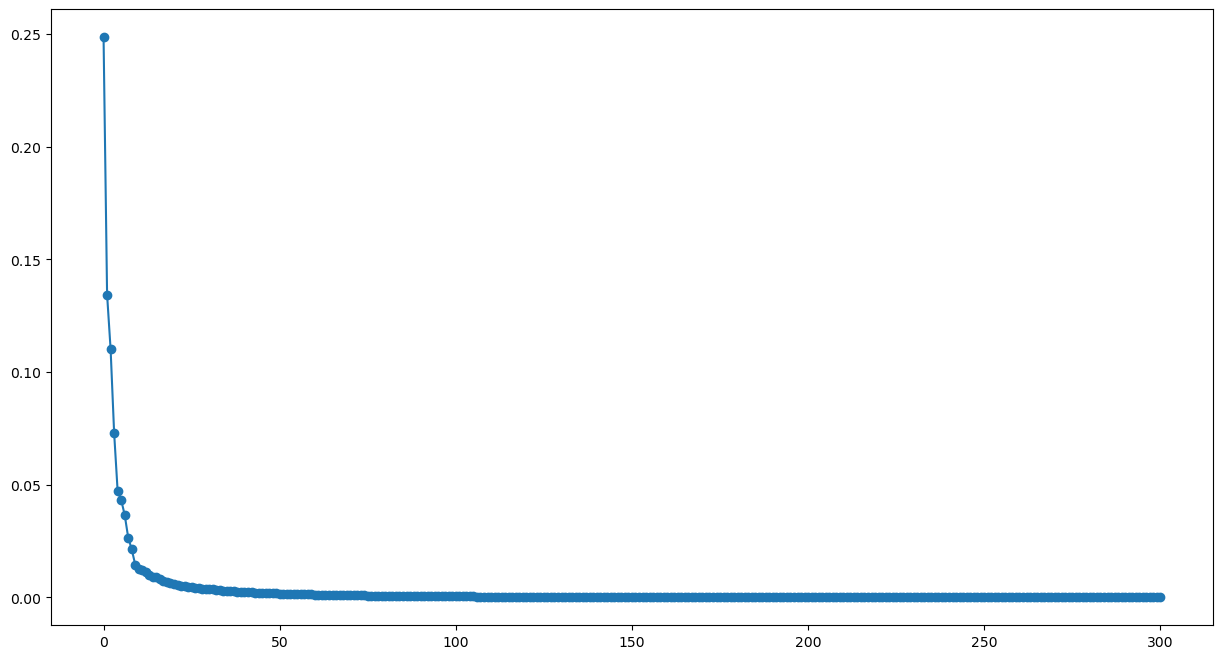

In [77]:
pr_columns = [x for x in full_data_wide.columns.values if 'pr' in x]
scaler = StandardScaler()
scaler.fit(full_data_wide[pr_columns])
fw_scaled = scaler.transform(full_data_wide[pr_columns])  
pca = PCA()
full_pca = pca.fit_transform(fw_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.scatter(x=range(pca.n_components_), y=pca.explained_variance_ratio_)
plt.show()
plt.close()

[Text(0.5, 0, 'PC5'), Text(0, 0.5, 'PC6')]

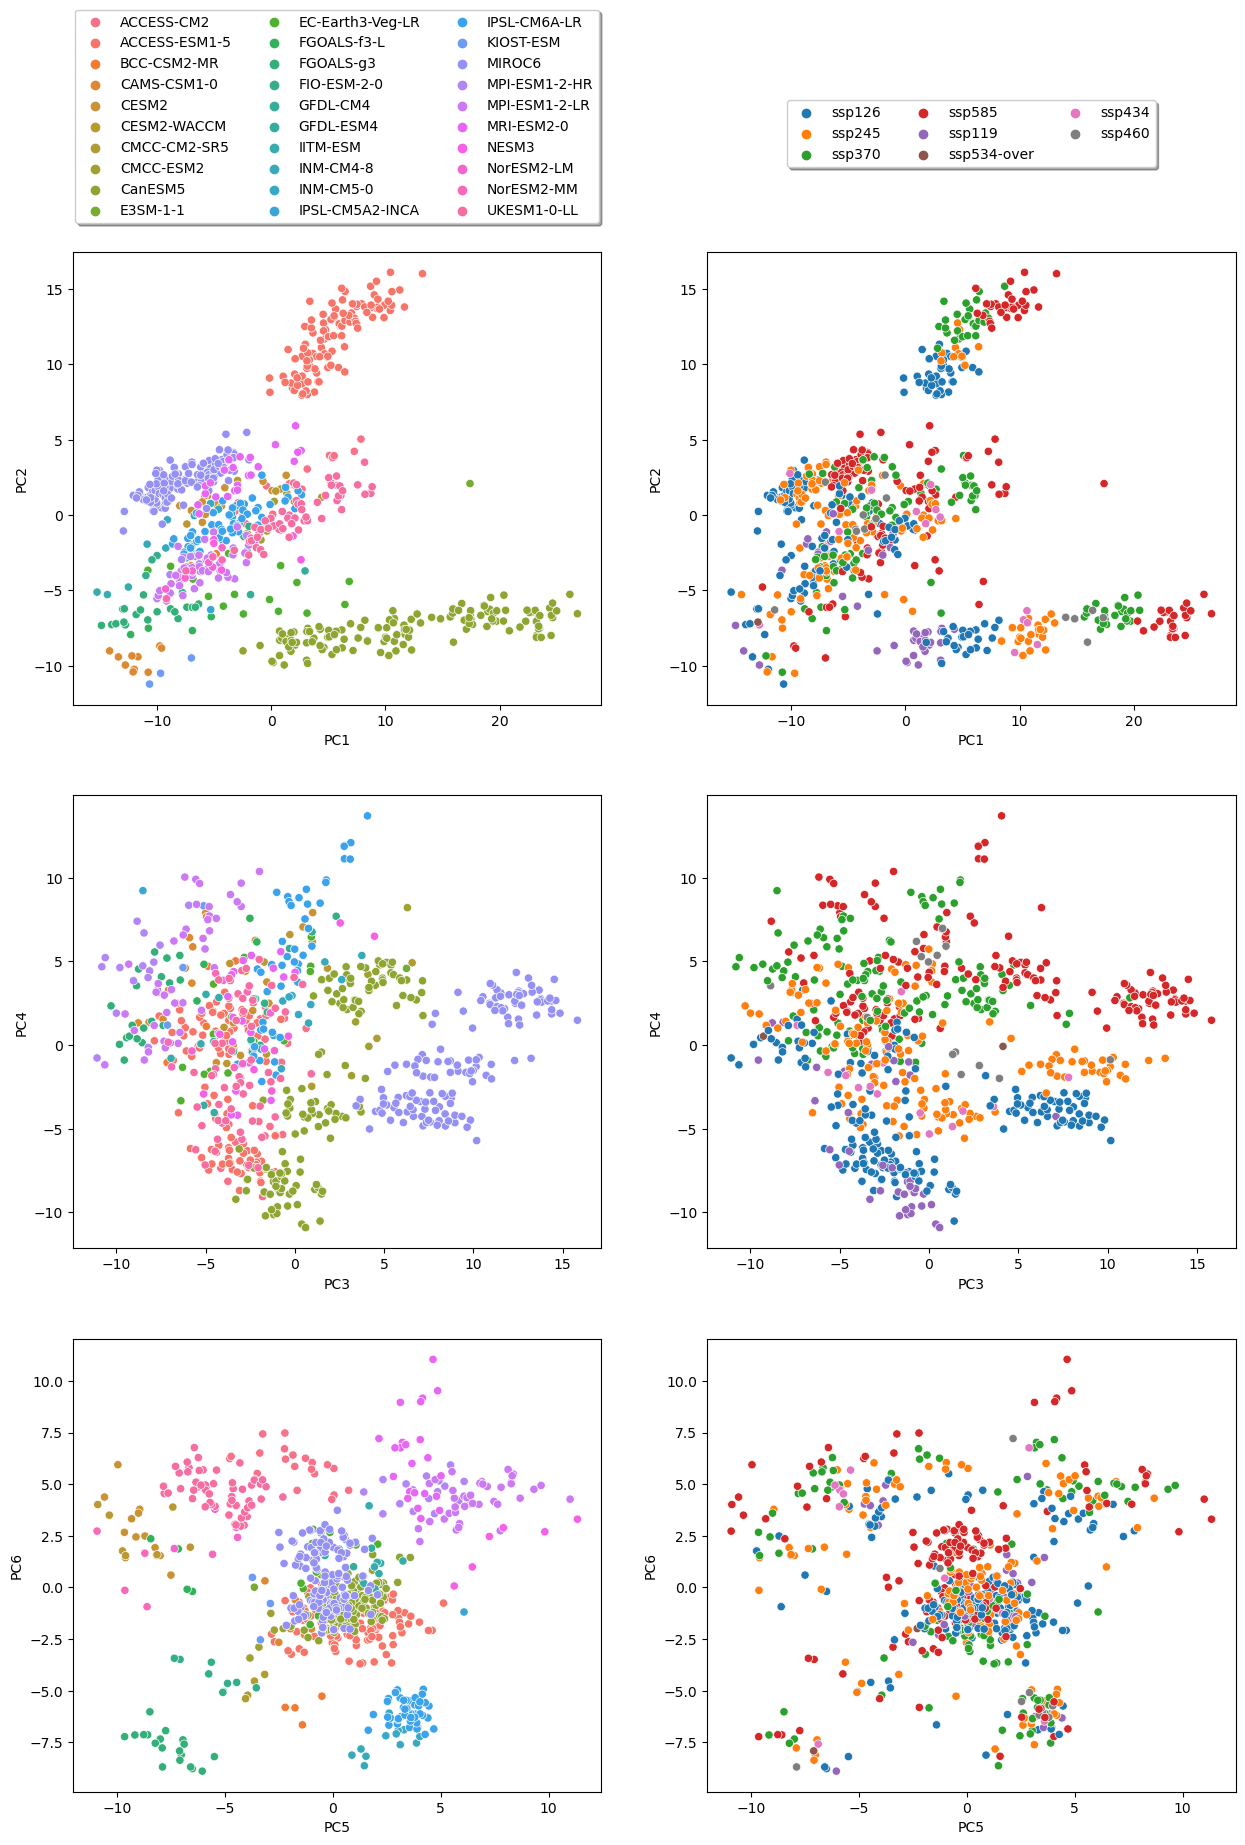

In [78]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,20))

sns.scatterplot(ax=ax1, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[pr_columns].index[i][0] for i in range(full_data_wide[pr_columns].shape[0])])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.55),
            ncol=3, fancybox=True, shadow=True)
ax1.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax2, x=full_pca[:,0], y=full_pca[:,1], hue=[full_data_wide[pr_columns].index[i][1] for i in range(full_data_wide[pr_columns].shape[0])])
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
            ncol=3, fancybox=True, shadow=True)
ax2.set(xlabel="PC{}".format(1), ylabel="PC{}".format(2))

sns.scatterplot(ax=ax3, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[pr_columns].index[i][0] for i in range(full_data_wide[pr_columns].shape[0])])
ax3.legend_ = None
ax3.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax4, x=full_pca[:,2], y=full_pca[:,3], hue=[full_data_wide[pr_columns].index[i][1] for i in range(full_data_wide[pr_columns].shape[0])])
ax4.legend_ = None
ax4.set(xlabel="PC{}".format(3), ylabel="PC{}".format(4))

sns.scatterplot(ax=ax5, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[pr_columns].index[i][0] for i in range(full_data_wide[pr_columns].shape[0])])
ax5.legend_ = None
ax5.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

sns.scatterplot(ax=ax6, x=full_pca[:,4], y=full_pca[:,5], hue=[full_data_wide[pr_columns].index[i][1] for i in range(full_data_wide[pr_columns].shape[0])])
ax6.legend_ = None
ax6.set(xlabel="PC{}".format(5), ylabel="PC{}".format(6))

In [79]:
# MEAN PR
columns = [x for x in full_data_wide[pr_columns].columns.values if 'end_val | pr' in x]
mean_pr_pc1 = pca.components_[0, ['end_val | pr' in x for x in full_data_wide[pr_columns].columns.values]]
mean_pr_pc2 = pca.components_[1, ['end_val | pr' in x for x in full_data_wide[pr_columns].columns.values]]
mean_pr_pc3 = pca.components_[2, ['end_val | pr' in x for x in full_data_wide[pr_columns].columns.values]]
mean_pr_pc4 = pca.components_[3, ['end_val | pr' in x for x in full_data_wide[pr_columns].columns.values]]
mean_pr_pc5 = pca.components_[4, ['end_val | pr' in x for x in full_data_wide[pr_columns].columns.values]]
mean_pr_regions = [re.sub('end_val | pr | ', '', x).strip('|') for x in columns]
mean_pr_pc_df = pd.DataFrame({
        'region': mean_pr_regions,
        'PC1': np.transpose(100*mean_pr_pc1**3),
        'PC2': np.transpose(100*mean_pr_pc2**3),
        'PC3': np.transpose(100*mean_pr_pc3**3),
        'PC4': np.transpose(100*mean_pr_pc4**3),
        'PC5': np.transpose(100*mean_pr_pc5**3)
})

# PR ANOMALY
columns = [x for x in full_data_wide[pr_columns].columns.values if 'end_anomaly | pr' in x]
pr_anomaly_pc1 = pca.components_[0, ['end_anomaly | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_anomaly_pc2 = pca.components_[1, ['end_anomaly | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_anomaly_pc3 = pca.components_[2, ['end_anomaly | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_anomaly_pc4 = pca.components_[3, ['end_anomaly | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_anomaly_pc5 = pca.components_[4, ['end_anomaly | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_anomaly_regions = [re.sub('end_anomaly | pr | ', '', x).strip('|') for x in columns]
pr_anomaly_pc_df = pd.DataFrame({
        'region': pr_anomaly_regions,
        'PC1': np.transpose(100*pr_anomaly_pc1**3),
        'PC2': np.transpose(100*pr_anomaly_pc2**3),
        'PC3': np.transpose(100*pr_anomaly_pc3**3),
        'PC4': np.transpose(100*pr_anomaly_pc4**3),
        'PC5': np.transpose(100*pr_anomaly_pc5**3)
})

# PR IASD
columns = [x for x in full_data_wide[pr_columns].columns.values if 'iasd | pr' in x]
pr_iasd_pc1 = pca.components_[0, ['iasd | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_iasd_pc2 = pca.components_[1, ['iasd | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_iasd_pc3 = pca.components_[2, ['iasd | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_iasd_pc4 = pca.components_[3, ['iasd | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_iasd_pc5 = pca.components_[4, ['iasd | pr' in x for x in full_data_wide[pr_columns].columns.values]]
pr_iasd_regions = [re.sub('iasd | pr | ', '', x).strip('|') for x in columns]
pr_iasd_pc_df = pd.DataFrame({
        'region': pr_iasd_regions,
        'PC1': np.transpose(100*pr_iasd_pc1**3),
        'PC2': np.transpose(100*pr_iasd_pc2**3),
        'PC3': np.transpose(100*pr_iasd_pc3**3),
        'PC4': np.transpose(100*pr_iasd_pc4**3),
        'PC5': np.transpose(100*pr_iasd_pc5**3)
})

<AxesSubplot:>

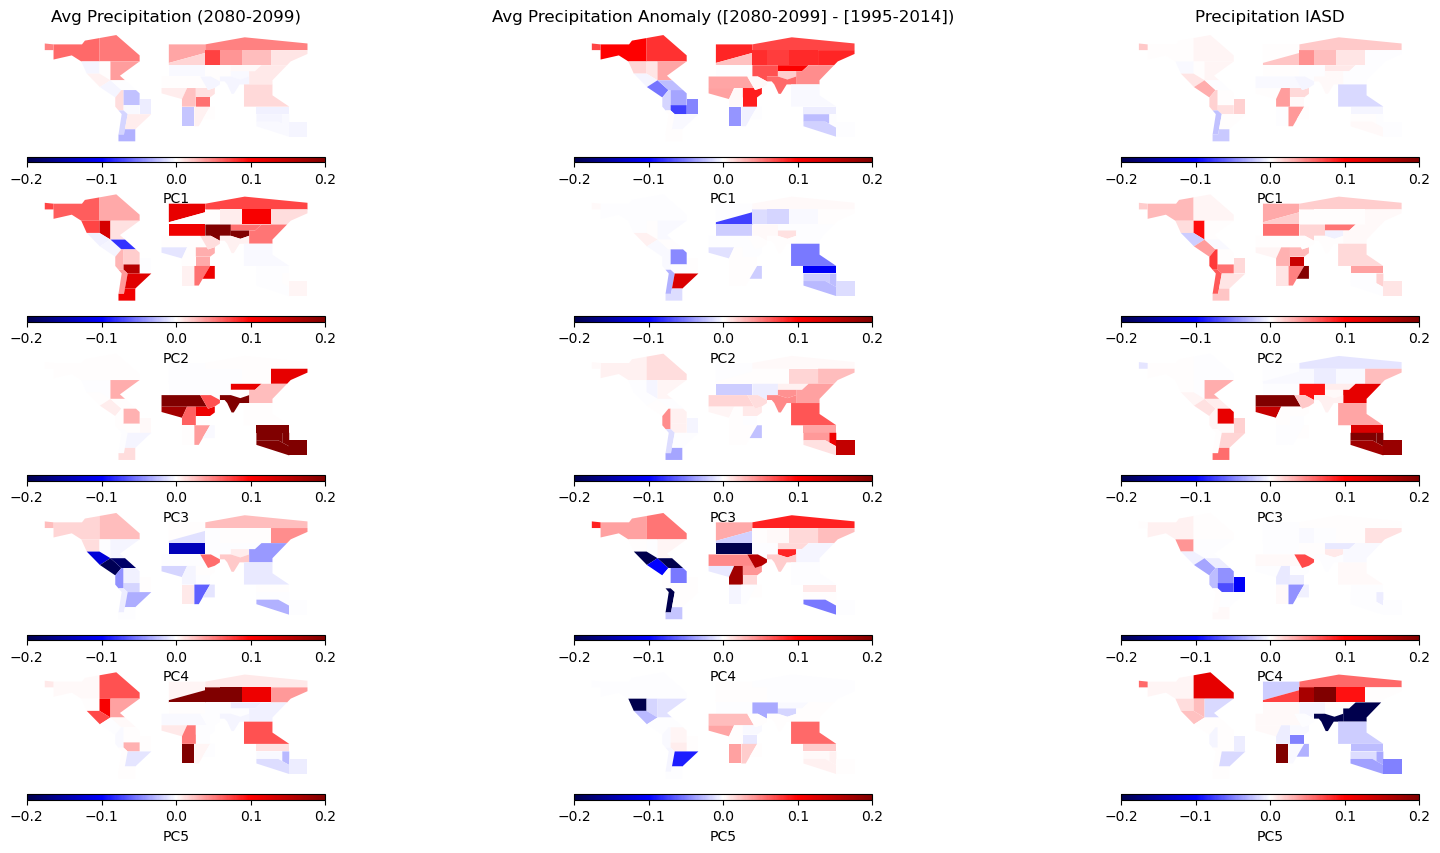

In [80]:
# MEAN TAS FUTURE YEARS

fig, ((ax4, ax5, ax6), (ax10, ax11, ax12), (ax16, ax17, ax18), (ax22, ax23, ax24), (ax28, ax29, ax30)) = plt.subplots(5, 3, figsize=(20,10))

vmin = -0.2
vmax = 0.2

# MEAN PR
land_data = pd.merge(land_main_gdf, mean_pr_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider4 = make_axes_locatable(ax4)
cax4 = divider4.append_axes("bottom", size="5%", pad=0.1)
ax4.set_axis_off()
land_data.plot(ax=ax4, column=component, cmap='seismic', legend=True, cax=cax4,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax4.set_title('Avg Precipitation (2080-2099)')

component = 'PC2'
divider10 = make_axes_locatable(ax10)
cax10 = divider10.append_axes("bottom", size="5%", pad=0.1)
ax10.set_axis_off()
land_data.plot(ax=ax10, column=component, cmap='seismic', legend=True, cax=cax10,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider16 = make_axes_locatable(ax16)
cax16 = divider16.append_axes("bottom", size="5%", pad=0.1)
ax16.set_axis_off()
land_data.plot(ax=ax16, column=component, cmap='seismic', legend=True, cax=cax16,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider22 = make_axes_locatable(ax22)
cax22 = divider22.append_axes("bottom", size="5%", pad=0.1)
ax22.set_axis_off()
land_data.plot(ax=ax22, column=component, cmap='seismic', legend=True, cax=cax22,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider28 = make_axes_locatable(ax28)
cax28 = divider28.append_axes("bottom", size="5%", pad=0.1)
ax28.set_axis_off()
land_data.plot(ax=ax28, column=component, cmap='seismic', legend=True, cax=cax28,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# PR ANOMALY
land_data = pd.merge(land_main_gdf, pr_anomaly_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider5 = make_axes_locatable(ax5)
cax5 = divider5.append_axes("bottom", size="5%", pad=0.1)
ax5.set_axis_off()
land_data.plot(ax=ax5, column=component, cmap='seismic', legend=True, cax=cax5,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax5.set_title('Avg Precipitation Anomaly ([2080-2099] - [1995-2014])')

component = 'PC2'
divider11 = make_axes_locatable(ax11)
cax11 = divider11.append_axes("bottom", size="5%", pad=0.1)
ax11.set_axis_off()
land_data.plot(ax=ax11, column=component, cmap='seismic', legend=True, cax=cax11,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider17 = make_axes_locatable(ax17)
cax17 = divider17.append_axes("bottom", size="5%", pad=0.1)
ax17.set_axis_off()
land_data.plot(ax=ax17, column=component, cmap='seismic', legend=True, cax=cax17,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider23 = make_axes_locatable(ax23)
cax23 = divider23.append_axes("bottom", size="5%", pad=0.1)
ax23.set_axis_off()
land_data.plot(ax=ax23, column=component, cmap='seismic', legend=True, cax=cax23,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider29 = make_axes_locatable(ax29)
cax29 = divider29.append_axes("bottom", size="5%", pad=0.1)
ax29.set_axis_off()
land_data.plot(ax=ax29, column=component, cmap='seismic', legend=True, cax=cax29,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

# PR IASD
land_data = pd.merge(land_main_gdf, pr_iasd_pc_df, left_on='Acronym', right_on='region', how='inner')

component = 'PC1'
divider6 = make_axes_locatable(ax6)
cax6 = divider6.append_axes("bottom", size="5%", pad=0.1)
ax6.set_axis_off()
land_data.plot(ax=ax6, column=component, cmap='seismic', legend=True, cax=cax6,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
ax6.set_title('Precipitation IASD')

component = 'PC2'
divider12 = make_axes_locatable(ax12)
cax12 = divider12.append_axes("bottom", size="5%", pad=0.1)
ax12.set_axis_off()
land_data.plot(ax=ax12, column=component, cmap='seismic', legend=True, cax=cax12,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)
fig.subplots_adjust(hspace=0.2)

component = 'PC3'
divider18 = make_axes_locatable(ax18)
cax18 = divider18.append_axes("bottom", size="5%", pad=0.1)
ax18.set_axis_off()
land_data.plot(ax=ax18, column=component, cmap='seismic', legend=True, cax=cax18,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC4'
divider24 = make_axes_locatable(ax24)
cax24 = divider24.append_axes("bottom", size="5%", pad=0.1)
ax24.set_axis_off()
land_data.plot(ax=ax24, column=component, cmap='seismic', legend=True, cax=cax24,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)

component = 'PC5'
divider30 = make_axes_locatable(ax30)
cax30 = divider30.append_axes("bottom", size="5%", pad=0.1)
ax30.set_axis_off()
land_data.plot(ax=ax30, column=component, cmap='seismic', legend=True, cax=cax30,
    legend_kwds={"label": component, "orientation": "horizontal"}, vmin=vmin, vmax=vmax,
    missing_kwds={'color': 'lightgrey'}
)